# Création d'un outil de scoring crédit pour la société "Prêt à dépenser"

-------------------------------------------------------------------------------------------------------------------------------

## Présentation du projet

Objectif : développer une modèle de classification afin de prédire si un client peut rembourser ou non son prêt.
Mais aussi, d'afficher les variables qui ont influencé les résultats, si un client obtient un refus de prêt.

Les données proviennent de la société. Nous disposons : 
- un historique de prêt
- un historique d’informations financières
- des informations sur le comportement des emprunteurs (si l’emprunteur a fait défaut ou pas).

Commençons par importer les bibliothèques dont nous avons besoin

In [1]:
#notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk

import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
import jenkspy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
# Import train_test_split function
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest, f_classif,mutual_info_classif
from skfeature.function.similarity_based import fisher_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
 
import mlflow


## Construction de la base de données

Nous utilisons un script qui provient de kaggle :
https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

Nous ajoutons une partie de code afin de pouvoir obtenir un échantillon avec les mêmes proportions (il faut un ordinateur plus puissant pour réaliser les calculs sur un nombre de données important)

In [2]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
#####encoder les colonnes catégorielles
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    ####lecture des fichiers application_train et application test
    df = pd.read_csv('./input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('./input/application_test.csv', nrows= num_rows)
    ####affiche le nb de lignes
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    print("lignes", num_rows)
    if num_rows!=None:
        ###ajout de code pour obtenir un échantillon avec les mêmes proportions
        ech_train=int((float(num_rows)*float(0.86)))
        ech_test=int((float(num_rows)*float(0.14)))

        test_part=(df.loc[df["TARGET"].isnull()]).sample(n=ech_test)
        print("ech train : "+str(ech_train))
        print("ech test : "+str(ech_test))

        ech1=int((float(ech_train)*float(0.9193)))
        ech2=int((float(ech_train)*float(0.0807)))

        print("ech train 0 : "+str(ech1))
        print("ech train 1 : "+str(ech2))

        part1=(df.loc[df["TARGET"]==0]).sample(n=ech1)
        part2=(df.loc[df["TARGET"]==1]).sample(n=ech2)

        result = part1.append(part2)
        result2 = result.append(test_part)

        print("shape result {}".format(result2.shape))
        df = result2
        print("test nb : ", df.loc[df["TARGET"]==1].shape)
    
    # Categorical features with Binary encode (0 or 1; two categories)
    ####encodage des variables binaires 1/0 et on applique one_hot_encoder sur les autres variables
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    ####on remplace les vide de la variable DAYS_EMPLOYED par 1 an = 365.243 
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True) # manque un point ?
    ####Creation de variables 
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    ####suppresion des data test_df et nettoyage du garbage collector : nettoyage des vieux objects
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    ####lecture des data et encodage des variable cat
    bureau = pd.read_csv('./input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    ####calcul d'agregat pour les variables
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    ## jointure bureau - bureau_balance
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    ###suppr bureau balance et nettoyage des objects
    del bb, bb_agg
    gc.collect()
    
    #######nouveaux calcul d'agregation pour les variables
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    ####création des aggregations pour les credits ouverts et jointure
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    ####création des aggregations pour les credits fermés et jointure
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    ####calcul agregat
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    ####agregat approuvé
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    ####agregat refusé
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    ###agregat
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code

### erreur special caractere dans le nom d'un variable
def kfold_lightgbm(df, num_folds, stratified = False, debug= False): ####changed paramater stratified True to False
    
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    # Cross validation model
    ##créez un séparateur de CV - StratifiedKFold parce que c'est un problème de classification / Kfold regression
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001) ### shuffle melanger les echantillons avant division en lots 
        #random_state = ordre d'indice pourcontroler l'aspect alea
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
       
        clf = LGBMClassifier(
            nthread=4,#utilise 4 threads
            n_estimators=10000, ## nombre d'arbres à l'interieur de l'ensemble
            learning_rate=0.02,# le paramètre de taille de pas de la descente de gradient / contrôle la vitesse d'apprentissage. Les valeurs typiques se situent entre 0,01 et 0,3
            num_leaves=34, ## contrôle le nombre de feuilles >>> 2^(max_depth). 
            # Cela signifie que la valeur optimale pour num_leavesse situe dans la plage (2^3, 2^12) ou (8, 4096).
            ##num_leaves impacte l'apprentissage dans LGBM plus de max_depth. Cela signifie qu'il faut spécifier une plage de recherche plus conservatrice comme (20, 3000)
            
            colsample_bytree=0.9497036,
            subsample=0.8715623,# bagging_fraction valeur subsample comprise entre (0, 1) et spécifie le pourcentage d'échantillons d'apprentissage à utiliser pour entraîner chaque arbre
            ## pour activer subsample il faut definir bagging_freq/subsample_freq defaut 0
            
            max_depth=8, ##valeur entre 3 et 12 plus un arbre est haut et plus il est complexe
            reg_alpha=0.041545473, #lambda_l1 :  une bonne plage de recherche est (0, 100)
            reg_lambda=0.0735294, #lambda_l2 :  une bonne plage de recherche est (0, 100)
            min_split_gain=0.0222415, # regularisation supplémentaire dans les plages de parametres : plage de recherche prudente est (0, 15)
            min_child_weight=39.3259775,
            #silent=-1,
            verbose=-1, )
        
        ####option : feature_fraction spécifie le pourcentage d'entités à échantillonner lors de l'apprentissage de chaque arbre. Ainsi, il prend également une valeur comprise entre (0, 1).

        ########option early_stopping_roundsparamètres à l'intérieur de la fitfonction. 
        ####Par exemple, le définir sur 100 signifie que nous arrêtons l'entraînement 
        ###si les prédictions ne se sont pas améliorées au cours des 100 derniers tours.
        ###il faut avoir mis un eval_set : X_train, X_eval, y_train, y_eval = train_test_split(X_enc, y, test_size=0.1)
        ###eval_set = [(X_eval, y_eval)]
        ##qualité des prédictions est mesurée avec une métrique passée dans eval_metric
        #####option categorical_feature=cat_idx,  # Specify the categoricals # indiquer la liste des var quali
        ##autre param min_data_in_leafsur : ex : si la feuille de décision vérifie si une caractéristique est supérieure à, disons, 13 - la définition min_data_in_leafsur 100 signifie que nous voulons évaluer cette feuille uniquement si au moins 100 observations d'entraînement sont supérieures à 13
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        ##calul des predictions
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        
        ##resultats en fonction des fold et courbe de roc
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')
    
###"UTiliser Optuna pour optimiser les hyperparamètres"



In [3]:
# lance chaque fonction avec un timer
def main(debug = True):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    
    ####import fichiers + calcul agregats (new features) et jointure de toutes les tables
    ### + nettoyage memoire
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    #######target : le pret a été remboursé et 1 le pret n'a pas ete   remboursé
    with timer("Run LightGBM with kfold"):
        df.columns = df.columns.str.strip()     
        df.columns = df.columns.str.replace(' ', '_')         
        df.columns = df.columns.str.replace(r"[^a-zA-Z\d\_]+", "")    
        df.columns = df.columns.str.replace(r"[^a-zA-Z\d\_]+", "")
        #feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= True, debug= debug)
        return df#, feat_importance
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df =main(False)
        #, feat_importance
       

Train samples: 307511, test samples: 48744
lignes None
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 20s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 29s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 26)
Process installments payments - done in 32s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 22s
Run LightGBM with kfold - done in 0s
Full model run - done in 124s


In [4]:
df.shape

(356251, 798)

La population est la liste de prêt chez HomeCredit et d'autres institutions.

Regardons les variables dont nous disposons.

In [5]:
for i in df.columns:
    print(i)

index
SK_ID_CURR
TARGET
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE

Remplaçons les espaces contenus dans les variables par un underscore.

In [6]:
df.columns=df.columns.str.replace(' ', '_')

Nous lançons la fonction kfold_lightgbm à part à cause des performances de l'ordinateur.

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797232	training's binary_logloss: 0.235301	valid_1's auc: 0.768409	valid_1's binary_logloss: 0.243949
[400]	training's auc: 0.819856	training's binary_logloss: 0.225676	valid_1's auc: 0.779061	valid_1's binary_logloss: 0.23992
[600]	training's auc: 0.835067	training's binary_logloss: 0.219479	valid_1's auc: 0.782813	valid_1's binary_logloss: 0.238662
[800]	training's auc: 0.847057	training's binary_logloss: 0.214466	valid_1's auc: 0.78467	valid_1's binary_logloss: 0.238096
[1000]	training's auc: 0.857688	training's binary_logloss: 0.209961	valid_1's auc: 0.785608	valid_1's binary_logloss: 0.237778
[1200]	training's auc: 0.866953	training's binary_logloss: 0.205936	valid_1's auc: 0.786513	valid_1's binary_logloss: 0.237529
[1400]	training's auc: 0.875212	training's binary_logloss: 0.202162	valid_1's auc: 0.78673	valid_1's binary_logloss: 0.237432
[1600

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796808	training's binary_logloss: 0.235431	valid_1's auc: 0.770873	valid_1's binary_logloss: 0.243008
[400]	training's auc: 0.819289	training's binary_logloss: 0.225902	valid_1's auc: 0.780523	valid_1's binary_logloss: 0.239119
[600]	training's auc: 0.8344	training's binary_logloss: 0.219733	valid_1's auc: 0.784251	valid_1's binary_logloss: 0.237864
[800]	training's auc: 0.846577	training's binary_logloss: 0.214693	valid_1's auc: 0.786076	valid_1's binary_logloss: 0.237298
[1000]	training's auc: 0.856915	training's binary_logloss: 0.210321	valid_1's auc: 0.78712	valid_1's binary_logloss: 0.237003
[1200]	training's auc: 0.866483	training's binary_logloss: 0.206139	valid_1's auc: 0.787615	valid_1's binary_logloss: 0.236851
[1400]	training's auc: 0.875171	training's binary_logloss: 0.20222	valid_1's auc: 0.788116	valid_1's binary_logloss: 0.236762
[1600]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796663	training's binary_logloss: 0.235539	valid_1's auc: 0.773545	valid_1's binary_logloss: 0.242068
[400]	training's auc: 0.819342	training's binary_logloss: 0.225954	valid_1's auc: 0.784087	valid_1's binary_logloss: 0.237777
[600]	training's auc: 0.834459	training's binary_logloss: 0.219805	valid_1's auc: 0.788013	valid_1's binary_logloss: 0.236289
[800]	training's auc: 0.846434	training's binary_logloss: 0.214883	valid_1's auc: 0.79018	valid_1's binary_logloss: 0.235581
[1000]	training's auc: 0.856828	training's binary_logloss: 0.210505	valid_1's auc: 0.791378	valid_1's binary_logloss: 0.235204
[1200]	training's auc: 0.866407	training's binary_logloss: 0.206361	valid_1's auc: 0.791593	valid_1's binary_logloss: 0.235113
[1400]	training's auc: 0.875412	training's binary_logloss: 0.202285	valid_1's auc: 0.791785	valid_1's binary_logloss: 0.235053
[16

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.79672	training's binary_logloss: 0.235535	valid_1's auc: 0.774853	valid_1's binary_logloss: 0.241764
[400]	training's auc: 0.819326	training's binary_logloss: 0.225974	valid_1's auc: 0.785131	valid_1's binary_logloss: 0.237404
[600]	training's auc: 0.8345	training's binary_logloss: 0.219794	valid_1's auc: 0.789358	valid_1's binary_logloss: 0.235795
[800]	training's auc: 0.846799	training's binary_logloss: 0.214736	valid_1's auc: 0.790916	valid_1's binary_logloss: 0.235146
[1000]	training's auc: 0.85745	training's binary_logloss: 0.21025	valid_1's auc: 0.791841	valid_1's binary_logloss: 0.23475
[1200]	training's auc: 0.867241	training's binary_logloss: 0.206019	valid_1's auc: 0.792291	valid_1's binary_logloss: 0.234565
[1400]	training's auc: 0.875892	training's binary_logloss: 0.202061	valid_1's auc: 0.792884	valid_1's binary_logloss: 0.234383
[1600]	t

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797022	training's binary_logloss: 0.235392	valid_1's auc: 0.774639	valid_1's binary_logloss: 0.242681
[400]	training's auc: 0.819353	training's binary_logloss: 0.225904	valid_1's auc: 0.785137	valid_1's binary_logloss: 0.238519
[600]	training's auc: 0.834475	training's binary_logloss: 0.219736	valid_1's auc: 0.789081	valid_1's binary_logloss: 0.237034
[800]	training's auc: 0.84644	training's binary_logloss: 0.214865	valid_1's auc: 0.790866	valid_1's binary_logloss: 0.236385
[1000]	training's auc: 0.856967	training's binary_logloss: 0.21045	valid_1's auc: 0.791832	valid_1's binary_logloss: 0.236041
[1200]	training's auc: 0.866431	training's binary_logloss: 0.206388	valid_1's auc: 0.792374	valid_1's binary_logloss: 0.235786
[1400]	training's auc: 0.874879	training's binary_logloss: 0.202552	valid_1's auc: 0.792557	valid_1's binary_logloss: 0.235684
[160

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796638	training's binary_logloss: 0.23557	valid_1's auc: 0.778638	valid_1's binary_logloss: 0.241036
[400]	training's auc: 0.819045	training's binary_logloss: 0.226019	valid_1's auc: 0.789385	valid_1's binary_logloss: 0.236523
[600]	training's auc: 0.833725	training's binary_logloss: 0.219911	valid_1's auc: 0.792906	valid_1's binary_logloss: 0.235167
[800]	training's auc: 0.84566	training's binary_logloss: 0.21506	valid_1's auc: 0.794736	valid_1's binary_logloss: 0.234533
[1000]	training's auc: 0.856214	training's binary_logloss: 0.210624	valid_1's auc: 0.795399	valid_1's binary_logloss: 0.234264
[1200]	training's auc: 0.865366	training's binary_logloss: 0.206671	valid_1's auc: 0.795969	valid_1's binary_logloss: 0.234032
[1400]	training's auc: 0.874193	training's binary_logloss: 0.202726	valid_1's auc: 0.796018	valid_1's binary_logloss: 0.234009
Fold 

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.79699	training's binary_logloss: 0.23537	valid_1's auc: 0.77685	valid_1's binary_logloss: 0.241858
[400]	training's auc: 0.819106	training's binary_logloss: 0.225884	valid_1's auc: 0.787031	valid_1's binary_logloss: 0.237913
[600]	training's auc: 0.834254	training's binary_logloss: 0.219723	valid_1's auc: 0.790956	valid_1's binary_logloss: 0.23654
[800]	training's auc: 0.846159	training's binary_logloss: 0.214841	valid_1's auc: 0.79284	valid_1's binary_logloss: 0.235862
[1000]	training's auc: 0.856745	training's binary_logloss: 0.210364	valid_1's auc: 0.794503	valid_1's binary_logloss: 0.235357
[1200]	training's auc: 0.866437	training's binary_logloss: 0.206082	valid_1's auc: 0.795079	valid_1's binary_logloss: 0.235116
[1400]	training's auc: 0.875449	training's binary_logloss: 0.202063	valid_1's auc: 0.795375	valid_1's binary_logloss: 0.234998
[1600]	

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796481	training's binary_logloss: 0.235446	valid_1's auc: 0.779156	valid_1's binary_logloss: 0.242171
[400]	training's auc: 0.819047	training's binary_logloss: 0.22591	valid_1's auc: 0.789192	valid_1's binary_logloss: 0.237951
[600]	training's auc: 0.834189	training's binary_logloss: 0.219719	valid_1's auc: 0.792575	valid_1's binary_logloss: 0.236577
[800]	training's auc: 0.846103	training's binary_logloss: 0.214851	valid_1's auc: 0.793432	valid_1's binary_logloss: 0.236153
[1000]	training's auc: 0.856252	training's binary_logloss: 0.210605	valid_1's auc: 0.794215	valid_1's binary_logloss: 0.235819
[1200]	training's auc: 0.865397	training's binary_logloss: 0.206592	valid_1's auc: 0.794629	valid_1's binary_logloss: 0.235646
[1400]	training's auc: 0.874225	training's binary_logloss: 0.202636	valid_1's auc: 0.795025	valid_1's binary_logloss: 0.235477
[16

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797081	training's binary_logloss: 0.235489	valid_1's auc: 0.775463	valid_1's binary_logloss: 0.241544
[400]	training's auc: 0.819769	training's binary_logloss: 0.225867	valid_1's auc: 0.785741	valid_1's binary_logloss: 0.237164
[600]	training's auc: 0.834683	training's binary_logloss: 0.2197	valid_1's auc: 0.789176	valid_1's binary_logloss: 0.235815
[800]	training's auc: 0.846658	training's binary_logloss: 0.214744	valid_1's auc: 0.791136	valid_1's binary_logloss: 0.235108
[1000]	training's auc: 0.856996	training's binary_logloss: 0.210357	valid_1's auc: 0.791729	valid_1's binary_logloss: 0.234864
[1200]	training's auc: 0.866713	training's binary_logloss: 0.206106	valid_1's auc: 0.792322	valid_1's binary_logloss: 0.2346
[1400]	training's auc: 0.875699	training's binary_logloss: 0.202049	valid_1's auc: 0.792606	valid_1's binary_logloss: 0.234456
[1600]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797015	training's binary_logloss: 0.235392	valid_1's auc: 0.772887	valid_1's binary_logloss: 0.242973
[400]	training's auc: 0.819784	training's binary_logloss: 0.225763	valid_1's auc: 0.782457	valid_1's binary_logloss: 0.239237
[600]	training's auc: 0.834795	training's binary_logloss: 0.219528	valid_1's auc: 0.7854	valid_1's binary_logloss: 0.238069
[800]	training's auc: 0.84708	training's binary_logloss: 0.214483	valid_1's auc: 0.786972	valid_1's binary_logloss: 0.237507
[1000]	training's auc: 0.85779	training's binary_logloss: 0.209976	valid_1's auc: 0.787335	valid_1's binary_logloss: 0.237378
[1200]	training's auc: 0.867201	training's binary_logloss: 0.205891	valid_1's auc: 0.787584	valid_1's binary_logloss: 0.237259
[1400]	training's auc: 0.875851	training's binary_logloss: 0.201968	valid_1's auc: 0.787873	valid_1's binary_logloss: 0.237172
Fold 1

C:\Users\aurel\AppData\Local\Temp/ipykernel_19168/4117757913.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


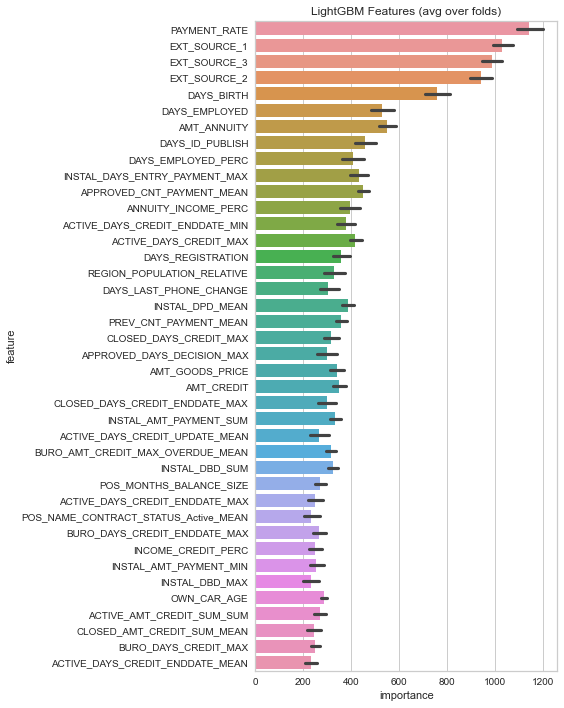

In [7]:
feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= True, debug=False)

Etudions les variables qui sont importantes d'après le modèle du Kaggle.

In [8]:
feat_importance

feature  importance  fold
0                         CODE_GENDER         178     1
1                        FLAG_OWN_CAR           9     1
2                     FLAG_OWN_REALTY          21     1
3                        CNT_CHILDREN          10     1
4                    AMT_INCOME_TOTAL         128     1
..                                ...         ...   ...
790   CC_NAME_CONTRACT_STATUS_nan_MAX           0    10
791  CC_NAME_CONTRACT_STATUS_nan_MEAN           0    10
792   CC_NAME_CONTRACT_STATUS_nan_SUM           0    10
793   CC_NAME_CONTRACT_STATUS_nan_VAR           0    10
794                          CC_COUNT           3    10

[7950 rows x 3 columns]

Nous conservons les 20 premières variables qui ressortent dans le kaggle (via la moyenne de l'importance sur les fold).

In [9]:
cols = feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
best_features = feat_importance.loc[feat_importance.feature.isin(cols)]
#best_features.sort_values(by="importance", ascending=False)

In [10]:
cols

Index(['PAYMENT_RATE', 'EXT_SOURCE_1', 'EXT_SOURCE_3', 'EXT_SOURCE_2',
       'DAYS_BIRTH', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'APPROVED_CNT_PAYMENT_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
       'ACTIVE_DAYS_CREDIT_MAX', 'DAYS_EMPLOYED_PERC', 'ANNUITY_INCOME_PERC',
       'INSTAL_DPD_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'DAYS_REGISTRATION', 'PREV_CNT_PAYMENT_MEAN', 'AMT_CREDIT',
       'AMT_GOODS_PRICE', 'INSTAL_AMT_PAYMENT_SUM'],
      dtype='object', name='feature')

In [11]:
var_importances = best_features.sort_values(by="importance", ascending=False).groupby("feature").mean().sort_values(by="importance", ascending=False)

In [12]:
var_importances=var_importances.reset_index()

Nous ajoutons la variable identifiant et la variable cible

In [13]:
var_importances=var_importances.append({"feature":"TARGET","importance":0,"fold":0}, ignore_index=True)
var_importances=var_importances.append({"feature":"SK_ID_CURR","importance":0,"fold":0}, ignore_index=True)

In [14]:
var_importances

feature  importance  fold
0                     PAYMENT_RATE      1143.2   5.5
1                     EXT_SOURCE_1      1029.4   5.5
2                     EXT_SOURCE_3       990.0   5.5
3                     EXT_SOURCE_2       940.6   5.5
4                       DAYS_BIRTH       758.4   5.5
5                      AMT_ANNUITY       549.1   5.5
6                    DAYS_EMPLOYED       528.9   5.5
7                  DAYS_ID_PUBLISH       457.6   5.5
8        APPROVED_CNT_PAYMENT_MEAN       451.1   5.5
9    INSTAL_DAYS_ENTRY_PAYMENT_MAX       432.9   5.5
10          ACTIVE_DAYS_CREDIT_MAX       418.0   5.5
11              DAYS_EMPLOYED_PERC       406.5   5.5
12             ANNUITY_INCOME_PERC       393.8   5.5
13                 INSTAL_DPD_MEAN       386.2   5.5
14  ACTIVE_DAYS_CREDIT_ENDDATE_MIN       377.4   5.5
15               DAYS_REGISTRATION       358.7   5.5
16           PREV_CNT_PAYMENT_MEAN       358.1   5.5
17                      AMT_CREDIT       348.7   5.5
18                 AMT_GOODS_PRICE       339.9   5.5
19          INSTAL_AMT_PAYMENT_SUM       334.5   5.5
20                          TARGET         0.0   0.0
21                      SK_ID_CURR         0.0   0.0

Explorons ces variables plus en détail.

# Analyse exploratoire des données

In [15]:
df[["EXT_SOURCE_1", 'EXT_SOURCE_2', 'EXT_SOURCE_3']].describe()

EXT_SOURCE_1  EXT_SOURCE_2   EXT_SOURCE_3
count  162343.000000  3.555830e+05  286618.000000
mean        0.501964  5.148892e-01       0.509353
std         0.210046  1.897533e-01       0.194140
min         0.013458  8.173617e-08       0.000527
25%         0.335501  3.949551e-01       0.368969
50%         0.506155  5.648384e-01       0.533482
75%         0.673344  6.629285e-01       0.665855
max         0.962693  8.549997e-01       0.896010

Les variables EXT_SOURCE_1_EXT, EXT_SOURCE_2 et EXT_SOURCE_3 sont des scores. Il est nécessaire de les exclure afin de ne pas biaiser notre modèle. Il faudra modifier le kaggle par la suite.

De plus nous observons que les trois scores semblent donner des résultats similaires.

Calculons des statistiques descriptives sur les 20 premières variables qui ressortent du modèle obtenu avec le kaggle.

In [16]:
df.columns

Index(['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=798)

In [17]:
cols=var_importances[~var_importances.isin(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"])].dropna()

In [18]:
cols=cols.feature


In [19]:
cols

0                       PAYMENT_RATE
4                         DAYS_BIRTH
5                        AMT_ANNUITY
6                      DAYS_EMPLOYED
7                    DAYS_ID_PUBLISH
8          APPROVED_CNT_PAYMENT_MEAN
9      INSTAL_DAYS_ENTRY_PAYMENT_MAX
10            ACTIVE_DAYS_CREDIT_MAX
11                DAYS_EMPLOYED_PERC
12               ANNUITY_INCOME_PERC
13                   INSTAL_DPD_MEAN
14    ACTIVE_DAYS_CREDIT_ENDDATE_MIN
15                 DAYS_REGISTRATION
16             PREV_CNT_PAYMENT_MEAN
17                        AMT_CREDIT
18                   AMT_GOODS_PRICE
19            INSTAL_AMT_PAYMENT_SUM
20                            TARGET
21                        SK_ID_CURR
Name: feature, dtype: object

In [20]:
df.columns

Index(['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=798)

In [21]:
df2=df.loc[:,cols]

In [22]:
df2.describe()

PAYMENT_RATE     DAYS_BIRTH    AMT_ANNUITY  DAYS_EMPLOYED  \
count  356215.000000  356251.000000  356215.000000  291603.000000   
mean        0.055463  -16041.276687   27425.644390   -2396.675703   
std         0.023206    4358.798530   14732.860946    2334.451895   
min         0.022073  -25229.000000    1615.500000  -17912.000000   
25%         0.038080  -19676.000000   16731.000000   -3200.000000   
50%         0.050000  -15755.000000   25078.500000   -1663.000000   
75%         0.067066  -12425.000000   34960.500000    -780.000000   
max         0.124430   -7338.000000  258025.500000       0.000000   

       DAYS_ID_PUBLISH  APPROVED_CNT_PAYMENT_MEAN  \
count    356251.000000              337694.000000   
mean      -3002.070644                  13.581508   
std        1517.905393                   7.513602   
min       -7197.000000                   0.000000   
25%       -4318.000000                   9.000000   
50%       -3252.000000                  12.000000   
75%       -1717.000000                  17.000000   
max           0.000000                  72.000000   

       INSTAL_DAYS_ENTRY_PAYMENT_MAX  ACTIVE_DAYS_CREDIT_MAX  \
count                  339574.000000           251811.000000   
mean                     -328.436694             -419.583279   
std                       537.370145              466.849197   
min                     -3071.000000            -2922.000000   
25%                      -387.000000             -520.000000   
50%                       -65.000000             -264.000000   
75%                       -26.000000             -130.000000   
max                        -1.000000                0.000000   

       DAYS_EMPLOYED_PERC  ANNUITY_INCOME_PERC  INSTAL_DPD_MEAN  \
count       291603.000000        356215.000000    339583.000000   
mean             0.157797             0.181212         1.027074   
std              0.133449             0.094701         8.813887   
min             -0.000000             0.000224         0.000000   
25%              0.056954             0.114950         0.000000   
50%              0.120073             0.163182         0.035714   
75%              0.220597             0.229156         0.500000   
max              0.728811             2.024714      1885.386364   

       ACTIVE_DAYS_CREDIT_ENDDATE_MIN  DAYS_REGISTRATION  \
count                   241342.000000      356251.000000   
mean                      1036.988659       -4983.603036   
std                       4727.357653        3526.966202   
min                     -42056.000000      -24672.000000   
25%                         -6.000000       -7477.000000   
50%                        257.000000       -4502.000000   
75%                        770.000000       -1995.000000   
max                      31198.000000           0.000000   

       PREV_CNT_PAYMENT_MEAN    AMT_CREDIT  AMT_GOODS_PRICE  \
count          338375.000000  3.562510e+05     3.559730e+05   
mean               14.533358  5.877695e+05     5.280212e+05   
std                 8.409069  3.986253e+05     3.660657e+05   
min                 0.000000  4.500000e+04     4.050000e+04   
25%                 9.000000  2.700000e+05     2.340000e+05   
50%                12.000000  5.002110e+05     4.500000e+05   
75%                18.000000  7.975575e+05     6.750000e+05   
max                72.000000  4.050000e+06     4.050000e+06   

       INSTAL_AMT_PAYMENT_SUM        TARGET     SK_ID_CURR  
count            3.395830e+05  307507.00000  356251.000000  
mean             6.904888e+05       0.08073  278128.870078  
std              9.308905e+05       0.27242  102842.068890  
min              0.000000e+00       0.00000  100001.000000  
25%              1.332001e+05       0.00000  189065.500000  
50%              3.248012e+05       0.00000  278129.000000  
75%              8.497309e+05       0.00000  367192.500000  
max              3.268928e+07       1.00000  456255.000000

description

In [23]:
df2.shape

(356251, 19)

In [24]:
df_base=df.copy()

In [25]:
df=df2.copy()

### Commençons par les variables qualitatives

In [26]:
df2.nunique()

PAYMENT_RATE                       43678
DAYS_BIRTH                         17467
AMT_ANNUITY                        14166
DAYS_EMPLOYED                      12895
DAYS_ID_PUBLISH                     6224
APPROVED_CNT_PAYMENT_MEAN           1392
INSTAL_DAYS_ENTRY_PAYMENT_MAX       2939
ACTIVE_DAYS_CREDIT_MAX              2911
DAYS_EMPLOYED_PERC                288265
ANNUITY_INCOME_PERC                98315
INSTAL_DPD_MEAN                    25376
ACTIVE_DAYS_CREDIT_ENDDATE_MIN      9630
DAYS_REGISTRATION                  15898
PREV_CNT_PAYMENT_MEAN               3000
AMT_CREDIT                          6480
AMT_GOODS_PRICE                     1291
INSTAL_AMT_PAYMENT_SUM            334852
TARGET                                 2
SK_ID_CURR                        356251
dtype: int64

Nous avons uniquement la variable cible qui est qualitative. Les variables importantes qui ressortent du light gradient boosting sont quantitatives.

Regardons la variable cible

(None,)

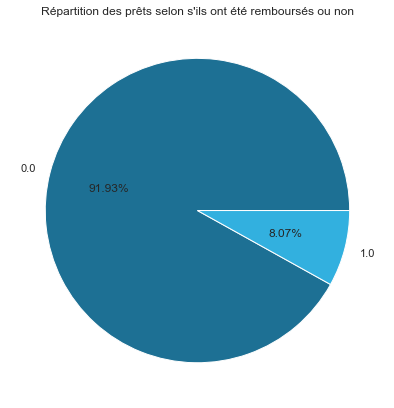

In [678]:
pk.graph_pie(df["TARGET"], "TARGET", "Répartition des prêts selon s'ils ont été remboursés ou non",["#1D7094", "#32B0DF"], (15,7)),

Nous observons un déséquilibre. Il faudra prendre en compte cette information lors de l'élaboration du modèle.

La plupart des prêts ont été remboursés.

In [687]:
def graph_barplot_by_group(data, column, group, color_i, title_i): 
    """
    Tracer  un diagramme en barred'une variable en fonction d'une autre
    
    Args:
        data ([type]): données 
        column ([type]): colonne à analyser 
        group ([type]): colonne groupe 
        color_i ([type]): couleur
        title_i ([type]): titre du graphique
    
    Exemple:
     graph_barplot_by_group(data, 'reg_additives', 'group', '#6D8260', 'Répartition des aliments en fonction des additifs contenus et du nutrition grade')
     
    """
    grouped = data.groupby([group], sort=False)
    reg_carbohydrates_counts = grouped[column].value_counts(normalize=True, sort=False)

    occupation_data = [
        {'reg': column, 'group': group, 'percentage': percentage*100} for 
        (group, column), percentage in dict(reg_carbohydrates_counts).items()
    ]

    df_occupation = pd.DataFrame(occupation_data)

    p = sns.barplot(x="reg", y="percentage", hue="group", data=df_occupation)
    
    p.set(xlabel='Intervalle - '+str(column), ylabel='Fréquences - %', title=title_i)
    _ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels

In [691]:
for i in df.columns:
    print(i)

PAYMENT_RATE
DAYS_BIRTH
AMT_ANNUITY
DAYS_EMPLOYED
DAYS_ID_PUBLISH
APPROVED_CNT_PAYMENT_MEAN
INSTAL_DAYS_ENTRY_PAYMENT_MAX
ACTIVE_DAYS_CREDIT_MAX
DAYS_EMPLOYED_PERC
ANNUITY_INCOME_PERC
INSTAL_DPD_MEAN
ACTIVE_DAYS_CREDIT_ENDDATE_MIN
DAYS_REGISTRATION
PREV_CNT_PAYMENT_MEAN
AMT_CREDIT
AMT_GOODS_PRICE
INSTAL_AMT_PAYMENT_SUM
TARGET
SK_ID_CURR


Regardons s'il y a des valeurs isolées.

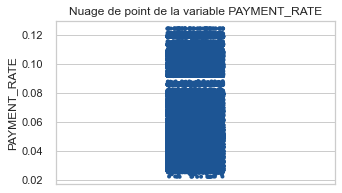

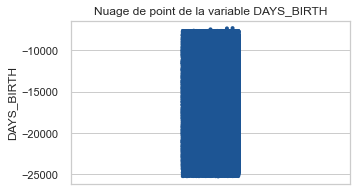

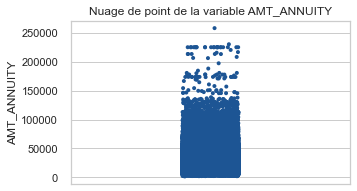

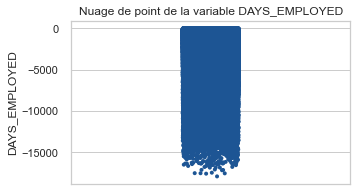

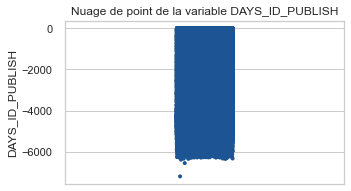

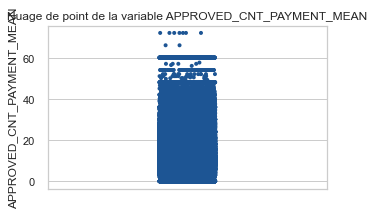

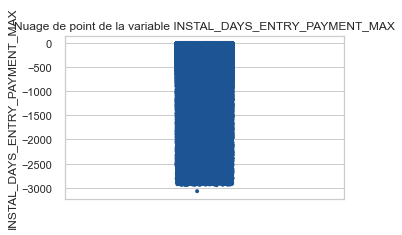

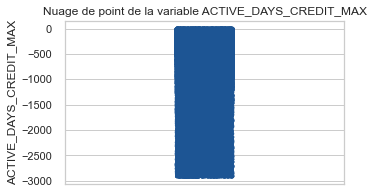

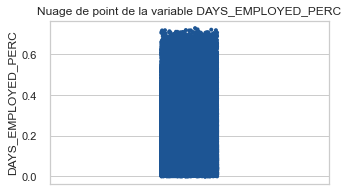

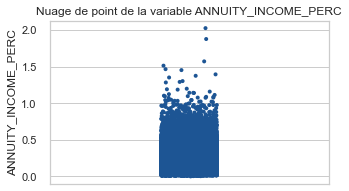

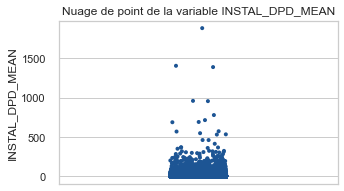

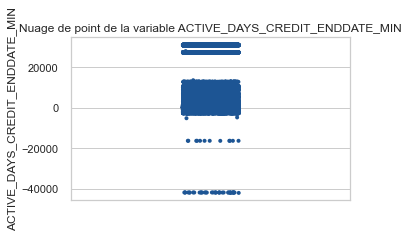

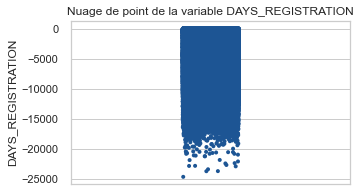

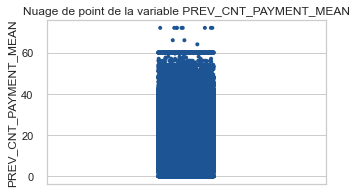

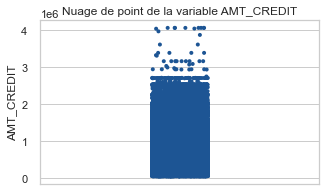

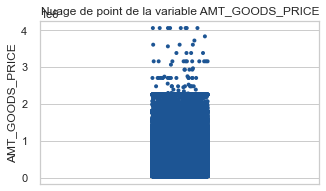

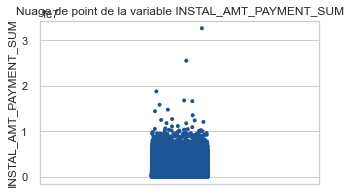

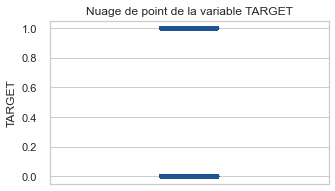

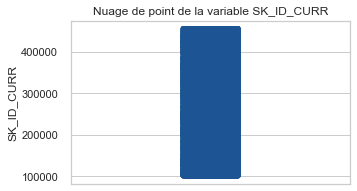

In [712]:
for i in cols:
    pk.graph_stripplot(df,i, "Nuage de point de la variable "+str(i),(5,3), "#1D5594")

Nous observons des valeurs isolées pour certaines variables comme AMT_ANNUITY et DAYS_REGISTRATION, mais cela peut être dû aux fraudeurs qui ont un comportement particulier.

Vérifions si les distributions suivent la loi normale

Pour rappel, les hypothèses du test de la loi normale sont :

- h0 = la distribution est normale. (p-value > 0.05)
- h1 = la distribution n'est pas normale. (p-value < 0.05)

In [29]:
df

PAYMENT_RATE  DAYS_EMPLOYED_PERC  DAYS_ID_PUBLISH  DAYS_BIRTH  \
8769       0.078997            0.174876            -1537      -10882   
1800       0.048351            0.024054            -4346      -13345   
9614       0.053442            0.142905            -2294      -11819   
5666       0.071024                 NaN            -1304      -24820   
5516       0.042540            0.012282            -4467      -16365   
...             ...                 ...              ...         ...   
14434      0.051275            0.063860            -4501      -11807   
19707      0.074768            0.355736            -4306      -23093   
13181      0.064042            0.073462            -4472      -12823   
15892      0.037840            0.221409             -773      -17226   
17023      0.077641            0.222573            -1863       -9188   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_EMPLOYED  \
8769          238500.0                    0.008230        -1903.0   
1800          472500.0                    0.018634         -321.0   
9614          679500.0                    0.032561        -1689.0   
5666           81000.0                    0.007020            NaN   
5516          675000.0                    0.031329         -201.0   
...                ...                         ...            ...   
14434         589500.0                    0.015221         -754.0   
19707         270000.0                    0.010006        -8215.0   
13181         900000.0                    0.046220         -942.0   
15892         675000.0                    0.046220        -3814.0   
17023         454500.0                    0.018634        -2045.0   

       AMT_ANNUITY  DAYS_REGISTRATION  ANNUITY_INCOME_PERC  \
8769       20830.5            -4630.0             0.092580   
1800       25560.0            -5835.0             0.142000   
9614       42066.0            -5513.0             0.267086   
5666        6322.5            -4208.0             0.056200   
5516       32125.5            -9003.0             0.356950   
...            ...                ...                  ...   
14434      30226.5            -1715.0             0.248778   
19707      22585.5            -1022.0             0.143400   
13181      62964.0            -1481.0             0.279840   
15892      34308.0            -3687.0             0.127067   
17023      39829.5            -8639.0             0.221275   

       DAYS_LAST_PHONE_CHANGE  INCOME_CREDIT_PERC  AMT_CREDIT  \
8769                  -1250.0            0.853286    263686.5   
1800                  -1187.0            0.340501    528633.0   
9614                  -2327.0            0.200094    787131.0   
5666                  -2315.0            1.263775     89019.0   
5516                    -24.0            0.119175    755190.0   
...                       ...                 ...         ...   
14434                 -1921.0            0.206107    589500.0   
19707                  -523.0            0.521392    302076.0   
13181                     0.0            0.228854    983160.0   
15892                 -1055.0            0.297796    906660.0   
17023                  -226.0            0.350880    512995.5   

       HOUR_APPR_PROCESS_START  INCOME_PER_PERSON  \
8769                        10           112500.0   
1800                        11           180000.0   
9614                        12            78750.0   
5666                        10           112500.0   
5516                        13            90000.0   
...                        ...                ...   
14434                        9            40500.0   
19707                       14           157500.0   
13181                       14            56250.0   
15892                       17           135000.0   
17023                       17           180000.0   

       NAME_EDUCATION_TYPE_Higher_education  AMT_REQ_CREDIT_BUREAU_YEAR  \
8769                                      1                         2.0   


In [30]:
df.select_dtypes(include=['float64']).columns

Index(['PAYMENT_RATE', 'DAYS_EMPLOYED_PERC', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'AMT_ANNUITY',
       'DAYS_REGISTRATION', 'ANNUITY_INCOME_PERC', 'DAYS_LAST_PHONE_CHANGE',
       'INCOME_CREDIT_PERC', 'AMT_CREDIT', 'INCOME_PER_PERSON',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'TARGET'],
      dtype='object')

In [31]:
for col in df.select_dtypes(include=['float64']).columns:
    print(col)
    data_i=df[col].loc[pd.isna(df[col])==False]
    if data_i.nunique()>8:
        k, p = scipy.stats.normaltest(data_i)
        print(scipy.stats.normaltest(data_i))
        if p>0.05:
            print("Variable : "+col+" ----- "+ str(scipy.stats.normaltest(data_i)))
        else:
            print("Variable ne suit pas une loi normale : "+col+" ----- "+ str(scipy.stats.normaltest(data_i)))
    

PAYMENT_RATE
NormaltestResult(statistic=1280.6359922619367, pvalue=8.192710654654585e-279)
Variable ne suit pas une loi normale : PAYMENT_RATE ----- NormaltestResult(statistic=1280.6359922619367, pvalue=8.192710654654585e-279)
DAYS_EMPLOYED_PERC
NormaltestResult(statistic=1732.995324778092, pvalue=0.0)
Variable ne suit pas une loi normale : DAYS_EMPLOYED_PERC ----- NormaltestResult(statistic=1732.995324778092, pvalue=0.0)
AMT_GOODS_PRICE
NormaltestResult(statistic=2365.4938691761654, pvalue=0.0)
Variable ne suit pas une loi normale : AMT_GOODS_PRICE ----- NormaltestResult(statistic=2365.4938691761654, pvalue=0.0)
REGION_POPULATION_RELATIVE
NormaltestResult(statistic=2816.0896936495824, pvalue=0.0)
Variable ne suit pas une loi normale : REGION_POPULATION_RELATIVE ----- NormaltestResult(statistic=2816.0896936495824, pvalue=0.0)
DAYS_EMPLOYED
NormaltestResult(statistic=3088.498062978996, pvalue=0.0)
Variable ne suit pas une loi normale : DAYS_EMPLOYED ----- NormaltestResult(statistic=3088

Il y a des variables qui ont été créées qui suivent une loi normale avec un seuil de significativité à 0.05. Les variables initiales ne suivent pas une loi normale avec un seuil de significativité à 0.05.


Comparons la cible avec les 20 premières variables qui ressortent du modèle light Gradient boosting. Traçons des boites à moustache.

moyenne PAYMENT_RATE = 0.05546335671282615
moyenne DAYS_BIRTH = -16041.276686942632
moyenne AMT_ANNUITY = 27425.644390326066
moyenne DAYS_EMPLOYED = -2396.675702924867
moyenne DAYS_ID_PUBLISH = -3002.070644012227
moyenne APPROVED_CNT_PAYMENT_MEAN = 13.581507579057464
moyenne INSTAL_DAYS_ENTRY_PAYMENT_MAX = -328.436694210982
moyenne ACTIVE_DAYS_CREDIT_MAX = -419.58327872888793
moyenne DAYS_EMPLOYED_PERC = 0.15779704262134678
moyenne ANNUITY_INCOME_PERC = 0.1812117171988731
moyenne INSTAL_DPD_MEAN = 1.0270744319712484
moyenne ACTIVE_DAYS_CREDIT_ENDDATE_MIN = 1036.9886592470436
moyenne DAYS_REGISTRATION = -4983.6030356172105
moyenne PREV_CNT_PAYMENT_MEAN = 14.533357576533007
moyenne AMT_CREDIT = 587769.5290300939
moyenne AMT_GOODS_PRICE = 528021.1905313043
moyenne INSTAL_AMT_PAYMENT_SUM = 690488.7819870107
moyenne TARGET = 0.08072986956394489
moyenne SK_ID_CURR = 278128.8700775577


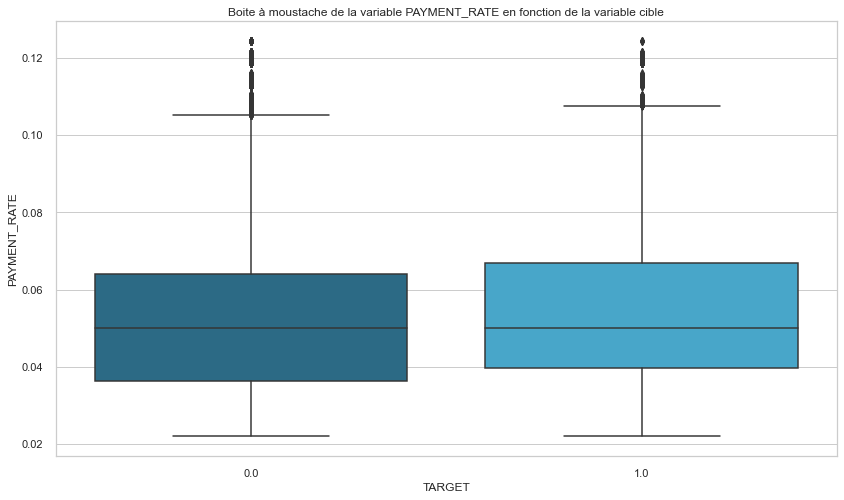

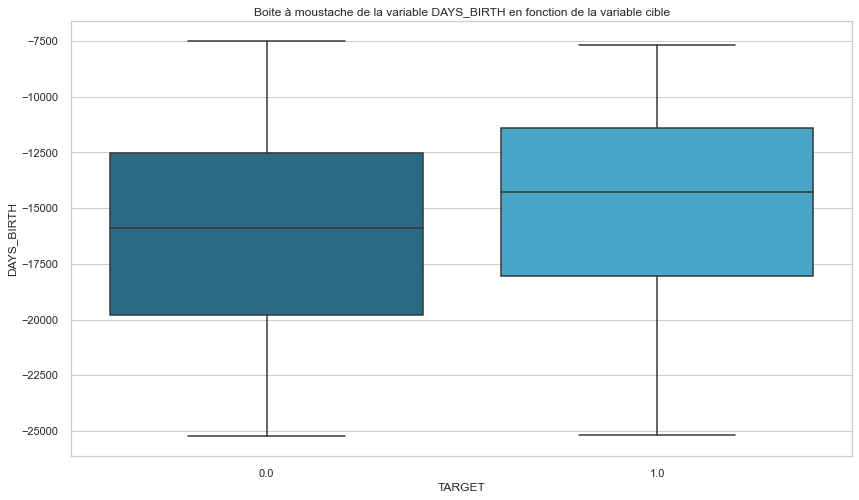

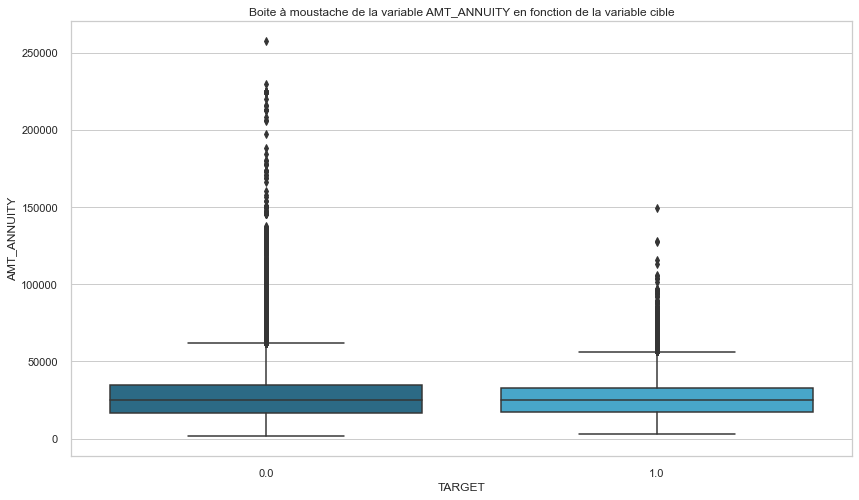

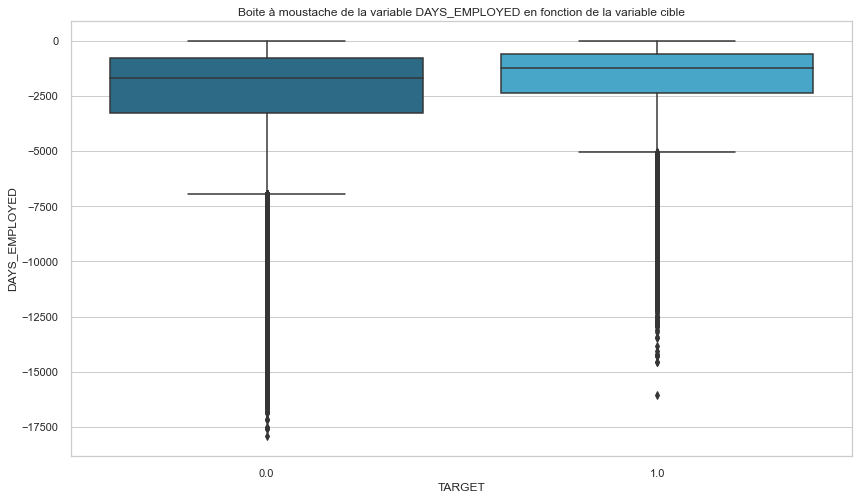

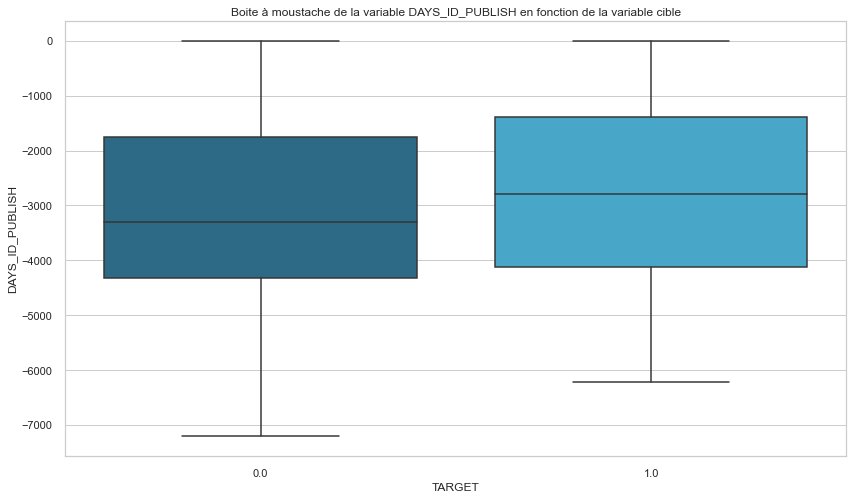

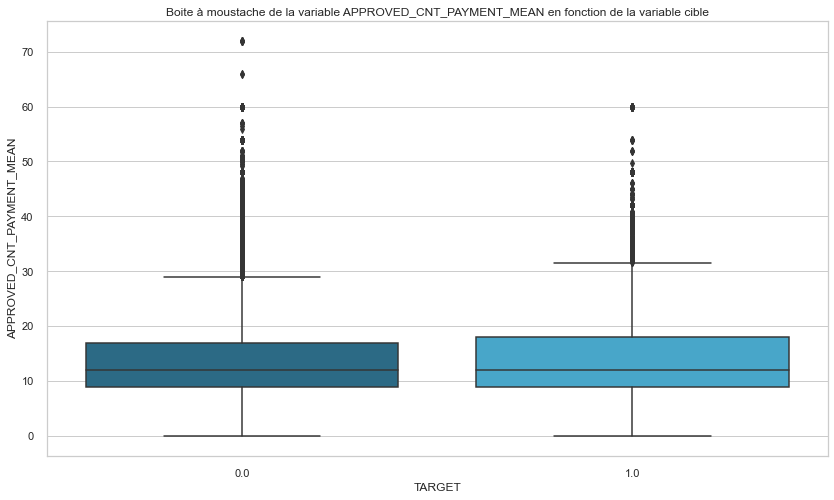

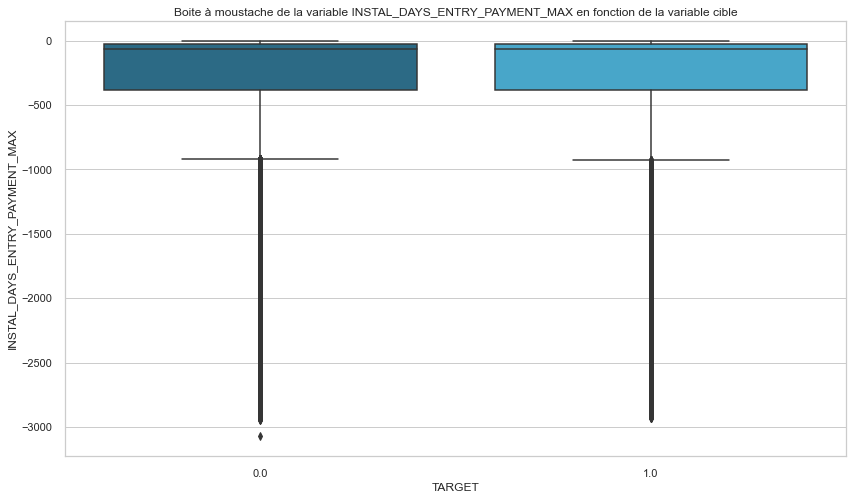

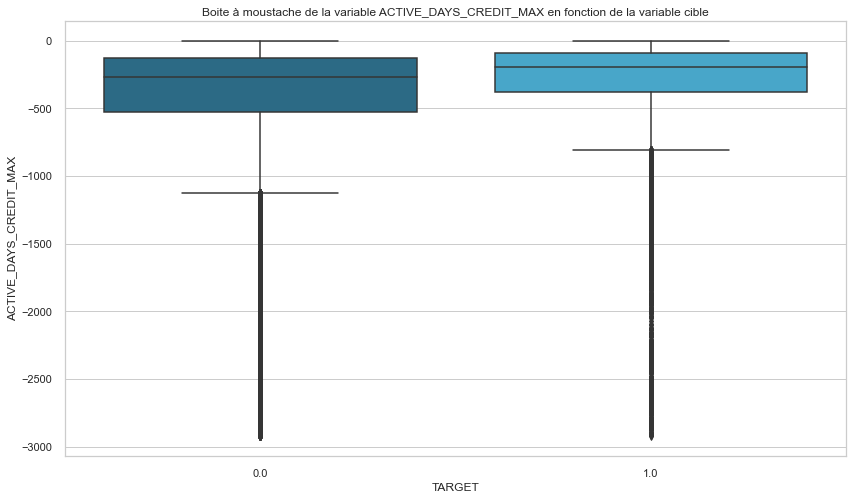

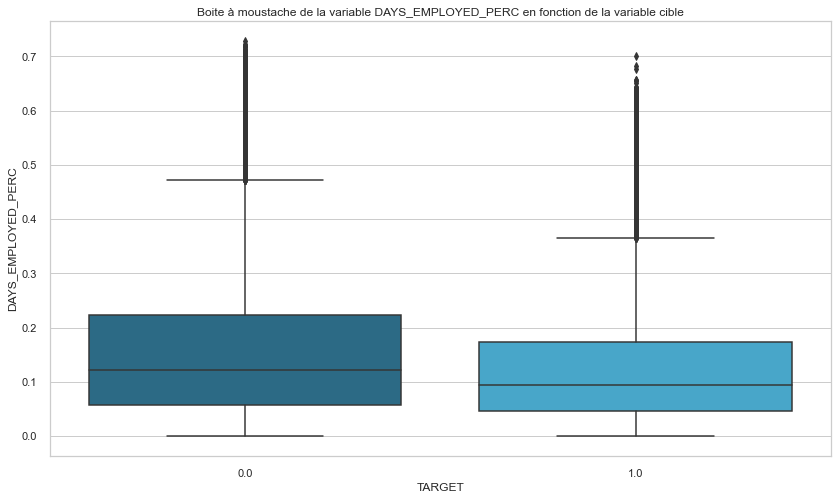

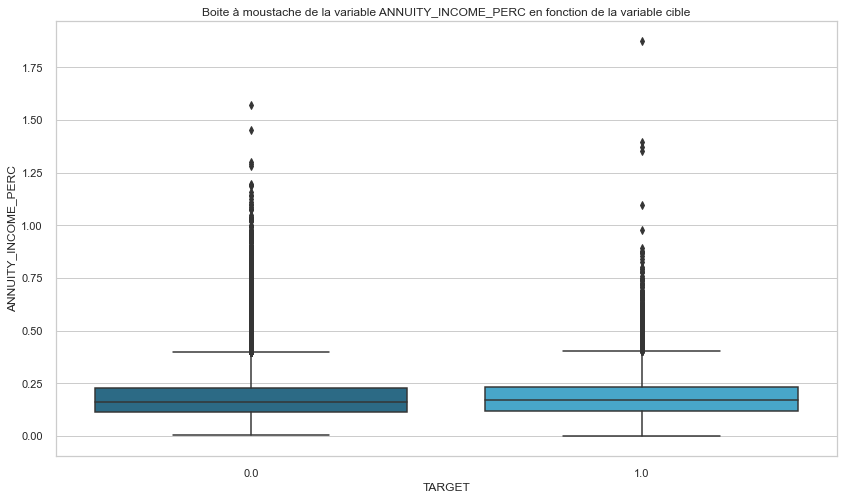

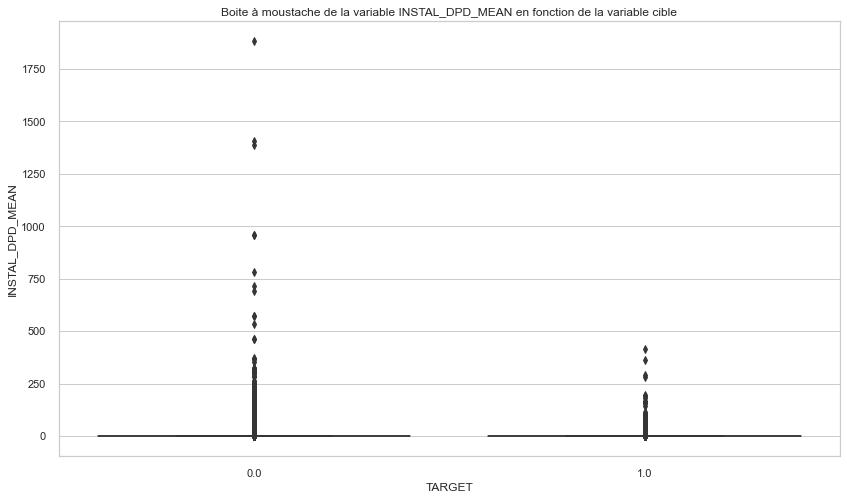

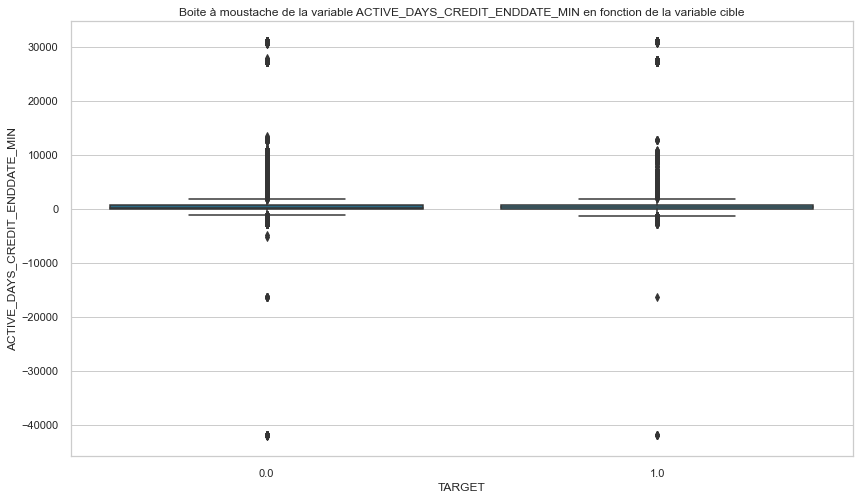

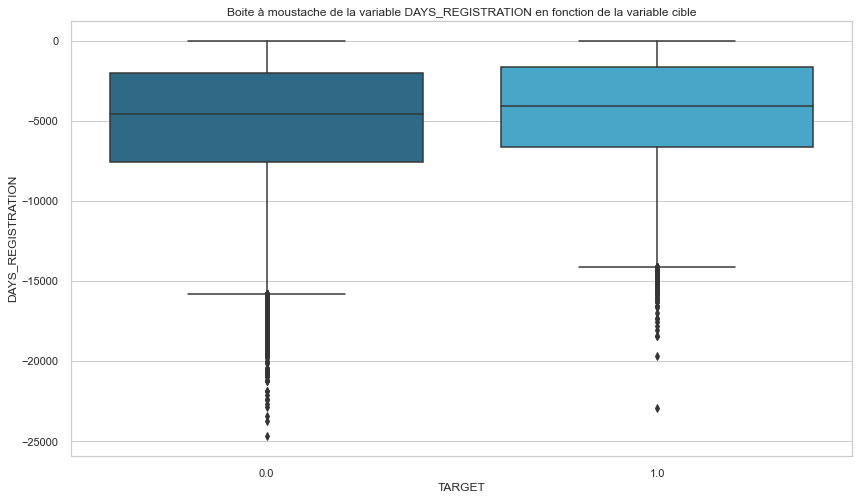

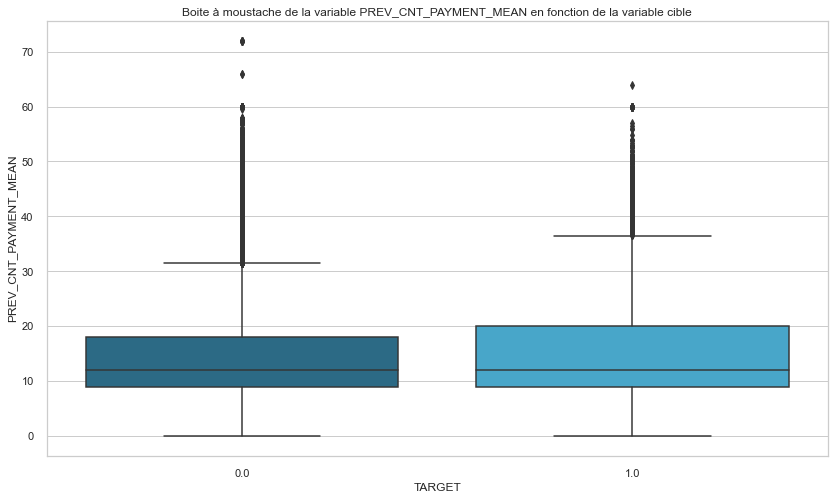

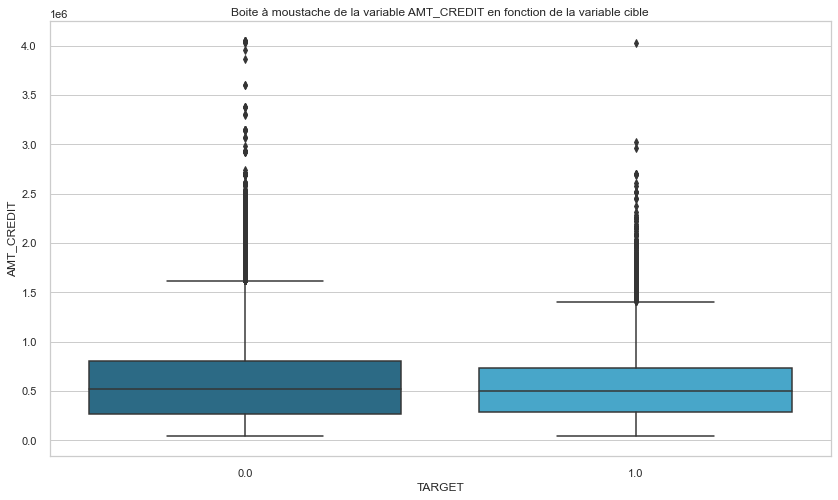

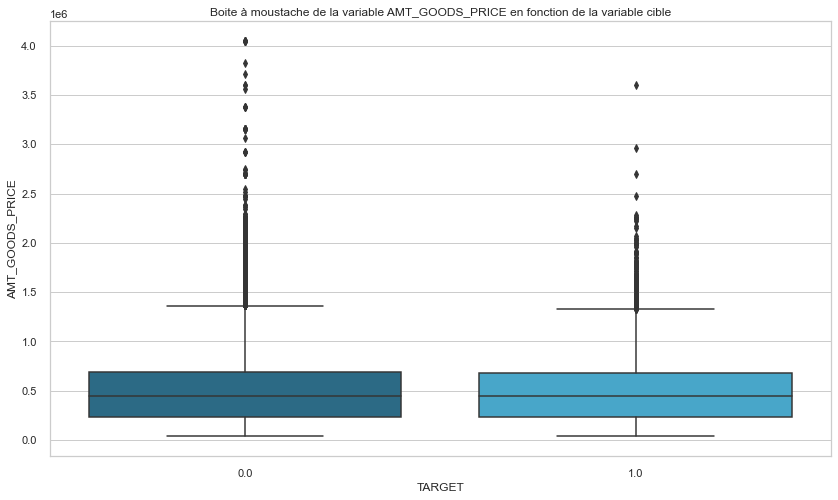

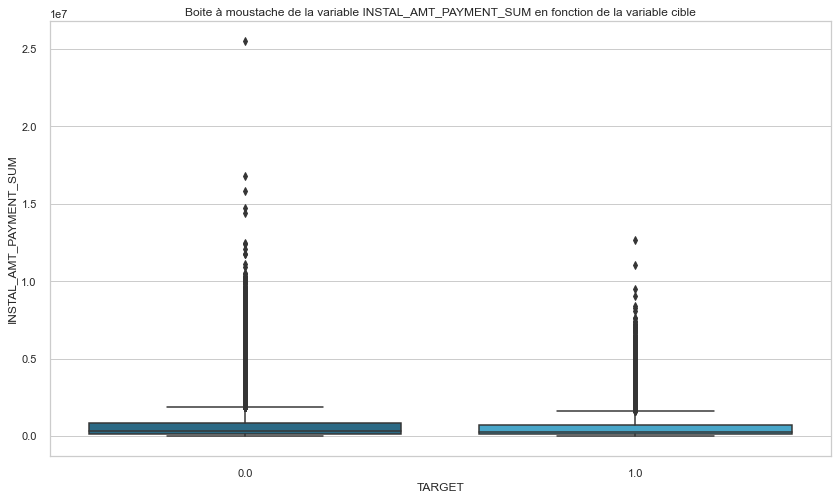

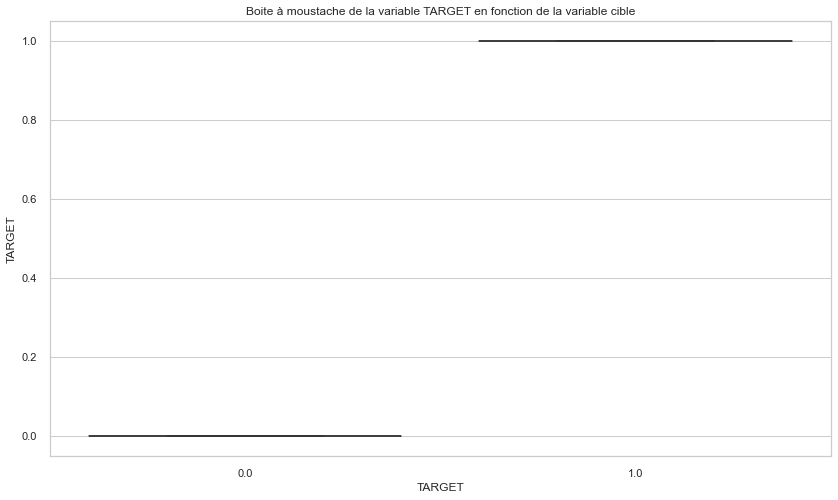

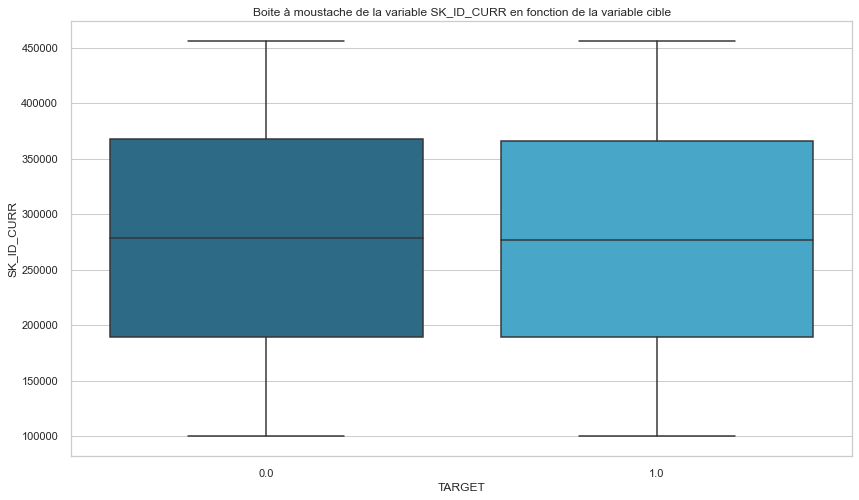

In [713]:
for col in cols:
    print("moyenne "+col +" = "+str(df[col].mean()))
    pk.graph_boxplot_by_group(df, col,"TARGET", "Boite à moustache de la variable "+col+" en fonction de la variable cible", ["#1D7094", "#32B0DF"], (14,8))

Nous pouvons comparer grâce à ces boites à moustache nos deux cibles. 

Si nous opposons les deux populations, nous observons que les prêts non remboursés sont caractérisés par des emprunteurs : 
- avec une carte d'identité plus ancienne, en moyenne 7 ans environs
- qui sont employés depuis plus longtemps
- qui sont plus jeunes
- dont le dernier changement au telephone a eu lieu, plus longtemps avant que les clients ayant remboursé leur prêt
- ayant des annuités de prêts qui vont dans les extrêmes
- ayant un niveau d'études plus faible

Calculons quelques statistiques.

In [33]:
df.describe()

PAYMENT_RATE  DAYS_EMPLOYED_PERC  DAYS_ID_PUBLISH    DAYS_BIRTH  \
count   9998.000000         8217.000000      9999.000000   9999.000000   
mean       0.055332            0.158302     -2996.001600 -16025.235224   
std        0.023147            0.135019      1519.693862   4338.282442   
min        0.025264            0.000917     -6236.000000 -25160.000000   
25%        0.038088            0.056998     -4311.500000 -19639.000000   
50%        0.050000            0.119807     -3236.000000 -15745.000000   
75%        0.066821            0.221162     -1720.000000 -12383.500000   
max        0.124417            0.719382         0.000000  -7705.000000   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_EMPLOYED  \
count     9.994000e+03                 9999.000000    8217.000000   
mean      5.281908e+05                    0.021036   -2408.631252   
std       3.656360e+05                    0.013886    2345.627780   
min       4.500000e+04                    0.000938  -17463.000000   
25%       2.340000e+05                    0.010032   -3218.000000   
50%       4.500000e+05                    0.018850   -1661.000000   
75%       6.750000e+05                    0.028663    -776.000000   
max       2.961000e+06                    0.072508     -17.000000   

         AMT_ANNUITY  DAYS_REGISTRATION  ANNUITY_INCOME_PERC  \
count    9998.000000        9999.000000          9998.000000   
mean    27406.190938       -5014.665167             0.181294   
std     14668.911296        3552.408111             0.095953   
min      2596.500000      -22842.000000             0.005444   
25%     16686.000000       -7545.500000             0.115585   
50%     25128.000000       -4509.000000             0.162400   
75%     34938.000000       -2021.000000             0.227293   
max    173574.000000           0.000000             1.373917   

       DAYS_LAST_PHONE_CHANGE  INCOME_CREDIT_PERC    AMT_CREDIT  \
count             9999.000000         9999.000000  9.999000e+03   
mean              -977.495650            0.410209  5.876576e+05   
std                838.871422            0.346472  3.978816e+05   
min              -3882.000000            0.028640  4.500000e+04   
25%              -1583.000000            0.200000  2.700000e+05   
50%               -763.000000            0.316456  4.975200e+05   
75%               -273.000000            0.500000  7.975575e+05   
max                  0.000000            7.178631  2.961000e+06   

       HOUR_APPR_PROCESS_START  INCOME_PER_PERSON  \
count              9999.000000       9.999000e+03   
mean                 12.058706       9.308533e+04   
std                   3.219585       6.947933e+04   
min                   1.000000       7.500000e+03   
25%                  10.000000       4.950000e+04   
50%                  12.000000       7.650000e+04   
75%                  14.000000       1.125000e+05   
max                  23.000000       1.125000e+06   

       NAME_EDUCATION_TYPE_Higher_education  AMT_REQ_CREDIT_BUREAU_YEAR  \
count                           9999.000000                 8627.000000   
mean                               0.245225                    1.896024   
std                                0.430242                    1.850979   
min                                0.000000                    0.000000   
25%                                0.000000                    0.000000   
50%                                0.000000                    1.000000   
75%                                0.000000                    3.000000   
max                                1.000000                   13.000000   

            TARGET     SK_ID_CURR  
count  8599.000000    9999.000000  
mean      0.080707  110095.248325  
std       0.272401   13497.769922  
min       0.000000  100001.000000  
25%       0.000000  103306.500000  
50%       0.000000  106659.000000  
75%       0.000000  109920.500000  
max       1.000000  172570.000000

Maintenant que nous connaissons mieux notre jeu de données, nous pouvons vérifier les corrélations entre les variables de notre jeu de données en entier.

In [717]:
df=df_base.copy()

## Analyse bivariée

Regardons s'il y a des variables corrélées.

### Matrice de corrélation

index  SK_ID_CURR    TARGET  CODE_GENDER  \
index                             1.000000    0.837311 -0.002114    -0.003517   
SK_ID_CURR                        0.837311    1.000000 -0.002111     0.000752   
TARGET                           -0.002114   -0.002111  1.000000    -0.054710   
CODE_GENDER                      -0.003517    0.000752 -0.054710     1.000000   
FLAG_OWN_CAR                      0.002091    0.001551 -0.021850    -0.343445   
...                                    ...         ...       ...          ...   
CC_NAME_CONTRACT_STATUS_nan_MAX        NaN         NaN       NaN          NaN   
CC_NAME_CONTRACT_STATUS_nan_MEAN       NaN         NaN       NaN          NaN   
CC_NAME_CONTRACT_STATUS_nan_SUM        NaN         NaN       NaN          NaN   
CC_NAME_CONTRACT_STATUS_nan_VAR        NaN         NaN       NaN          NaN   
CC_COUNT                          0.000421   -0.000617 -0.060481     0.000054   

                                  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
index                                 0.002091        -0.001558      0.003617   
SK_ID_CURR                            0.001551         0.000336     -0.000870   
TARGET                               -0.021850         0.006146      0.019189   
CODE_GENDER                          -0.343445        -0.041584     -0.048264   
FLAG_OWN_CAR                          1.000000         0.002095      0.103048   
...                                        ...              ...           ...   
CC_NAME_CONTRACT_STATUS_nan_MAX            NaN              NaN           NaN   
CC_NAME_CONTRACT_STATUS_nan_MEAN           NaN              NaN           NaN   
CC_NAME_CONTRACT_STATUS_nan_SUM            NaN              NaN           NaN   
CC_NAME_CONTRACT_STATUS_nan_VAR            NaN              NaN           NaN   
CC_COUNT                              0.041347         0.050258     -0.036946   

                                  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
index                                    -0.008583    0.033421    -0.025803   
SK_ID_CURR                               -0.001606    0.000417     0.000623   
TARGET                                   -0.003982   -0.030371    -0.012818   
CODE_GENDER                              -0.078534   -0.016903    -0.076724   
FLAG_OWN_CAR                              0.089026    0.116993     0.143514   
...                                            ...         ...          ...   
CC_NAME_CONTRACT_STATUS_nan_MAX                NaN         NaN          NaN   
CC_NAME_CONTRACT_STATUS_nan_MEAN               NaN         NaN          NaN   
CC_NAME_CONTRACT_STATUS_nan_SUM                NaN         NaN          NaN   
CC_NAME_CONTRACT_STATUS_nan_VAR                NaN         NaN          NaN   
CC_COUNT                                  0.041567    0.131704     0.090125   

                                  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
index                             ...                            0.004458   
SK_ID_CURR                        ...                           -0.005560   
TARGET                            ...                           -0.008871   
CODE_GENDER                       ...                            0.003723   
FLAG_OWN_CAR                      ...                            0.003321   
...                               ...                                 ...   
CC_NAME_CONTRACT_STATUS_nan_MAX   ...                                 NaN   
CC_NAME_CONTRACT_STATUS_nan_MEAN  ...                                 NaN   
CC_NAME_CONTRACT_STATUS_nan_SUM   ...                                 NaN   
CC_NAME_CONTRACT_STATUS_nan_VAR   ...                                 NaN   
CC_COUNT                          ...                            0.080625   

                                  CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
index                                                        0.000784   
SK_ID_CURR                                                  -0.006409  

Text(62.95312499999997, 0.5, 'Variables')

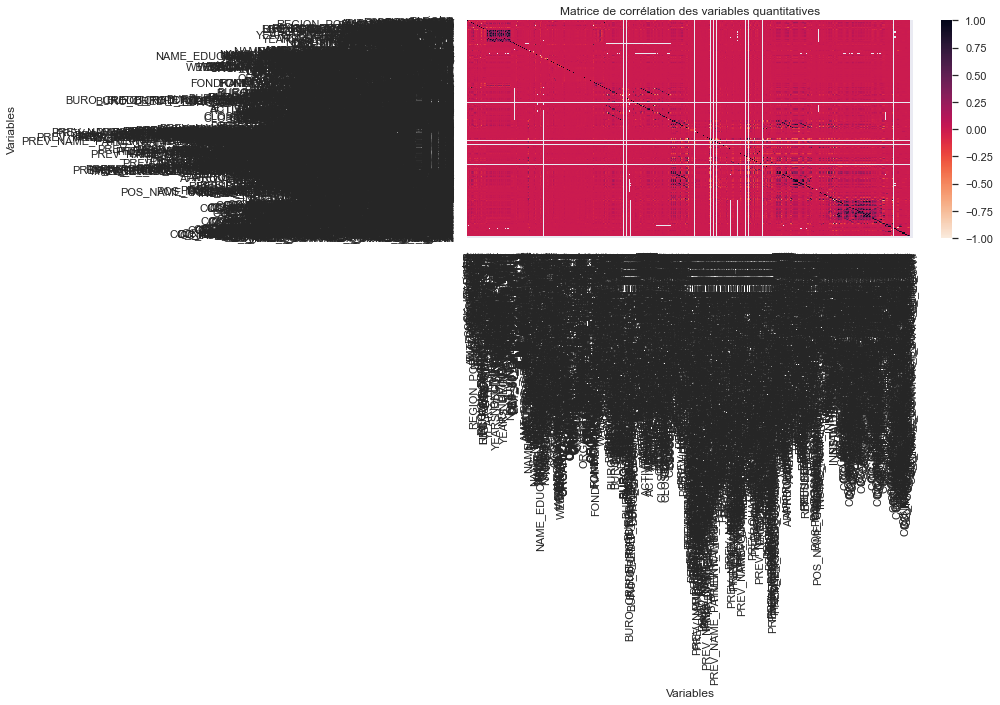

In [722]:
sns.set(rc={'figure.figsize':(10,4)})

data_corr = df.corr()

display(data_corr)
ax = sns.heatmap(data_corr, xticklabels = data_corr.columns , 
                 yticklabels = data_corr.columns, cmap = 'rocket_r')
plt.title("Matrice de corrélation des variables quantitatives")

plt.xlabel("Variables")

plt.ylabel("Variables")

Grâce au tableau, nous observons des corrélations entre les variables crées et les variables dont dépendantes ces dernières.

In [35]:
cols

2                             PAYMENT_RATE
4                       DAYS_EMPLOYED_PERC
5                          DAYS_ID_PUBLISH
6                               DAYS_BIRTH
7                          AMT_GOODS_PRICE
8               REGION_POPULATION_RELATIVE
9                            DAYS_EMPLOYED
10                             AMT_ANNUITY
11                       DAYS_REGISTRATION
12                     ANNUITY_INCOME_PERC
13                  DAYS_LAST_PHONE_CHANGE
14                      INCOME_CREDIT_PERC
15                              AMT_CREDIT
16                 HOUR_APPR_PROCESS_START
17                       INCOME_PER_PERSON
18    NAME_EDUCATION_TYPE_Higher_education
19              AMT_REQ_CREDIT_BUREAU_YEAR
20                                  TARGET
21                              SK_ID_CURR
Name: feature, dtype: object

Regardons les corrélations entre les 20 premières variables du LGB.

In [719]:
import plotly.express as px

data_corr_lgb = df[cols].corr()
fig = px.imshow(data_corr_lgb, width=1000, height=1200)
fig.show()

Ressortons les variables qui sont corrélées grâce à une boucle. Nous disposons d'un grand nombre de variable, il est donc assez difficile d'avoir une idée précise des variables corrélées avec les graphiques ou le tableau de données.

In [721]:
correlations=data_corr.reset_index()

(356251, 798)

In [723]:
j=0
for i in correlations.columns:
    if j in range(0,len(correlations)-1):
        if i!="index":
            if (i!=correlations["index"][j])==True & (correlations[i] is not None)==True:
                if abs(correlations[i][j])>0.5:
                    print("var correle : "+i+" - "+correlations["index"][j] + "- value : "+str(correlations[i][j]))
        j+=1
    else:
        break
    

PAYMENT_RATE    1.0
Name: PAYMENT_RATE, dtype: float64

DAYS_BIRTH        1.000000
FLAG_EMP_PHONE    0.622764
Name: DAYS_BIRTH, dtype: float64

AMT_CREDIT         0.762520
AMT_ANNUITY        1.000000
AMT_GOODS_PRICE    0.768123
Name: AMT_ANNUITY, dtype: float64

DAYS_EMPLOYED    1.0
Name: DAYS_EMPLOYED, dtype: float64

DAYS_ID_PUBLISH    1.0
Name: DAYS_ID_PUBLISH, dtype: float64

PREV_CNT_PAYMENT_MEAN            0.838434
APPROVED_AMT_APPLICATION_MAX     0.500142
APPROVED_AMT_APPLICATION_MEAN    0.591132
APPROVED_AMT_CREDIT_MAX          0.504680
APPROVED_AMT_CREDIT_MEAN         0.602683
APPROVED_AMT_GOODS_PRICE_MEAN    0.577773
APPROVED_CNT_PAYMENT_MEAN        1.000000
APPROVED_CNT_PAYMENT_SUM         0.563873
Name: APPROVED_CNT_PAYMENT_MEAN, dtype: float64

PREV_DAYS_DECISION_MAX            0.705698
PREV_DAYS_DECISION_MEAN           0.572798
APPROVED_DAYS_DECISION_MAX        0.799321
APPROVED_DAYS_DECISION_MEAN       0.591027
POS_MONTHS_BALANCE_MAX            0.862677
POS_MONTHS_BALANCE_MEAN           0.605522
INSTAL_DAYS_ENTRY_PAYMENT_MAX     1.000000
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0.665208
Name: INSTAL_DAYS_ENTRY_PAYMENT_MAX, dtype: float64

BURO_DAYS_CREDIT_MAX       0.859700
BURO_DAYS_CREDIT_MEAN      0.523695
ACTIVE_DAYS_CREDIT_MAX     1.000000
ACTIVE_DAYS_CREDIT_MEAN    0.811757
Name: ACTIVE_DAYS_CREDIT_MAX, dtype: float64

DAYS_EMPLOYED_PERC    1.0
Name: DAYS_EMPLOYED_PERC, dtype: float64

ANNUITY_INCOME_PERC    1.0
Name: ANNUITY_INCOME_PERC, dtype: float64

INSTAL_DPD_MAX     0.637786
INSTAL_DPD_MEAN    1.000000
INSTAL_DPD_SUM     0.603119
Name: INSTAL_DPD_MEAN, dtype: float64

BURO_DAYS_CREDIT_ENDDATE_MEAN      0.624506
ACTIVE_DAYS_CREDIT_ENDDATE_MIN     1.000000
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN    0.794749
Name: ACTIVE_DAYS_CREDIT_ENDDATE_MIN, dtype: float64

DAYS_REGISTRATION    1.0
Name: DAYS_REGISTRATION, dtype: float64

PREV_AMT_APPLICATION_MAX                   0.560541
PREV_AMT_APPLICATION_MEAN                  0.586763
PREV_AMT_CREDIT_MAX                        0.567815
PREV_AMT_CREDIT_MEAN                       0.598954
PREV_AMT_GOODS_PRICE_MAX                   0.559308
PREV_AMT_GOODS_PRICE_MEAN                  0.635517
PREV_CNT_PAYMENT_MEAN                      1.000000
PREV_CNT_PAYMENT_SUM                       0.606066
PREV_NAME_CONTRACT_TYPE_Cash_loans_MEAN    0.549016
PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN       0.501997
PREV_NAME_PORTFOLIO_Cash_MEAN              0.520482
APPROVED_AMT_APPLICATION_MEAN              0.513935
APPROVED_AMT_CREDIT_MEAN                   0.528881
APPROVED_AMT_GOODS_PRICE_MEAN              0.506713
APPROVED_CNT_PAYMENT_MEAN                  0.838434
REFUSED_AMT_APPLICATION_MAX                0.562960
REFUSED_AMT_APPLICATION_MEAN               0.556751
REFUSED_AMT_CREDIT_MAX                     0.570826
REFUSED_AMT_CREDIT_MEAN                    0.564877
REFUSED_AMT_

AMT_CREDIT         1.000000
AMT_ANNUITY        0.762520
AMT_GOODS_PRICE    0.987161
Name: AMT_CREDIT, dtype: float64

AMT_CREDIT         0.987161
AMT_ANNUITY        0.768123
AMT_GOODS_PRICE    1.000000
Name: AMT_GOODS_PRICE, dtype: float64

PREV_AMT_ANNUITY_MAX                0.653497
PREV_AMT_ANNUITY_MEAN               0.509887
PREV_AMT_APPLICATION_MAX            0.670469
PREV_AMT_APPLICATION_MEAN           0.524639
PREV_AMT_CREDIT_MAX                 0.676486
PREV_AMT_CREDIT_MEAN                0.560166
PREV_AMT_GOODS_PRICE_MAX            0.671013
PREV_AMT_GOODS_PRICE_MEAN           0.568291
PREV_CNT_PAYMENT_SUM                0.548850
APPROVED_AMT_ANNUITY_MAX            0.700506
APPROVED_AMT_ANNUITY_MEAN           0.527834
APPROVED_AMT_APPLICATION_MAX        0.767281
APPROVED_AMT_APPLICATION_MEAN       0.603398
APPROVED_AMT_CREDIT_MAX             0.776900
APPROVED_AMT_CREDIT_MEAN            0.645424
APPROVED_AMT_GOODS_PRICE_MAX        0.768164
APPROVED_AMT_GOODS_PRICE_MEAN       0.631986
APPROVED_CNT_PAYMENT_SUM            0.704122
POS_MONTHS_BALANCE_SIZE             0.585335
POS_COUNT                           0.585335
INSTAL_AMT_INSTALMENT_MAX           0.728264
INSTAL_AMT_INSTALMENT_SUM           0.981779
INSTAL_AMT

TARGET    1.0
Name: TARGET, dtype: float64

index         0.837311
SK_ID_CURR    1.000000
Name: SK_ID_CURR, dtype: float64

Des variables qui ont été créées à partir de d'autres, sont du coup corrélées

Nous avons un grand nombre de variables afin de les reduire, realisons une ACP.

## ACP

Excluons des données manquantes

In [5]:
pk.data_uniqueone_string(df)

index - count unique : 307509
SK_ID_CURR - count unique : 356251
TARGET - count unique : 2
CODE_GENDER - count unique : 2
FLAG_OWN_CAR - count unique : 2
FLAG_OWN_REALTY - count unique : 2
CNT_CHILDREN - count unique : 16
AMT_INCOME_TOTAL - count unique : 2741
AMT_CREDIT - count unique : 6480
AMT_ANNUITY - count unique : 14166
AMT_GOODS_PRICE - count unique : 1291
REGION_POPULATION_RELATIVE - count unique : 82
DAYS_BIRTH - count unique : 17467
DAYS_EMPLOYED - count unique : 12895
DAYS_REGISTRATION - count unique : 15898
DAYS_ID_PUBLISH - count unique : 6224
OWN_CAR_AGE - count unique : 63
FLAG_MOBIL - count unique : 2
FLAG_EMP_PHONE - count unique : 2
FLAG_WORK_PHONE - count unique : 2
FLAG_CONT_MOBILE - count unique : 2
FLAG_PHONE - count unique : 2
FLAG_EMAIL - count unique : 2
CNT_FAM_MEMBERS - count unique : 18
REGION_RATING_CLIENT - count unique : 3
REGION_RATING_CLIENT_W_CITY - count unique : 4
HOUR_APPR_PROCESS_START - count unique : 24
REG_REGION_NOT_LIVE_REGION - count unique 

ORGANIZATION_TYPE_School - count unique : 2
ORGANIZATION_TYPE_Security - count unique : 2
ORGANIZATION_TYPE_Security_Ministries - count unique : 2
ORGANIZATION_TYPE_Selfemployed - count unique : 2
ORGANIZATION_TYPE_Services - count unique : 2
ORGANIZATION_TYPE_Telecom - count unique : 2
ORGANIZATION_TYPE_Trade_type_1 - count unique : 2
ORGANIZATION_TYPE_Trade_type_2 - count unique : 2
ORGANIZATION_TYPE_Trade_type_3 - count unique : 2
ORGANIZATION_TYPE_Trade_type_4 - count unique : 2
ORGANIZATION_TYPE_Trade_type_5 - count unique : 2
ORGANIZATION_TYPE_Trade_type_6 - count unique : 2
ORGANIZATION_TYPE_Trade_type_7 - count unique : 2
ORGANIZATION_TYPE_Transport_type_1 - count unique : 2
ORGANIZATION_TYPE_Transport_type_2 - count unique : 2
ORGANIZATION_TYPE_Transport_type_3 - count unique : 2
ORGANIZATION_TYPE_Transport_type_4 - count unique : 2
ORGANIZATION_TYPE_University - count unique : 2
ORGANIZATION_TYPE_XNA - count unique : 2
FONDKAPREMONT_MODE_not_specified - count unique : 2
FONDK

PREV_AMT_DOWN_PAYMENT_MIN - count unique : 13418
PREV_AMT_DOWN_PAYMENT_MAX - count unique : 23433
PREV_AMT_DOWN_PAYMENT_MEAN - count unique : 59901
PREV_AMT_GOODS_PRICE_MIN - count unique : 50839
PREV_AMT_GOODS_PRICE_MAX - count unique : 53050
PREV_AMT_GOODS_PRICE_MEAN - count unique : 211419
PREV_HOUR_APPR_PROCESS_START_MIN - count unique : 24
PREV_HOUR_APPR_PROCESS_START_MAX - count unique : 24
PREV_HOUR_APPR_PROCESS_START_MEAN - count unique : 2761
PREV_RATE_DOWN_PAYMENT_MIN - count unique : 72665
PREV_RATE_DOWN_PAYMENT_MAX - count unique : 132741
PREV_RATE_DOWN_PAYMENT_MEAN - count unique : 190451
PREV_DAYS_DECISION_MIN - count unique : 2921
PREV_DAYS_DECISION_MAX - count unique : 2922
PREV_DAYS_DECISION_MEAN - count unique : 65445
PREV_CNT_PAYMENT_MEAN - count unique : 3000
PREV_CNT_PAYMENT_SUM - count unique : 749
PREV_NAME_CONTRACT_TYPE_Cash_loans_MEAN - count unique : 425
PREV_NAME_CONTRACT_TYPE_Consumer_loans_MEAN - count unique : 392
PREV_NAME_CONTRACT_TYPE_Revolving_loans_ME

PREV_NAME_SELLER_INDUSTRY_Auto_technology_MEAN - count unique : 73
PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN - count unique : 130
PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN - count unique : 303
PREV_NAME_SELLER_INDUSTRY_Construction_MEAN - count unique : 122
PREV_NAME_SELLER_INDUSTRY_Consumer_electronics_MEAN - count unique : 339
PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN - count unique : 148
PREV_NAME_SELLER_INDUSTRY_Industry_MEAN - count unique : 116
PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN - count unique : 61
PREV_NAME_SELLER_INDUSTRY_MLM_partners_MEAN - count unique : 70
PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN - count unique : 32
PREV_NAME_SELLER_INDUSTRY_XNA_MEAN - count unique : 399
deleted unique colonne : PREV_NAME_SELLER_INDUSTRY_nan_MEAN
PREV_NAME_YIELD_GROUP_XNA_MEAN - count unique : 433
PREV_NAME_YIELD_GROUP_high_MEAN - count unique : 359
PREV_NAME_YIELD_GROUP_low_action_MEAN - count unique : 242
PREV_NAME_YIELD_GROUP_low_normal_MEAN - count unique : 345
PREV_NAME_YIELD_GROUP_mid

CC_AMT_DRAWINGS_OTHER_CURRENT_VAR - count unique : 5489
CC_AMT_DRAWINGS_POS_CURRENT_MIN - count unique : 2906
CC_AMT_DRAWINGS_POS_CURRENT_MAX - count unique : 33877
CC_AMT_DRAWINGS_POS_CURRENT_MEAN - count unique : 39808
CC_AMT_DRAWINGS_POS_CURRENT_SUM - count unique : 37559
CC_AMT_DRAWINGS_POS_CURRENT_VAR - count unique : 40168
CC_AMT_INST_MIN_REGULARITY_MIN - count unique : 2652
CC_AMT_INST_MIN_REGULARITY_MAX - count unique : 37619
CC_AMT_INST_MIN_REGULARITY_MEAN - count unique : 67591
CC_AMT_INST_MIN_REGULARITY_SUM - count unique : 66123
CC_AMT_INST_MIN_REGULARITY_VAR - count unique : 67853
CC_AMT_PAYMENT_CURRENT_MIN - count unique : 11528
CC_AMT_PAYMENT_CURRENT_MAX - count unique : 29790
CC_AMT_PAYMENT_CURRENT_MEAN - count unique : 66748
CC_AMT_PAYMENT_CURRENT_SUM - count unique : 63601
CC_AMT_PAYMENT_CURRENT_VAR - count unique : 69615
CC_AMT_PAYMENT_TOTAL_CURRENT_MIN - count unique : 1754
CC_AMT_PAYMENT_TOTAL_CURRENT_MAX - count unique : 35265
CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN - c

In [6]:
dm = pk.del_Nan(df, 0.8, 0, 0)

In [7]:
display(dm)

index      freq
577     REFUSED_APP_CREDIT_PERC_VAR  0.836584
578    REFUSED_AMT_DOWN_PAYMENT_MIN  0.852343
579    REFUSED_AMT_DOWN_PAYMENT_MAX  0.852343
580   REFUSED_AMT_DOWN_PAYMENT_MEAN  0.852343
587   REFUSED_RATE_DOWN_PAYMENT_MIN  0.852343
588   REFUSED_RATE_DOWN_PAYMENT_MAX  0.852343
589  REFUSED_RATE_DOWN_PAYMENT_MEAN  0.852343

Nous pouvons supprimer les variables avec + de 80% de données manquantes

In [795]:
pk.del_Nan(df, 0.7, 1, 0)

Columns deleted :  ['ACTIVE_AMT_ANNUITY_MAX', 'ACTIVE_AMT_ANNUITY_MEAN', 'CLOSED_AMT_ANNUITY_MAX', 'CLOSED_AMT_ANNUITY_MEAN', 'CC_MONTHS_BALANCE_MIN', 'CC_MONTHS_BALANCE_MAX', 'CC_MONTHS_BALANCE_MEAN', 'CC_MONTHS_BALANCE_SUM', 'CC_MONTHS_BALANCE_VAR', 'CC_AMT_BALANCE_MIN', 'CC_AMT_BALANCE_MAX', 'CC_AMT_BALANCE_MEAN', 'CC_AMT_BALANCE_SUM', 'CC_AMT_BALANCE_VAR', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MIN', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MAX', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN', 'CC_AMT_CREDIT_LIMIT_ACTUAL_SUM', 'CC_AMT_CREDIT_LIMIT_ACTUAL_VAR', 'CC_AMT_DRAWINGS_ATM_CURRENT_MIN', 'CC_AMT_DRAWINGS_ATM_CURRENT_MAX', 'CC_AMT_DRAWINGS_ATM_CURRENT_MEAN', 'CC_AMT_DRAWINGS_ATM_CURRENT_SUM', 'CC_AMT_DRAWINGS_ATM_CURRENT_VAR', 'CC_AMT_DRAWINGS_CURRENT_MIN', 'CC_AMT_DRAWINGS_CURRENT_MAX', 'CC_AMT_DRAWINGS_CURRENT_MEAN', 'CC_AMT_DRAWINGS_CURRENT_SUM', 'CC_AMT_DRAWINGS_CURRENT_VAR', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'CC_AMT_DRAWINGS_OTHER

In [8]:
df.shape

(356251, 771)

Nous pouvons remplacer les autres données manquantes par la moyenne de chaque variable en fonction de la variable cible.

In [101]:
df_acp=df.copy()

In [102]:
df_acp.replace([np.inf, -np.inf], np.nan, inplace=True)

In [103]:
for i in df.columns:                
    df_acp[i] =  df_acp[i].fillna(df_acp.groupby("TARGET")[i].transform('mean'))

In [104]:
for i in df.columns:
    df_acp[i] = df_acp[i].fillna(df_acp[i].mean())

Nous supprimons les variables ID et la variable target : 'TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index'

In [105]:
df_acp_sav=df_acp.copy()

In [106]:
df_acp.shape

(356251, 771)

In [117]:
rows=5000

ech1=int((float(rows)*float(0.9193)))
ech2=int((float(rows)*float(0.0807)))
    
print("ech train 0 : "+str(ech1))
print("ech train 1 : "+str(ech2))
    
part1=(df_acp.loc[df_acp["TARGET"]==0]).sample(n=ech1)
part2=(df_acp.loc[df_acp["TARGET"]==1]).sample(n=ech2)
    
result = part1.append(part2)
df_acp = result.copy()
del result
df_acp2 = df_acp.copy()
df_acp2 = df_acp.drop(['SK_ID_CURR','index'], axis=1) 

ech train 0 : 4596
ech train 1 : 403


In [118]:
df_acp2.shape

(4999, 769)

In [119]:
df_acp2.isnull().values.any()

False

In [120]:
np.any(np.isnan(df_acp2)) #and gets False
 #and gets True
np.all(np.isfinite(df_acp2))

True

In [121]:
Z=pk.amulti_acp_standard(df_acp2)

In [122]:
Z

array([[-2.96116436e-01, -1.39615993e+00,  1.39118946e+00, ...,
        -1.49191405e-01, -2.20626458e-01, -1.85698424e+00],
       [-2.96116436e-01,  7.16250325e-01, -7.18809358e-01, ...,
        -1.49191405e-01, -2.20626458e-01, -1.96876962e+00],
       [-2.96116436e-01,  7.16250325e-01, -7.18809358e-01, ...,
         7.78462119e-04, -1.19359260e-02,  3.05973032e-02],
       ...,
       [ 3.37704997e+00, -1.39615993e+00,  1.39118946e+00, ...,
        -3.66305628e-02, -1.98501117e-02, -3.74240377e-01],
       [ 3.37704997e+00, -1.39615993e+00, -7.18809358e-01, ...,
        -3.66305628e-02, -1.98501117e-02, -3.74240377e-01],
       [ 3.37704997e+00,  7.16250325e-01, -7.18809358e-01, ...,
        -3.66305628e-02, -1.98501117e-02, -3.74240377e-01]])

769
[3.28168084e+01 2.42760006e+01 1.94542529e+01 1.81256748e+01
 1.52472956e+01 1.15654822e+01 1.09717272e+01 1.01044247e+01
 9.66711046e+00 9.18047661e+00 8.41564198e+00 7.99704042e+00
 7.70223499e+00 7.32751048e+00 7.05779399e+00 6.80361976e+00
 6.43188370e+00 5.98596120e+00 5.74550785e+00 5.66501942e+00
 5.33742201e+00 5.18839740e+00 5.02170120e+00 4.86662330e+00
 4.71439670e+00 4.56113874e+00 4.44927680e+00 4.42145333e+00
 4.23668826e+00 4.17970433e+00 4.10674782e+00 4.07118376e+00
 4.00578868e+00 3.86756611e+00 3.80312601e+00 3.78388094e+00
 3.65288841e+00 3.63157141e+00 3.50068464e+00 3.47061282e+00
 3.41942026e+00 3.35119532e+00 3.29050346e+00 3.23749406e+00
 3.16851278e+00 3.13965556e+00 3.08920501e+00 3.06854921e+00
 2.94285826e+00 2.91504478e+00 2.87886376e+00 2.83799091e+00
 2.77263753e+00 2.74204159e+00 2.70619269e+00 2.69234759e+00
 2.66110986e+00 2.61220856e+00 2.56872321e+00 2.56189361e+00
 2.52020170e+00 2.51692831e+00 2.44993799e+00 2.43461289e+00
 2.42437253e+00 2.38

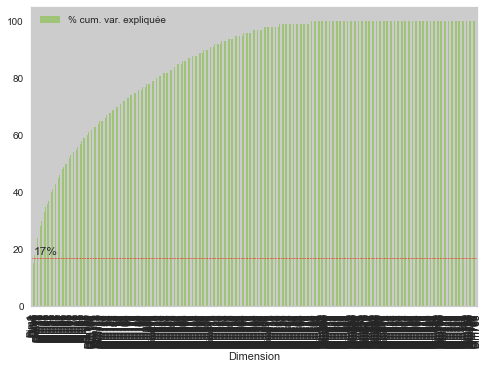

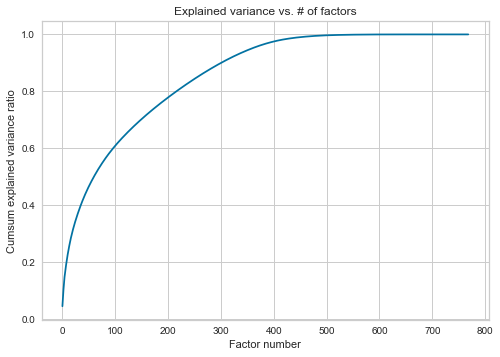

In [123]:
pk.amulti_acp_choice_dim(df_acp2, Z)

Nous aurions besoin de conserver 100 dimensions, selon la méthode du coude.
Cela permettrait d'obtenir environs 60% de notre variance expliquée

Réalisons une visualisation sur 3 axes et le cercle des corrélations.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


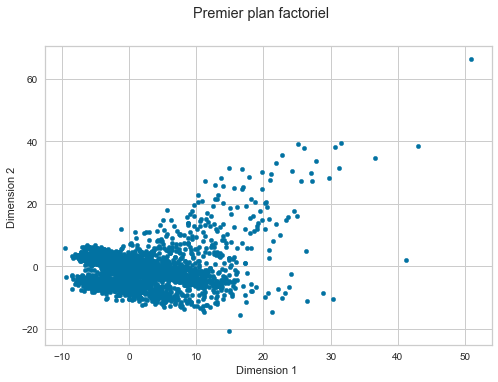

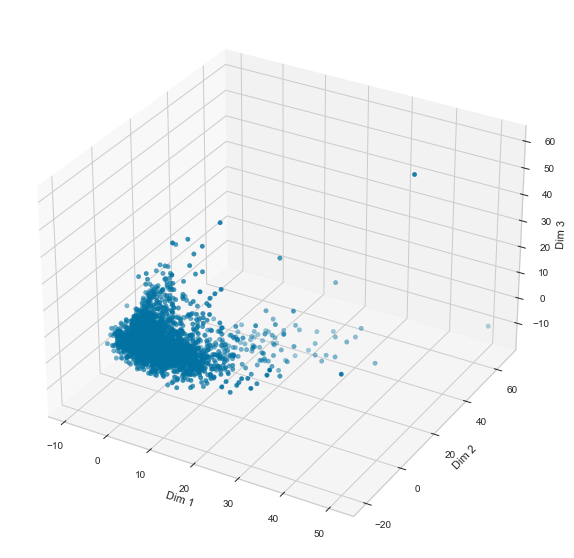

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
156597     0.0            0             1                0             1   
13384      0.0            1             0                0             0   
187860     0.0            1             0                0             1   
56803      0.0            1             1                1             0   
111008     0.0            1             0                0             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
156597          157500.0   1195101.0      63805.5        1129500.0   
13384           166500.0   1525482.0      42079.5        1363500.0   
187860          157500.0   1236816.0      36292.5        1080000.0   
56803           157500.0    225706.5      11655.0         153000.0   
111008          121500.0    835605.0      24561.0         697500.0   

        REGION_POPULATION_RELATIVE  ...  \
156597                    0.025164  ...   
13384                     0.010147  ...   
187860                    0.020246  ...   
56803                     0.010643  ...   
111008                    0.046220  ...   

        CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX  \
156597                                   0.000000   
13384                                    0.000000   
187860                                   0.005569   
56803                                    0.000000   
111008                                   0.005569   

        CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN  \
156597                                    0.000000   
13384                                     0.000000   
187860                                    0.000067   
56803                                     0.000000   
111008                                    0.000067   

        CC_NAME_CONTRACT_STATUS_Sent_proposal_SUM  \
156597                                   0.000000   
13384                                    0.000000   
187860                                   0.005569   
56803                                    0.000000   
111008                                   0.005569   

        CC_NAME_CONTRACT_STATUS_Sent_proposal_VAR  \
156597                                   0.000000   
13384                                    0.000000   
187860                                   0.000067   
56803                                    0.000000   
111008                                   0.000067   

        CC_NAME_CONTRACT_STATUS_Signed_MIN  \
156597                             0.00000   
13384                              0.00000   
187860                             0.00034   
56803                              0.00000   
111008                             0.00034   

        CC_NAME_CONTRACT_STATUS_Signed_MAX  \
156597                            0.000000   
13384                             0.000000   
187860                            0.049968   
56803                             0.000000   
111008                            0.049968   

        CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
156597                             0.000000   
13384                              0.000000   
187860                             0.003733   
56803                              0.000000   
111008                             0.003733   

        CC_NAME_CONTRACT_STATUS_Signed_SUM  \
156597                            0.000000   
13384                             0.000000   
187860                            0.116894   
56803                             0.000000   
111008                            0.116894   

        CC_NAME_CONTRACT_STATUS_Signed_VAR   CC_COUNT  
156597                             0.00000   4.000000  
13384                              0.00000   2.000000  
187860                             0.00308  37.771529  
56803                              0.00000  30.000000  
111008                             0.00308  37.771529  

[5 rows x 769 columns]

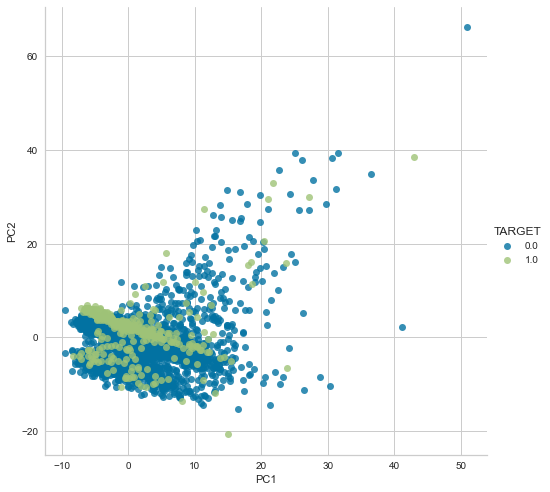

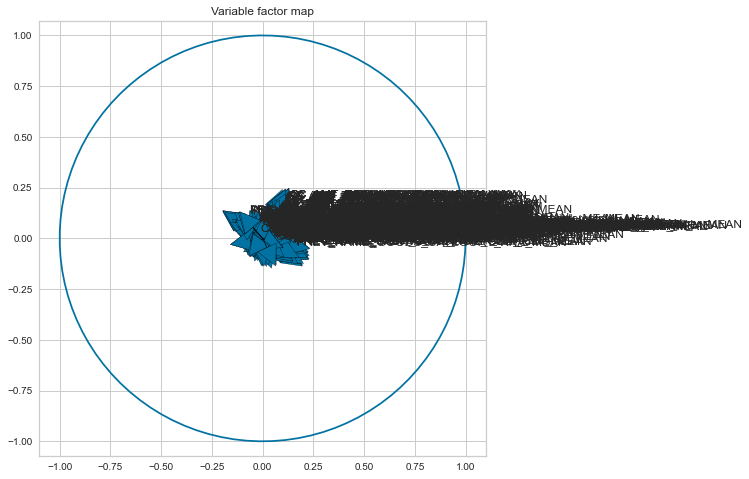

                                      id    COS2_1    COS2_2
0                                 TARGET  0.000478  0.014477
1                            CODE_GENDER  0.001301  0.005172
2                           FLAG_OWN_CAR  0.000175  0.000857
3                        FLAG_OWN_REALTY  0.003725  0.001219
4                           CNT_CHILDREN  0.005116  0.007780
..                                   ...       ...       ...
764   CC_NAME_CONTRACT_STATUS_Signed_MAX  0.000068  0.000054
765  CC_NAME_CONTRACT_STATUS_Signed_MEAN  0.001552  0.001351
766   CC_NAME_CONTRACT_STATUS_Signed_SUM  0.000409  0.000681
767   CC_NAME_CONTRACT_STATUS_Signed_VAR  0.001298  0.001542
768                             CC_COUNT  0.015355  0.050207

[769 rows x 3 columns]
                                      id     CTR_1     CTR_2
0                                 TARGET  0.000015  0.000596
1                            CODE_GENDER  0.000040  0.000213
2                           FLAG_OWN_CAR  0.000005  0.000035


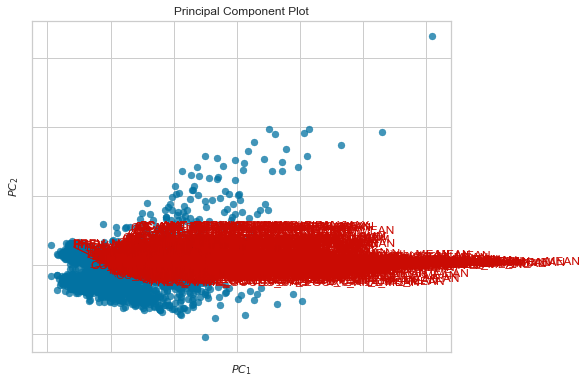

In [125]:
pk.amultiacp_visualizer(df_acp2, Z, 3, df_acp,df_acp["SK_ID_CURR"], df_acp["TARGET"], "TARGET")


Il faudrait conserver 100 axes, cependant les variables sont assez éloignées du cercle. Le graphique n'est pas très visible à cause du nombre de variables, mais nous pouvons observer que deux groupes se détachent sur le premier plan factoriel.

## Modification du kaggle

Nous décidons de modifier le kaggle car il intègre des variables avec des scores. De plus, il ne standardise pas les données lors de la création du modèle.

Nous n'avons pas besoin de supprimer les variables corrélées car  le light gradient boosting réalise une selection des features les plus importantes pour le modèle.

Nous avons vu que la target était déséquilibrée, nous allons ajouter aussi un SMOTE.

Concernant la métrique, il serait intéressant d'en ajouter.
Essayons de voir si l'accuracy peut être utilisé. Testons un modèle naïf et comparons les resultats avec le LGBM.

Créons avant une fonction pour séparer notre jeu de données en train et en test.

In [27]:
def pipelineModel_TrainingSet(X,Y, stand, test_size_i):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=20)
    if stand==1:
        std_scale = preprocessing.StandardScaler().fit(X_train)

        X_train_std = std_scale.transform(X_train)
        X_test_std = std_scale.transform(X_test)
        return X_train_std, X_test_std, y_train, y_test
    else:
        return X_train, X_test, y_train, y_test


Utilisons un échantillon de données car l'ordinateur dont nous disposons n'est pas assez puissant.

In [28]:
data=df.copy()

In [29]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)


In [30]:
num_rows=10000
ech_train=int((float(num_rows)*float(0.86)))
ech_test=int((float(num_rows)*float(0.14)))

test_part=(data.loc[df["TARGET"].notnull()]).sample(n=ech_test)
print("ech train : "+str(ech_train))
print("ech test : "+str(ech_test))

ech1=int((float(ech_train)*float(0.9193)))
ech2=int((float(ech_train)*float(0.0807)))
print("ech train 0 : "+str(ech1))
print("ech train 1 : "+str(ech2))
part1=(data.loc[df["TARGET"]==0]).sample(n=ech1)
part2=(data.loc[df["TARGET"]==1]).sample(n=ech2)

result = part1.append(part2)
result2 = result.append(test_part)

print("shape result {}".format(result2.shape))
data = result2

ech train : 8600
ech test : 1400
ech train 0 : 7905
ech train 1 : 694
shape result (9999, 19)


In [31]:
data2=data.copy()
del data2["TARGET"]

In [32]:
data2.shape

(9999, 18)

In [33]:
for i in data2.columns:                
    data2[i] =  data[i].fillna(data.groupby("TARGET")[i].transform('mean'))

In [34]:
for i in data2.columns:
    data2[i] = data[i].fillna(data[i].mean())

In [35]:
Y=data["TARGET"]
X=data2

In [36]:
X_train, X_test, y_train, y_test = pipelineModel_TrainingSet(X, Y, 0, 0.3)

#### Choix métrique comparaison avec modèle aléatoire : dummyclassifier

In [295]:
# example of the majority class naive classifier in scikit-learn
from numpy import asarray
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

    
# define model
model = DummyClassifier(strategy='most_frequent')
# fit model
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_train)
# calculate accuracy
accuracy = accuracy_score(y_train, yhat)
print('Accuracy: %.3f' % accuracy)


Accuracy: 0.920


Accuracy n'est pas une bonne métrique car elle sera toujours de 92%, au vu des proportions de la variable cible.
Nous allons donc plutôt utiliser d'autres métriques comme l'air sous la courbe roc.

Le but ici est de détecter les clients qui ne rembourseront pas leur prêt. Donc il faut minimiser les Faux négatifs, auutrement dit il faut minimiser le nombre de valeurs prédites 0 alors que la valeur réelle est 1.

Nous allons donc ajouter une métrique métier : en ajoutant des poids plus important sur les faux négatifs.
- taux métiers = (FN*0.9+FP*0.1)/(FN*0.9+FP*0.1+TN+TP)

In [37]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
#####encoder les colonnes catégorielles
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    ####lecture des fichiers application_train et application test
    df = pd.read_csv('./input/application_train.csv')
    test_df = pd.read_csv('./input/application_test.csv')
    ####affiche le nb de lignes
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    print("shape {}".format(df.shape))
    df = df.append(test_df).reset_index()
    df.dropna()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df.drop(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"], axis=1)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    if num_rows!= None:
        ech_train=int((float(num_rows)*float(0.86)))
        ech_test=int((float(num_rows)*float(0.14)))

        test_part=(df.loc[df["TARGET"].isnull()]).sample(n=ech_test)
        print("ech train : "+str(ech_train))
        print("ech test : "+str(ech_test))

        ech1=int((float(ech_train)*float(0.9193)))
        ech2=int((float(ech_train)*float(0.0807)))

        print("ech train 0 : "+str(ech1))
        print("ech train 1 : "+str(ech2))

        part1=(df.loc[df["TARGET"]==0]).sample(n=ech1)
        part2=(df.loc[df["TARGET"]==1]).sample(n=ech2)

        result = part1.append(part2)
        result2 = result.append(test_part)

        print("shape result {}".format(result2.shape))
        df = result2
        print("test nb : ", df.loc[df["TARGET"]==1].shape)
    # Categorical features with Binary encode (0 or 1; two categories)
    ####encodage des variables binaires 1/0 et on applique one_hot_encoder sur les autres variables
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    ####suppresion des data test_df et nettoyage du garbage collector : nettoyage des vieux objects
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    ####lecture des data et encodage des variable cat
    bureau = pd.read_csv('./input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    ####calcul d'agregat pour les variables
    bb_aggregations = {}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    ## jointure bureau - bureau_balance
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    ###suppr bureau balance et nettoyage des objects
    del bb, bb_agg
    gc.collect()
    
    #######nouveaux calcul d'agregation pour les variables
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': [ 'mean'],
        'DAYS_CREDIT_ENDDATE': [ 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': [ 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['mean', ],
        'AMT_CREDIT_SUM_DEBT': ['mean'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean'],
        'AMT_ANNUITY': [ 'mean']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    ####création des aggregations pour les credits ouverts et jointure
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    ####création des aggregations pour les credits fermés et jointure
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    ####calcul agregat
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': [ 'mean'],
        'AMT_APPLICATION': [ 'mean'],
        'AMT_CREDIT': [ 'mean'],
        'APP_CREDIT_PERC': ['mean'],
        'AMT_DOWN_PAYMENT': [ 'mean'],
        'AMT_GOODS_PRICE': [ 'mean'],
        'HOUR_APPR_PROCESS_START': ['mean'],
        'RATE_DOWN_PAYMENT': ['mean'],
        'DAYS_DECISION': [ 'mean'],
        'CNT_PAYMENT': ['mean'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    ####agregat approuvé
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    ####agregat refusé
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    ###agregat
    # Features
    aggregations = {
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'DPD': ['mean'],
        'DBD': [ 'mean'],
        'PAYMENT_PERC': [ 'mean'],
        'PAYMENT_DIFF': ['mean'],
        'AMT_INSTALMENT': ['mean'],
        'AMT_PAYMENT': ['mean'],
        'DAYS_ENTRY_PAYMENT': [ 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['mean'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code

### erreur special caractere dans le nom d'un variable
def kfold_lightgbm(df, num_folds, stratified = False, debug= False, stand=1): ####changed paramater stratified True to False
    info=pk.data_uniqueone_string(df)
    
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    print("replace")
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for i in train_df.columns:                
        train_df[i] =  train_df[i].fillna(train_df.groupby("TARGET")[i].transform('mean'))

    for i in train_df.columns:
        train_df[i] = train_df[i].fillna(train_df[i].loc[pd.isna(train_df[i])==False].mean())
    
    print("nan:",np.any(np.isnan(train_df)) )#and gets False
    print("infinity:",np.all(np.isfinite(train_df))) #and gets True
    # Cross validation model < Equilibre
    ##créez un séparateur de CV - StratifiedKFoldparce que c'est un problème de classification / Kfold regression
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001) ### shuffle melanger les echantillons avant division en lots 
        #random_state = ordre d'indice pourcontroler l'aspect alea
    
    
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    smoter = SMOTE(random_state=20)
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df.loc[:,feats], train_df['TARGET'])):
        train_x, train_y = train_df.loc[:,feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df.loc[:,feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

         # LightGBM parameters found by Bayesian optimization
       
        clf = LGBMClassifier(
            nthread=4,#utilise 4 threads
            n_estimators=10000, ## nombre d'arbres à l'interieur de l'ensemble
            learning_rate=0.02,# le paramètre de taille de pas de la descente de gradient / contrôle la vitesse d'apprentissage. Les valeurs typiques se situent entre 0,01 et 0,3
            num_leaves=34, ## contrôle le nombre de feuilles >>> 2^(max_depth). 
            # Cela signifie que la valeur optimale pour num_leavesse situe dans la plage (2^3, 2^12) ou (8, 4096).
            ##num_leaves impacte l'apprentissage dans LGBM plus de max_depth. Cela signifie qu'il faut spécifier une plage de recherche plus conservatrice comme (20, 3000)
            
            colsample_bytree=0.9497036,
            subsample=0.8715623,# bagging_fraction valeur subsample comprise entre (0, 1) et spécifie le pourcentage d'échantillons d'apprentissage à utiliser pour entraîner chaque arbre
            ## pour activer subsample il faut definir bagging_freq/subsample_freq defaut 0
            
            max_depth=8, ##valeur entre 3 et 12 plus un arbre est haut et plus il est complexe
            reg_alpha=0.041545473, #lambda_l1 :  une bonne plage de recherche est (0, 100)
            reg_lambda=0.0735294, #lambda_l2 :  une bonne plage de recherche est (0, 100)
            min_split_gain=0.0222415, # regularisation supplémentaire dans les plages de parametres : plage de recherche prudente est (0, 15)
            min_child_weight=39.3259775,
            #silent=-1,
            verbose=-1, )
        
        if stand==1:
            std_scale = preprocessing.StandardScaler().fit(train_x)
            X_scaled = std_scale.transform(train_x)


            #########ajout SMOTE:
             # Upsample only the data in the training section
            X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_scaled,train_y)
            
        else:
            #########ajout SMOTE:
             # Upsample only the data in the training section
            X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(train_x,train_y)
        
        
        
        ####option : feature_fraction spécifie le pourcentage d'entités à échantillonner lors de l'apprentissage de chaque arbre. Ainsi, il prend également une valeur comprise entre (0, 1).

        ########option early_stopping_roundsparamètres à l'intérieur de la fitfonction. 
        ####Par exemple, le définir sur 100 signifie que nous arrêtons l'entraînement 
        ###si les prédictions ne se sont pas améliorées au cours des 100 derniers tours.
        ###il faut avoir mis un eval_set : X_train, X_eval, y_train, y_eval = train_test_split(X_enc, y, test_size=0.1)
        ###eval_set = [(X_eval, y_eval)]
        ##qualité des prédictions est mesurée avec une métrique passée dans eval_metric
        #####option categorical_feature=cat_idx,  # Specify the categoricals # indiquer la liste des var quali
        ##autre param min_data_in_leafsur : ex : si la feuille de décision vérifie si une caractéristique est supérieure à, disons, 13 - la définition min_data_in_leafsur 100 signifie que nous voulons évaluer cette feuille uniquement si au moins 100 observations d'entraînement sont supérieures à 13
        clf.fit(X_train_fold_upsample, y_train_fold_upsample, eval_set=[(X_train_fold_upsample, y_train_fold_upsample), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        ##calul des predictions
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        
        ##resultats en fonction des fold et courbe de roc
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        y_pred_f = np.where(oof_preds[valid_idx] > 0.5, 1, 0)
        CM_f = metrics.confusion_matrix(valid_y, y_pred_f)

        TN_f = CM_f[0][0]
        FN_f = CM_f[1][0]
        TP_f = CM_f[1][1]
        FP_f = CM_f[0][1]
        metier_f = (FN_f*0.9+FP_f*0.1) / (FN_f*0.9+FP_f*0.1+TP_f+TN_f)
        print('Métrique Taux Métier : ', metier_f, ' - FOLD : ', n_fold + 1)
        clf.booster_.save_model('lgb_classifier.txt', num_iteration=clf.best_iteration_) 
        del clf, train_x, train_y, valid_x, valid_y, X_train_fold_upsample, y_train_fold_upsample
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    
    #add our metric 0.9*falseNegative+0.1*falsepositive
    y_pred = np.where(oof_preds > 0.5, 1, 0)
    CM = metrics.confusion_matrix(train_df['TARGET'], y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.9+FP*0.1)/(FN*0.9+FP*0.1+TN+TP)
    
    print('FULL Métrique Métier : ', metier)
    
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')
    
###"UTiliser Optuna pour optimiser les hyperparamètres"



Comparons avec les données standardisées et sans. Parfois les résultats sont meilleurs avec les données de base.

Train samples: 307511, test samples: 48744
shape (307511, 122)
ok df
Bureau df shape: (305811, 65)
Process bureau and bureau_balance - done in 15s
Previous applications df shape: (338857, 189)
Process previous_applications - done in 20s
Pos-cash balance df shape: (337252, 11)
Process POS-CASH balance - done in 8s
Installments payments df shape: (339587, 8)
Process installments payments - done in 16s
Credit card balance df shape: (103558, 29)
Process credit card balance - done in 9s
(356251, 542)
index - count unique : 307509
SK_ID_CURR - count unique : 356251
TARGET - count unique : 2
CODE_GENDER - count unique : 2
FLAG_OWN_CAR - count unique : 2
FLAG_OWN_REALTY - count unique : 2
CNT_CHILDREN - count unique : 16
AMT_INCOME_TOTAL - count unique : 2741
AMT_CREDIT - count unique : 6480
AMT_ANNUITY - count unique : 14166
AMT_GOODS_PRICE - count unique : 1291
REGION_POPULATION_RELATIVE - count unique : 82
DAYS_BIRTH - count unique : 17467
DAYS_EMPLOYED - count unique : 12896
DAYS_REGISTRAT

ORGANIZATION_TYPE_Transport_type_3 - count unique : 2
ORGANIZATION_TYPE_Transport_type_4 - count unique : 2
ORGANIZATION_TYPE_University - count unique : 2
ORGANIZATION_TYPE_XNA - count unique : 2
FONDKAPREMONT_MODE_not_specified - count unique : 2
FONDKAPREMONT_MODE_org_spec_account - count unique : 2
FONDKAPREMONT_MODE_reg_oper_account - count unique : 2
FONDKAPREMONT_MODE_reg_oper_spec_account - count unique : 2
HOUSETYPE_MODE_block_of_flats - count unique : 2
HOUSETYPE_MODE_specific_housing - count unique : 2
HOUSETYPE_MODE_terraced_house - count unique : 2
WALLSMATERIAL_MODE_Block - count unique : 2
WALLSMATERIAL_MODE_Mixed - count unique : 2
WALLSMATERIAL_MODE_Monolithic - count unique : 2
WALLSMATERIAL_MODE_Others - count unique : 2
WALLSMATERIAL_MODE_Panel - count unique : 2
WALLSMATERIAL_MODE_Stone_brick - count unique : 2
WALLSMATERIAL_MODE_Wooden - count unique : 2
EMERGENCYSTATE_MODE_No - count unique : 2
EMERGENCYSTATE_MODE_Yes - count unique : 2
BURO_DAYS_CREDIT_MEAN - co

PREV_CODE_REJECT_REASON_CLIENT_MEAN - count unique : 124
PREV_CODE_REJECT_REASON_HC_MEAN - count unique : 409
PREV_CODE_REJECT_REASON_LIMIT_MEAN - count unique : 257
PREV_CODE_REJECT_REASON_SCO_MEAN - count unique : 216
PREV_CODE_REJECT_REASON_SCOFR_MEAN - count unique : 165
PREV_CODE_REJECT_REASON_SYSTEM_MEAN - count unique : 59
PREV_CODE_REJECT_REASON_VERIF_MEAN - count unique : 86
PREV_CODE_REJECT_REASON_XAP_MEAN - count unique : 421
PREV_CODE_REJECT_REASON_XNA_MEAN - count unique : 109
deleted unique colonne : PREV_CODE_REJECT_REASON_nan_MEAN
PREV_NAME_TYPE_SUITE_Children_MEAN - count unique : 132
PREV_NAME_TYPE_SUITE_Family_MEAN - count unique : 289
PREV_NAME_TYPE_SUITE_Group_of_people_MEAN - count unique : 56
PREV_NAME_TYPE_SUITE_Other_A_MEAN - count unique : 80
PREV_NAME_TYPE_SUITE_Other_B_MEAN - count unique : 112
PREV_NAME_TYPE_SUITE_Spouse_partner_MEAN - count unique : 182
PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN - count unique : 411
PREV_NAME_TYPE_SUITE_nan_MEAN - count uniqu

CC_AMT_DRAWINGS_CURRENT_MEAN - count unique : 57397
CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN - count unique : 4397
CC_AMT_DRAWINGS_POS_CURRENT_MEAN - count unique : 39808
CC_AMT_INST_MIN_REGULARITY_MEAN - count unique : 67591
CC_AMT_PAYMENT_CURRENT_MEAN - count unique : 66748
CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN - count unique : 67932
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN - count unique : 68980
CC_AMT_RECIVABLE_MEAN - count unique : 70224
CC_AMT_TOTAL_RECEIVABLE_MEAN - count unique : 70224
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN - count unique : 3544
CC_CNT_DRAWINGS_CURRENT_MEAN - count unique : 7111
CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN - count unique : 470
CC_CNT_DRAWINGS_POS_CURRENT_MEAN - count unique : 5492
CC_CNT_INSTALMENT_MATURE_CUM_MEAN - count unique : 15471
CC_SK_DPD_MEAN - count unique : 3945
CC_SK_DPD_DEF_MEAN - count unique : 1629
CC_NAME_CONTRACT_STATUS_Active_MEAN - count unique : 1120
CC_NAME_CONTRACT_STATUS_Approved_MEAN - count unique : 6
CC_NAME_CONTRACT_STATUS_Completed_MEAN - count uniqu

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aurel\AppData\Local\Temp/ipykernel_9784/1531869011.py:282: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aurel\AppData\Local\Temp/ipykernel_9784/1531869011.py:285: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

nan: False
infinity: True


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0105674	valid_1's auc: 0.5721	valid_1's binary_logloss: 3.77382
Fold  1 AUC : 0.500000
Métrique Taux Métier :  0.5323741007194245  - FOLD :  1


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0105598	valid_1's auc: 0.497608	valid_1's binary_logloss: 3.78635
Fold  2 AUC : 0.493570
Métrique Taux Métier :  0.4071200157616356  - FOLD :  2


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0105747	valid_1's auc: 0.516952	valid_1's binary_logloss: 3.88264
Fold  3 AUC : 0.488152
Métrique Taux Métier :  0.41436107223597807  - FOLD :  3


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0105179	valid_1's auc: 0.507474	valid_1's binary_logloss: 3.6245
Fold  4 AUC : 0.500000
Métrique Taux Métier :  0.5323741007194245  - FOLD :  4


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0105561	valid_1's auc: 0.493144	valid_1's binary_logloss: 3.64046
Fold  5 AUC : 0.500000
Métrique Taux Métier :  0.5323741007194245  - FOLD :  5


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0105172	valid_1's auc: 0.401683	valid_1's binary_logloss: 3.80501
Fold  6 AUC : 0.489121
Métrique Taux Métier :  0.3955164688365362  - FOLD :  6


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0105691	valid_1's auc: 0.492544	valid_1's binary_logloss: 3.84015
Fold  7 AUC : 0.490740
Métrique Taux Métier :  0.4116837015729237  - FOLD :  7


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0105072	valid_1's auc: 0.49496	valid_1's binary_logloss: 3.75073
Fold  8 AUC : 0.500000
Métrique Taux Métier :  0.5324743821579265  - FOLD :  8


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0104924	valid_1's auc: 0.50877	valid_1's binary_logloss: 3.69402
Fold  9 AUC : 0.500000
Métrique Taux Métier :  0.5324743821579265  - FOLD :  9


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0105887	valid_1's auc: 0.399818	valid_1's binary_logloss: 3.70461
Fold 10 AUC : 0.500000
Métrique Taux Métier :  0.5324743821579265  - FOLD :  10
Full AUC score 0.496019
FULL Métrique Métier :  0.47503591617344065


C:\Users\aurel\AppData\Local\Temp/ipykernel_9784/1531869011.py:400: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Run LightGBM with kfold - done in 857s
Full model run - done in 930s


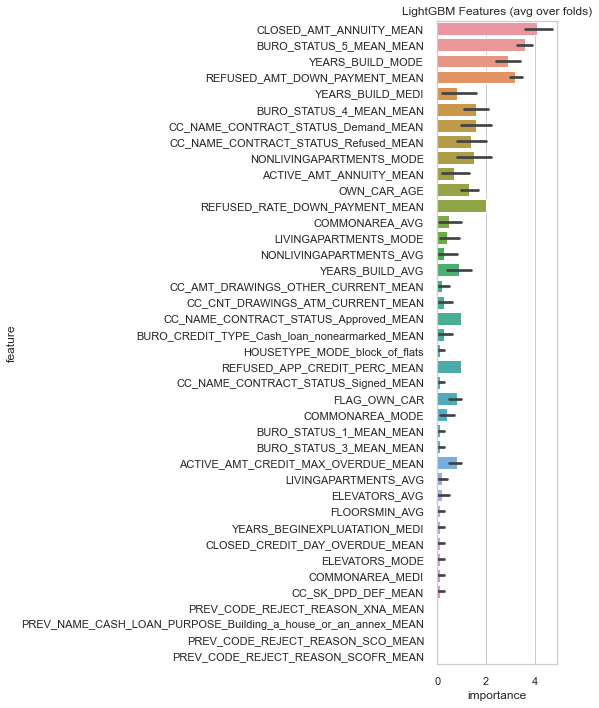

In [509]:
# lance chaque fonction avec un timer
def main(debug = True, stand=1):
    num_rows = 100000 if debug else None
    df = application_train_test(num_rows)
    print("ok df")
    ####import fichiers + calcul agregats (new features) et jointure de toutes les tables
    ### + nettoyage memoire
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    #######target : le pret a été remboursé et 1 le pret n'a pas ete   remboursé
    with timer("Run LightGBM with kfold"):
        df.columns = df.columns.str.strip()     
        df.columns = df.columns.str.replace(' ', '_')         
        df.columns = df.columns.str.replace(r"[^a-zA-Z\d\_]+", "")    
        df.columns = df.columns.str.replace(r"[^a-zA-Z\d\_]+", "")
        print(df.shape)
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= True, debug= debug, stand=stand)
        return df, feat_importance
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df, feat_importance=main(False,1)

Train samples: 307511, test samples: 48744
shape (307511, 122)
ok df
Bureau df shape: (305811, 65)
Process bureau and bureau_balance - done in 27s
Previous applications df shape: (338857, 189)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 11)
Process POS-CASH balance - done in 13s
Installments payments df shape: (339587, 8)
Process installments payments - done in 20s
Credit card balance df shape: (103558, 29)
Process credit card balance - done in 10s
(356251, 542)
index - count unique : 307509
SK_ID_CURR - count unique : 356251
TARGET - count unique : 2
CODE_GENDER - count unique : 2
FLAG_OWN_CAR - count unique : 2
FLAG_OWN_REALTY - count unique : 2
CNT_CHILDREN - count unique : 16
AMT_INCOME_TOTAL - count unique : 2741
AMT_CREDIT - count unique : 6480
AMT_ANNUITY - count unique : 14166
AMT_GOODS_PRICE - count unique : 1291
REGION_POPULATION_RELATIVE - count unique : 82
DAYS_BIRTH - count unique : 17467
DAYS_EMPLOYED - count unique : 12896
DAYS_REGISTR

ORGANIZATION_TYPE_Industry_type_8 - count unique : 2
ORGANIZATION_TYPE_Industry_type_9 - count unique : 2
ORGANIZATION_TYPE_Insurance - count unique : 2
ORGANIZATION_TYPE_Kindergarten - count unique : 2
ORGANIZATION_TYPE_Legal_Services - count unique : 2
ORGANIZATION_TYPE_Medicine - count unique : 2
ORGANIZATION_TYPE_Military - count unique : 2
ORGANIZATION_TYPE_Mobile - count unique : 2
ORGANIZATION_TYPE_Other - count unique : 2
ORGANIZATION_TYPE_Police - count unique : 2
ORGANIZATION_TYPE_Postal - count unique : 2
ORGANIZATION_TYPE_Realtor - count unique : 2
ORGANIZATION_TYPE_Religion - count unique : 2
ORGANIZATION_TYPE_Restaurant - count unique : 2
ORGANIZATION_TYPE_School - count unique : 2
ORGANIZATION_TYPE_Security - count unique : 2
ORGANIZATION_TYPE_Security_Ministries - count unique : 2
ORGANIZATION_TYPE_Selfemployed - count unique : 2
ORGANIZATION_TYPE_Services - count unique : 2
ORGANIZATION_TYPE_Telecom - count unique : 2
ORGANIZATION_TYPE_Trade_type_1 - count unique : 2
O

PREV_NAME_CONTRACT_STATUS_Approved_MEAN - count unique : 387
PREV_NAME_CONTRACT_STATUS_Canceled_MEAN - count unique : 387
PREV_NAME_CONTRACT_STATUS_Refused_MEAN - count unique : 423
PREV_NAME_CONTRACT_STATUS_Unused_offer_MEAN - count unique : 124
deleted unique colonne : PREV_NAME_CONTRACT_STATUS_nan_MEAN
PREV_NAME_PAYMENT_TYPE_Cash_through_the_bank_MEAN - count unique : 450
PREV_NAME_PAYMENT_TYPE_Cashless_from_the_account_of_the_employer_MEAN - count unique : 55
PREV_NAME_PAYMENT_TYPE_Noncash_from_your_account_MEAN - count unique : 106
PREV_NAME_PAYMENT_TYPE_XNA_MEAN - count unique : 438
deleted unique colonne : PREV_NAME_PAYMENT_TYPE_nan_MEAN
PREV_CODE_REJECT_REASON_CLIENT_MEAN - count unique : 124
PREV_CODE_REJECT_REASON_HC_MEAN - count unique : 409
PREV_CODE_REJECT_REASON_LIMIT_MEAN - count unique : 257
PREV_CODE_REJECT_REASON_SCO_MEAN - count unique : 216
PREV_CODE_REJECT_REASON_SCOFR_MEAN - count unique : 165
PREV_CODE_REJECT_REASON_SYSTEM_MEAN - count unique : 59
PREV_CODE_REJEC

POS_NAME_CONTRACT_STATUS_Completed_MEAN - count unique : 1705
POS_NAME_CONTRACT_STATUS_Demand_MEAN - count unique : 260
POS_NAME_CONTRACT_STATUS_Returned_to_the_store_MEAN - count unique : 241
POS_NAME_CONTRACT_STATUS_Signed_MEAN - count unique : 870
POS_NAME_CONTRACT_STATUS_XNA_MEAN - count unique : 3
deleted unique colonne : POS_NAME_CONTRACT_STATUS_nan_MEAN
POS_COUNT - count unique : 234
INSTAL_DPD_MEAN - count unique : 25376
INSTAL_DBD_MEAN - count unique : 62882
INSTAL_PAYMENT_PERC_MEAN - count unique : 50617
INSTAL_PAYMENT_DIFF_MEAN - count unique : 160499
INSTAL_AMT_INSTALMENT_MEAN - count unique : 335541
INSTAL_AMT_PAYMENT_MEAN - count unique : 335981
INSTAL_DAYS_ENTRY_PAYMENT_MEAN - count unique : 241214
INSTAL_COUNT - count unique : 323
CC_MONTHS_BALANCE_MEAN - count unique : 570
CC_AMT_BALANCE_MEAN - count unique : 70080
CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN - count unique : 13036
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN - count unique : 24822
CC_AMT_DRAWINGS_CURRENT_MEAN - count unique :

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\aurel\AppData\Local\Temp/ipykernel_19168/1531869011.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[i] =  train_df[i].fillna(train_df.groupby("TARGET")[i].transform('mean'))
C:\Users\aurel\AppData\Local\Temp/ipykernel_19168/1531869011.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

nan: False
infinity: True


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0106904	valid_1's auc: 0.999996	valid_1's binary_logloss: 0.0115992
[400]	training's auc: 1	training's binary_logloss: 0.0006917	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.00130572
[600]	training's auc: 1	training's binary_logloss: 0.000343276	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.000876818
[800]	training's auc: 1	training's binary_logloss: 0.000293924	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.000845576
Fold  1 AUC : 0.999999
Métrique Taux Métier :  0.0001626227801990503  - FOLD :  1


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0106203	valid_1's auc: 0.999994	valid_1's binary_logloss: 0.0115173
[400]	training's auc: 1	training's binary_logloss: 0.000685478	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.00136979
[600]	training's auc: 1	training's binary_logloss: 0.000341727	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.000971037
[800]	training's auc: 1	training's binary_logloss: 0.000292462	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.000929596
Fold  2 AUC : 0.999999
Métrique Taux Métier :  0.00016913759343225714  - FOLD :  2


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0107523	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.0111652
[400]	training's auc: 1	training's binary_logloss: 0.000696171	valid_1's auc: 1	valid_1's binary_logloss: 0.000919417
[600]	training's auc: 1	training's binary_logloss: 0.000355209	valid_1's auc: 1	valid_1's binary_logloss: 0.000540223
Fold  3 AUC : 1.000000
Métrique Taux Métier :  3.252032520325203e-05  - FOLD :  3


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0107549	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.0107814
[400]	training's auc: 1	training's binary_logloss: 0.000708742	valid_1's auc: 1	valid_1's binary_logloss: 0.000755809
Fold  4 AUC : 1.000000
Métrique Taux Métier :  9.105750281302644e-05  - FOLD :  4


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0105478	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.0109931
[400]	training's auc: 1	training's binary_logloss: 0.000700443	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.000940773
[600]	training's auc: 1	training's binary_logloss: 0.000353637	valid_1's auc: 1	valid_1's binary_logloss: 0.000550445
[800]	training's auc: 1	training's binary_logloss: 0.000301632	valid_1's auc: 1	valid_1's binary_logloss: 0.000495674
Fold  5 AUC : 1.000000
Métrique Taux Métier :  6.178881882542707e-05  - FOLD :  5


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0106155	valid_1's auc: 0.999997	valid_1's binary_logloss: 0.0114387
[400]	training's auc: 1	training's binary_logloss: 0.000701368	valid_1's auc: 1	valid_1's binary_logloss: 0.00106208
[600]	training's auc: 1	training's binary_logloss: 0.000358738	valid_1's auc: 1	valid_1's binary_logloss: 0.000652108
[800]	training's auc: 1	training's binary_logloss: 0.000305387	valid_1's auc: 1	valid_1's binary_logloss: 0.000588681
Fold  6 AUC : 1.000000
Métrique Taux Métier :  7.155123068116772e-05  - FOLD :  6


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0106226	valid_1's auc: 0.999996	valid_1's binary_logloss: 0.0111792
[400]	training's auc: 1	training's binary_logloss: 0.000702099	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.000960512
[600]	training's auc: 1	training's binary_logloss: 0.000354646	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.000599025
Fold  7 AUC : 0.999999
Métrique Taux Métier :  6.178881882542707e-05  - FOLD :  7


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0106578	valid_1's auc: 0.999997	valid_1's binary_logloss: 0.0111399
[400]	training's auc: 1	training's binary_logloss: 0.000710002	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.00104859
[600]	training's auc: 1	training's binary_logloss: 0.000355128	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.000694
Fold  8 AUC : 0.999999
Métrique Taux Métier :  0.00012033029038626024  - FOLD :  8


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.01076	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.0109737
[400]	training's auc: 1	training's binary_logloss: 0.000690041	valid_1's auc: 1	valid_1's binary_logloss: 0.000868722
[600]	training's auc: 1	training's binary_logloss: 0.000351664	valid_1's auc: 1	valid_1's binary_logloss: 0.000524729
[800]	training's auc: 1	training's binary_logloss: 0.000303546	valid_1's auc: 1	valid_1's binary_logloss: 0.000481915
Fold  9 AUC : 1.000000
Métrique Taux Métier :  3.577456818470085e-05  - FOLD :  9


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 1	training's binary_logloss: 0.0107091	valid_1's auc: 0.999999	valid_1's binary_logloss: 0.0111734
[400]	training's auc: 1	training's binary_logloss: 0.000697287	valid_1's auc: 1	valid_1's binary_logloss: 0.000850363
[600]	training's auc: 1	training's binary_logloss: 0.000350939	valid_1's auc: 1	valid_1's binary_logloss: 0.000471314
Fold 10 AUC : 1.000000
Métrique Taux Métier :  6.179082828979248e-05  - FOLD :  10
Full AUC score 0.999999
FULL Métrique Métier :  8.683415359628363e-05


C:\Users\aurel\AppData\Local\Temp/ipykernel_19168/1531869011.py:400: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


Run LightGBM with kfold - done in 1170s
Full model run - done in 1276s


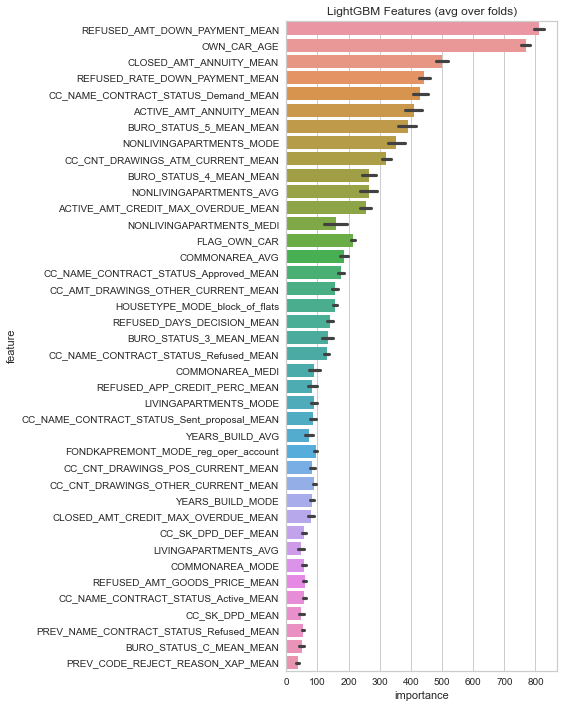

In [180]:
# lance chaque fonction avec un timer
def main(debug = True, stand=1):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    print("ok df")
    ####import fichiers + calcul agregats (new features) et jointure de toutes les tables
    ### + nettoyage memoire
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    #######target : le pret a été remboursé et 1 le pret n'a pas ete   remboursé
    with timer("Run LightGBM with kfold"):
        df.columns = df.columns.str.strip()     
        df.columns = df.columns.str.replace(' ', '_')         
        df.columns = df.columns.str.replace(r"[^a-zA-Z\d\_]+", "")    
        df.columns = df.columns.str.replace(r"[^a-zA-Z\d\_]+", "")
        print(df.shape)
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= True, debug= debug, stand=stand)
        return df, feat_importance
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df, feat_importance=main(False,0)

In [182]:
feat_importance

feature  importance  fold
0                                   CODE_GENDER          20     1
1                                  FLAG_OWN_CAR         225     1
2                               FLAG_OWN_REALTY           0     1
3                                  CNT_CHILDREN           0     1
4                              AMT_INCOME_TOTAL           0     1
..                                          ...         ...   ...
514         CC_NAME_CONTRACT_STATUS_Demand_MEAN         370    10
515        CC_NAME_CONTRACT_STATUS_Refused_MEAN         145    10
516  CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN          63    10
517         CC_NAME_CONTRACT_STATUS_Signed_MEAN          31    10
518                                    CC_COUNT           6    10

[5190 rows x 3 columns]

In [183]:
cols = feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
best_features = feat_importance["feature"].loc[feat_importance.feature.isin(cols)]
#best_features.sort_values(by="importance", ascending=False)

In [184]:
best_features

1                               FLAG_OWN_CAR
13                               OWN_CAR_AGE
34                            COMMONAREA_AVG
42                   NONLIVINGAPARTMENTS_AVG
56                  NONLIVINGAPARTMENTS_MODE
                       ...                  
471               REFUSED_DAYS_DECISION_MEAN
496       CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN
504         CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
512    CC_NAME_CONTRACT_STATUS_Approved_MEAN
514      CC_NAME_CONTRACT_STATUS_Demand_MEAN
Name: feature, Length: 200, dtype: object

nous filtrons le dataset avec les best features

In [186]:
feat_importances=feat_importance[["feature", "importance"]].groupby("feature").mean()

In [187]:
feat_importances

importance
feature                                       
ACTIVE_AMT_ANNUITY_MEAN                  408.7
ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN       255.1
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN            0.9
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN           9.1
ACTIVE_AMT_CREDIT_SUM_MEAN                 0.6
...                                        ...
YEARS_BEGINEXPLUATATION_MEDI               2.6
YEARS_BEGINEXPLUATATION_MODE              11.5
YEARS_BUILD_AVG                           73.6
YEARS_BUILD_MEDI                          27.2
YEARS_BUILD_MODE                          82.6

[519 rows x 1 columns]

En utilisant le smote, nous avons de très bon résultat, nous avons score roc à 99% et un taux métier généralement inférieur à 1%. Nous remarquons que l'ordre des variables les plus importantes dans le model ont changé.

# Sélection des features

In [527]:
df.shape

(356251, 522)

In [46]:
def update_nan_inf(train_df, target, aggregation):
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for i in train_df.columns:                
        train_df[i] =  train_df[i].fillna(train_df.groupby(target)[i].transform(aggregation))

    for i in train_df.columns:
        train_df[i] = train_df[i].fillna(train_df[i].loc[pd.isna(train_df[i])==False].mean())

    print("nan:",np.any(np.isnan(train_df)) )#and gets False
    print("infinity:",np.all(np.isfinite(train_df))) #and gets True
    return train_df

### Utilisons différentes méthodes pour obtenir les variables les plus importantes.

Nous allons créer différentes fonctions pour trouver la méthode qui s'adapte le mieux à nos données.

### Mutual info classifier

Test de mutual_info_classif l'information mutuelle entre deux variables, mesure combien une caractéristique donnée peut en expliquer une autre (cible), ou plus techniquement, combien d'informations sur la cible variable seront obtenues en ayant observé une caractéristique.

Préparons nos données en traitant les données manquantes

In [47]:
data=df.copy()
data2=data.copy()


In [48]:
data2=update_nan_inf(data2, "TARGET", "mean")
del data2["TARGET"]

nan: False
infinity: True


In [49]:
Y=data["TARGET"].loc[data["TARGET"].notnull()]
X=data2.loc[data["TARGET"].notnull()]

In [50]:
X_train, X_test, y_train, y_test = pipelineModel_TrainingSet(X, Y, 0, 0.3)

Suppression des colonnes ID : 

In [51]:
cols=[f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [52]:
X_train=X_train.loc[:, cols]
mutual = mutual_info_classif(X_train,y_train)
feat_mutual = pd.Series(mutual, X_train.columns[0:len(X_train.columns)])


####ajout graph 40 variables / compare Lgbm

In [53]:
feat_mutual

CODE_GENDER                                   0.022104
FLAG_OWN_CAR                                  0.005348
FLAG_OWN_REALTY                               0.004240
CNT_CHILDREN                                  0.002893
AMT_INCOME_TOTAL                              0.001408
                                                ...   
CC_NAME_CONTRACT_STATUS_Demand_MEAN           0.198503
CC_NAME_CONTRACT_STATUS_Refused_MEAN          0.198148
CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN    0.198105
CC_NAME_CONTRACT_STATUS_Signed_MEAN           0.198461
CC_COUNT                                      0.225565
Length: 519, dtype: float64

In [71]:
feat_mutual = feat_mutual.to_frame(name="importance").reset_index()


AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [72]:
feat_mutual=feat_mutual.rename(columns={"index": "feature", "importance":"importance"})

In [93]:
feat_mutual.shape

(519, 3)

In [102]:
feat_mutual[["feature","importance"]].groupby("feature").mean().importance

feature
ACTIVE_AMT_ANNUITY_MEAN               0.240554
ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN    0.186777
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN       0.095689
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN      0.112644
ACTIVE_AMT_CREDIT_SUM_MEAN            0.086754
                                        ...   
YEARS_BEGINEXPLUATATION_MEDI          0.159351
YEARS_BEGINEXPLUATATION_MODE          0.159243
YEARS_BUILD_AVG                       0.211142
YEARS_BUILD_MEDI                      0.210621
YEARS_BUILD_MODE                      0.211743
Name: importance, Length: 519, dtype: float64

In [114]:
def selectionfeats_plot(feature_importance_df_, title, selection):
    
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title(selection+' Features (40)')
    plt.tight_layout()
    title_f=title+".png"
    plt.savefig(title_f)
    feature_importance_df_=feature_importance_df_[["feature","importance"]].groupby("feature").mean()
    feature_importance_df_["rank"]=feature_importance_df_["importance"].rank()
    return feature_importance_df_

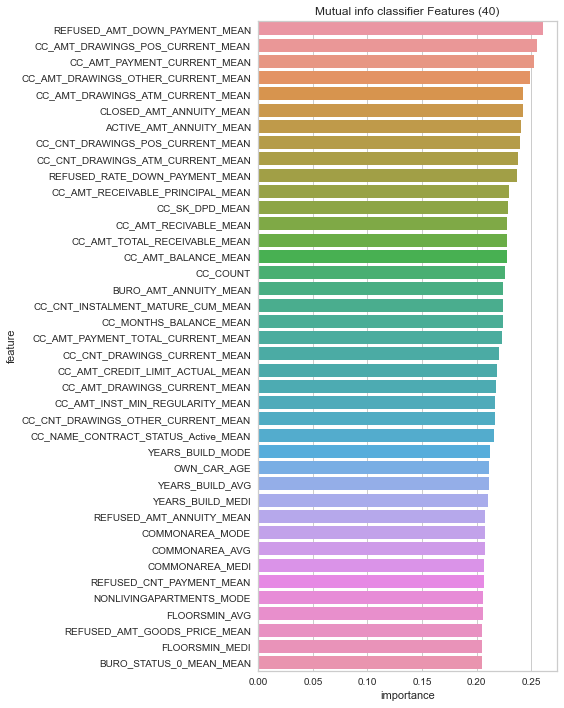

In [109]:
result_mutual=selectionfeats_plot(feat_mutual, "Mutualinfoclassifier", "Mutual info classifier")


In [110]:
result_mutual

importance   rank
feature                                              
ACTIVE_AMT_ANNUITY_MEAN               0.240554  513.0
ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN    0.186777  455.0
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN       0.095689  421.0
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN      0.112644  423.0
ACTIVE_AMT_CREDIT_SUM_MEAN            0.086754  411.0
...                                        ...    ...
YEARS_BEGINEXPLUATATION_MEDI          0.159351  440.0
YEARS_BEGINEXPLUATATION_MODE          0.159243  438.0
YEARS_BUILD_AVG                       0.211142  491.0
YEARS_BUILD_MEDI                      0.210621  490.0
YEARS_BUILD_MODE                      0.211743  493.0

[519 rows x 2 columns]

### ANOVA F

Utilisons SelectKBest pour sélectionner les features avec la meilleure variance et supprimer toutes les features à l'exception de k plus élevées. Cela permettra par la suite d'augmenter le score du modèle.
Autrement dit, le but de cette methode est de choisir les features qui sont les plus discriminantes.

Nous décidons de choisir k=100 car avec l'acp vu précédemment, il nous fallait 100 dimensions pour expliquer notre jeu de données

In [54]:

# define feature selection
fs = SelectKBest(score_func=f_classif, k=100)
# apply feature selection
X_selected = fs.fit_transform(X_train, y_train)
print(X_selected.shape)

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 14 389] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(215254, 100)


In [55]:
X_selected

array([[0.00000000e+00, 1.80000000e+05, 2.63920000e-02, ...,
        1.03229166e+01, 2.98439468e-02, 3.77715286e+01],
       [0.00000000e+00, 9.00000000e+05, 1.02760000e-02, ...,
        2.75172414e+01, 0.00000000e+00, 9.00000000e+01],
       [1.00000000e+00, 4.54500000e+05, 2.28000000e-02, ...,
        1.03229166e+01, 2.98439468e-02, 3.77715286e+01],
       ...,
       [0.00000000e+00, 1.44000000e+05, 1.52210000e-02, ...,
        1.03229166e+01, 2.98439468e-02, 3.77715286e+01],
       [1.00000000e+00, 3.87000000e+05, 2.13400000e-03, ...,
        1.03229166e+01, 2.98439468e-02, 3.77715286e+01],
       [1.00000000e+00, 9.00000000e+05, 2.02460000e-02, ...,
        1.03229166e+01, 2.98439468e-02, 3.77715286e+01]])

In [178]:
names = X_train.columns.values[fs.get_support()]
scores = fs.scores_[fs.get_support()]
#pvalue = fs.pvalues_[fs.get_support()]
names_scores = list(zip(names, scores))
#names_pvalues=list(zip(names, pvalue))
ns_df = pd.DataFrame(data = names_scores, columns=['feature', 'importance'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['feature', 'importance'], ascending = [False, True])

In [111]:
ns_df_sorted.shape

(100, 2)

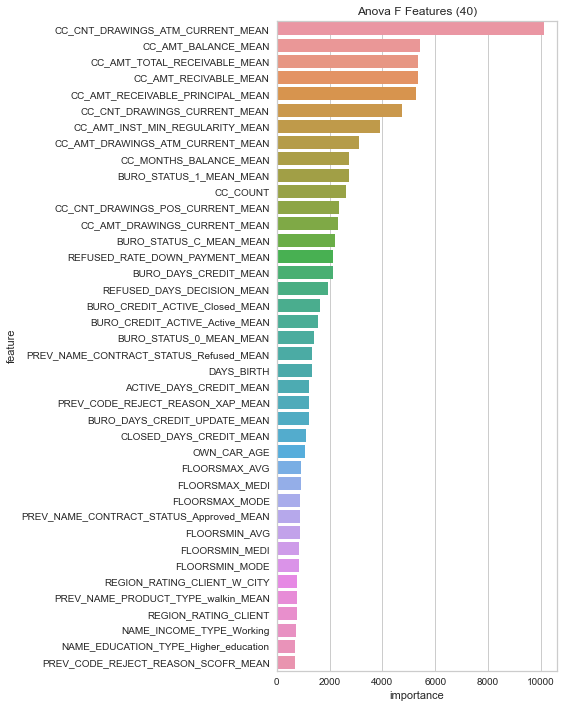

In [115]:
result_anovaf=selectionfeats_plot(ns_df_sorted, "Anovaf", "Anova F")

In [116]:
result_anovaf

importance  rank
feature                                   
ACTIVE_DAYS_CREDIT_MEAN  1236.108883  78.0
AMT_GOODS_PRICE           331.173833  12.0
APARTMENTS_AVG            426.137535  29.0
APARTMENTS_MEDI           415.219308  26.0
APARTMENTS_MODE           358.881841  20.0
...                              ...   ...
REG_CITY_NOT_WORK_CITY    580.525565  53.0
TOTALAREA_MODE            500.139750  44.0
YEARS_BUILD_AVG           351.795034  18.0
YEARS_BUILD_MEDI          357.134646  19.0
YEARS_BUILD_MODE          346.623960  17.0

[100 rows x 2 columns]

### Fisher score

L'idée clé du score de Fisher est de trouver un sous-ensemble d'entités, de sorte que dans l'espace de données couvert par les entités sélectionnées, les distances entre les points de données dans différentes classes soient aussi grandes que possible, tandis que les distances entre les points de données dans la même classe sont aussi petites que possible.

Inconvénients : le F-score révèle le pouvoir discriminant de chaque caractéristique indépendamment des autres. Un score est calculé pour la première caractéristique et un autre score est calculé pour la deuxième caractéristique. Mais il n'indique rien sur la combinaison des deux caractéristiques (informations mutuelles).

Les données sont très importantes, nous allons donc réaliser le fisher_score sur un échantillon.

In [57]:
num_rows=10000
if num_rows== 10000:
        ech_train=int((float(num_rows)*float(0.86)))
        ech_test=int((float(num_rows)*float(0.14)))

        test_part=(data.loc[data["TARGET"].isnull()]).sample(n=ech_test)
        print("ech train : "+str(ech_train))
        print("ech test : "+str(ech_test))

        ech1=int((float(ech_train)*float(0.9193)))
        ech2=int((float(ech_train)*float(0.0807)))

        print("ech train 0 : "+str(ech1))
        print("ech train 1 : "+str(ech2))

        part1=(data.loc[data["TARGET"]==0]).sample(n=ech1)
        part2=(data.loc[data["TARGET"]==1]).sample(n=ech2)

        result = part1.append(part2)
        result2 = result.append(test_part)

        print("shape result {}".format(result2.shape))
        fisher_df = result2

ech train : 8600
ech test : 1400
ech train 0 : 7905
ech train 1 : 694
shape result (9999, 522)


In [58]:
fisher_df

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  \
140830  140830      263286     0.0            0             0   
245587  245587      384222     0.0            1             0   
151977  151977      276159     0.0            0             1   
170198  170198      297257     0.0            0             0   
215030  215030      349164     0.0            1             1   
...        ...         ...     ...          ...           ...   
313509    5998      143936     NaN            0             0   
352673   45162      430708     NaN            1             0   
311382    3871      127531     NaN            1             0   
342745   35234      357767     NaN            0             0   
327750   20239      246939     NaN            0             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
140830                0             0           90000.0    544068.0   
245587                1             0          135000.0   1125000.0   
151977                1             0          157500.0    157914.0   
170198                1             0          225000.0   1372500.0   
215030                0             2          135000.0    487192.5   
...                 ...           ...               ...         ...   
313509                0             1          166500.0    260640.0   
352673                0             0           99000.0    573408.0   
311382                0             0           45000.0    149256.0   
342745                0             0          135000.0    630000.0   
327750                1             0          225000.0    260640.0   

        AMT_ANNUITY  ...  CC_SK_DPD_MEAN  CC_SK_DPD_DEF_MEAN  \
140830      25492.5  ...             NaN                 NaN   
245587      32895.0  ...             NaN                 NaN   
151977      15745.5  ...             NaN                 NaN   
170198      41611.5  ...             NaN                 NaN   
215030      25006.5  ...             0.0                 0.0   
...             ...  ...             ...                 ...   
313509      27499.5  ...             NaN                 NaN   
352673      29407.5  ...             NaN                 NaN   
311382      15421.5  ...             0.0                 0.0   
342745      27882.0  ...             0.0                 0.0   
327750      27369.0  ...             NaN                 NaN   

        CC_NAME_CONTRACT_STATUS_Active_MEAN  \
140830                                  NaN   
245587                                  NaN   
151977                                  NaN   
170198                                  NaN   
215030                             1.000000   
...                                     ...   
313509                                  NaN   
352673                                  NaN   
311382                             0.988095   
342745                             1.000000   
327750                                  NaN   

        CC_NAME_CONTRACT_STATUS_Approved_MEAN  \
140830                                    NaN   
245587                                    NaN   
151977                                    NaN   
170198                                    NaN   
215030                                    0.0   
...                                       ...   
313509                                    NaN   
352673                                    NaN   
311382                                    0.0   
342745                                    0.0   
327750                                    NaN   

        CC_NAME_CONTRACT_STATUS_Completed_MEAN  \
140830                                     NaN   
245587                                     NaN   
151977                                     NaN   
170198                                     NaN   
215030                                     0.0   
...                                        ...   
313509                                     NaN   
352673                                     NaN   
31

In [64]:
fisher_df2=fisher_df.copy()
fisher_df2=update_nan_inf(fisher_df2, "TARGET", "mean")
del fisher_df2["TARGET"]
Y=fisher_df["TARGET"].loc[fisher_df["TARGET"].notnull()]
X=fisher_df2.loc[fisher_df["TARGET"].notnull()]
X_train, X_test, y_train, y_test = pipelineModel_TrainingSet(X, Y, 0, 0.3)
cols=[f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X_train=X_train.loc[:,cols]

nan: False
infinity: True


In [65]:
X_train.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'CC_SK_DPD_MEAN', 'CC_SK_DPD_DEF_MEAN',
       'CC_NAME_CONTRACT_STATUS_Active_MEAN',
       'CC_NAME_CONTRACT_STATUS_Approved_MEAN',
       'CC_NAME_CONTRACT_STATUS_Completed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Demand_MEAN',
       'CC_NAME_CONTRACT_STATUS_Refused_MEAN',
       'CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN', 'CC_COUNT'],
      dtype='object', length=519)

In [66]:
from skfeature.function.similarity_based import fisher_score

importances =fisher_score.fisher_score(X_train.values,y_train)
feat_fisher=pd.DataFrame({"feature": pd.DataFrame(X_train).columns,"importance":importances})
feat_fisher.set_index("importance")

feature
importance                                            
26                                         CODE_GENDER
16                                        FLAG_OWN_CAR
15                                     FLAG_OWN_REALTY
17                                        CNT_CHILDREN
242                                   AMT_INCOME_TOTAL
...                                                ...
307                CC_NAME_CONTRACT_STATUS_Demand_MEAN
44                CC_NAME_CONTRACT_STATUS_Refused_MEAN
388         CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN
270                CC_NAME_CONTRACT_STATUS_Signed_MEAN
504                                           CC_COUNT

[519 rows x 1 columns]

In [67]:
feat_fisher


feature  importance
0                                   CODE_GENDER          26
1                                  FLAG_OWN_CAR          16
2                               FLAG_OWN_REALTY          15
3                                  CNT_CHILDREN          17
4                              AMT_INCOME_TOTAL         242
..                                          ...         ...
514         CC_NAME_CONTRACT_STATUS_Demand_MEAN         307
515        CC_NAME_CONTRACT_STATUS_Refused_MEAN          44
516  CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN         388
517         CC_NAME_CONTRACT_STATUS_Signed_MEAN         270
518                                    CC_COUNT         504

[519 rows x 2 columns]

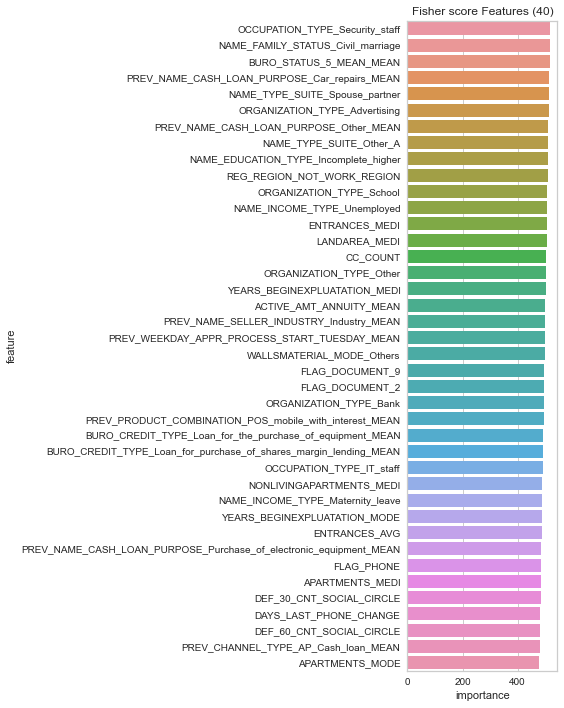

In [117]:
result_fisherf=selectionfeats_plot(feat_fisher, "FisherScore", "Fisher score")

In [118]:
result_fisherf

importance   rank
feature                                              
ACTIVE_AMT_ANNUITY_MEAN                  501.0  502.0
ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN       367.0  368.0
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN          322.0  323.0
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN          35.0   36.0
ACTIVE_AMT_CREDIT_SUM_MEAN               345.0  346.0
...                                        ...    ...
YEARS_BEGINEXPLUATATION_MEDI             502.0  503.0
YEARS_BEGINEXPLUATATION_MODE             488.0  489.0
YEARS_BUILD_AVG                          170.0  171.0
YEARS_BUILD_MEDI                          12.0   13.0
YEARS_BUILD_MODE                         460.0  461.0

[519 rows x 2 columns]

### LGBM

Pour rappel, voici les features sélectionnées par le lgbm

In [191]:
feat_importances=feat_importances.reset_index()

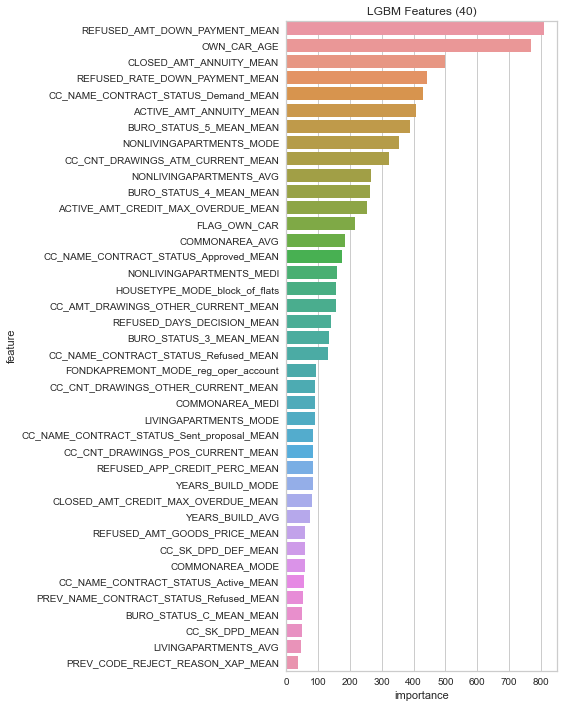

In [192]:
result_lgbm=selectionfeats_plot(feat_importances, "LGBM", "LGBM")

## Comparons les résultats entre les différentes méthodes de sélection


Regardons s'il y a des variables communes

In [121]:
result_mutual

importance   rank
feature                                              
ACTIVE_AMT_ANNUITY_MEAN               0.240554  513.0
ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN    0.186777  455.0
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN       0.095689  421.0
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN      0.112644  423.0
ACTIVE_AMT_CREDIT_SUM_MEAN            0.086754  411.0
...                                        ...    ...
YEARS_BEGINEXPLUATATION_MEDI          0.159351  440.0
YEARS_BEGINEXPLUATATION_MODE          0.159243  438.0
YEARS_BUILD_AVG                       0.211142  491.0
YEARS_BUILD_MEDI                      0.210621  490.0
YEARS_BUILD_MODE                      0.211743  493.0

[519 rows x 2 columns]

In [124]:
df_mutual_anova = pd.concat([result_mutual, result_anovaf], 
                   axis='columns', keys=['mutual', 'anovaf'])

In [127]:
df_all["mutual"]["rank"]

feature
ACTIVE_AMT_ANNUITY_MEAN               513.0
ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN    455.0
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN       421.0
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN      423.0
ACTIVE_AMT_CREDIT_SUM_MEAN            411.0
                                      ...  
YEARS_BEGINEXPLUATATION_MEDI          440.0
YEARS_BEGINEXPLUATATION_MODE          438.0
YEARS_BUILD_AVG                       491.0
YEARS_BUILD_MEDI                      490.0
YEARS_BUILD_MODE                      493.0
Name: rank, Length: 519, dtype: float64

In [130]:
df_all['rank_match'] = np.where(df_all["mutual"]["rank"] == df_all["anovaf"]["rank"], 1, 0)

In [131]:
df_all['rank_match'].sum()

0

In [133]:
df_all.loc[pd.isna(df_all["anovaf"]["rank"])==False]["mutual"]["rank"].mean()

381.03

In [135]:
df_all.shape[0]

519

In [212]:
def compare_selection_method(df1, df2, key1, key2, moy):
    df_all = pd.concat([df1, df2], 
                   axis='columns', keys=[key1,key2])
    total=df_all.shape[0]
    df_all['rank_match'] = np.where(df_all[key1]["rank"] == df_all[key2]["rank"], 1, 0)
    print("nombre de features identiques: ",df_all['rank_match'].sum())
    print("% features identiques: ",float(df_all['rank_match'].sum()/total))
    if df_all['rank_match'].sum()>0:
        display(df_all.loc[df_all['rank_match']==True])
    if moy==1:
        moy=df_all.loc[pd.isna(df_all[key2]["rank"])==False][key1]["rank"].mean()
        display("moyenne des rangs de "+key1+" (variables présentes dans les 2 df): ",moy)

In [213]:
compare_selection_method(result_mutual, result_anovaf,  "mutual", "anovaf",1)

nombre de features identiques:  0
% features identiques:  0.0


'moyenne des rangs de mutual (variables présentes dans les 2 df): '

381.03

In [214]:
compare_selection_method(result_mutual, result_fisherf,  "mutual", "fisherf",0)

nombre de features identiques:  2
% features identiques:  0.0038535645472061657


mutual           fisherf         \
                                   importance   rank importance   rank   
feature                                                                  
PREV_NAME_PRODUCT_TYPE_walkin_MEAN   0.013205  295.0      294.0  295.0   
PREV_PRODUCT_COMBINATION_Cash_MEAN   0.013333  303.0      302.0  303.0   

                                   rank_match  
                                               
feature                                        
PREV_NAME_PRODUCT_TYPE_walkin_MEAN          1  
PREV_PRODUCT_COMBINATION_Cash_MEAN          1

In [215]:
compare_selection_method(result_fisherf, result_anovaf,  "fisherf", "anovaf",1)

nombre de features identiques:  0
% features identiques:  0.0


'moyenne des rangs de fisherf (variables présentes dans les 2 df): '

255.36

Comparons les selections avec celles du lgbm

In [216]:
compare_selection_method(result_mutual, result_lgbm,  "mutual", "lgbm",0)

nombre de features identiques:  2
% features identiques:  0.0038535645472061657


mutual              lgbm         \
                                 importance   rank importance   rank   
feature                                                                
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN   0.237248  511.0      321.6  511.0   
REFUSED_AMT_DOWN_PAYMENT_MEAN      0.260556  519.0      810.7  519.0   

                                 rank_match  
                                             
feature                                      
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN          1  
REFUSED_AMT_DOWN_PAYMENT_MEAN             1

In [218]:
compare_selection_method(result_lgbm, result_anovaf,  "lgbm", "anovaf",1)

nombre de features identiques:  0
% features identiques:  0.0


'moyenne des rangs de lgbm (variables présentes dans les 2 df): '

372.495

In [219]:
compare_selection_method(result_fisherf, result_lgbm,  "fisherf", "lgbm",0)

nombre de features identiques:  1
% features identiques:  0.0019267822736030828


fisherf              lgbm        rank_match
               importance   rank importance   rank           
feature                                                      
ELEVATORS_MEDI      446.0  447.0        9.6  447.0          1

In [264]:
df_all = pd.concat([result_lgbm, result_mutual, result_anovaf, result_fisherf], 
                   axis='columns', keys=["lgbm","mutual", "anovaf","fisherf"])

Nous mettons dernier les variables avec un rank vide.

In [265]:
df_all=df_all.fillna(519)

In [266]:
df_all=df_all.reset_index()

In [267]:
df_all["avg_rank"]=(df_all["lgbm"]["rank"]+df_all["mutual"]["rank"]+df_all["anovaf"]["rank"]+df_all["fisherf"]["rank"])/4

In [268]:
df_all["rank_total"]=df_all["avg_rank"].rank()

In [269]:
cols = df_all[["feature", "rank_total"]].groupby("feature").mean().sort_values(by="rank_total", ascending=True)[:100].index
selection_features = df_all.loc[df_all.feature.isin(cols)]

Il manque une connaissance métier pour pouvoir faire une sélection plus pertinente ici.
Nous allons calculer la moyenne des rank pour les 3 scores et choisir les meilleurs features.

Pour déterminer quelles caractéristiques doivent être éliminées, nous pouvons rechercher les caractéristiques avec des valeurs de facteur d'inflation à variance élevée (VIF) et les supprimer.
Remarque : En règle générale, une valeur VIF de 10 ou plus est considérée comme trop élevée.

In [271]:
selection_features

feature       lgbm            mutual         \
                                         importance   rank importance   rank   
12                       AMT_GOODS_PRICE        0.2  338.5   0.005536  171.0   
23             APPROVED_AMT_ANNUITY_MEAN        0.0  156.5   0.014600  337.0   
30           APPROVED_DAYS_DECISION_MEAN        0.1  323.5   0.014985  342.0   
61       BURO_CREDIT_TYPE_Microloan_MEAN        0.0  156.5   0.047862  387.0   
115                         CNT_CHILDREN        0.0  156.5   0.002893  159.0   
..                                   ...        ...    ...        ...    ...   
496           REG_REGION_NOT_LIVE_REGION        0.0  156.5   0.000412  111.0   
501        WALLSMATERIAL_MODE_Monolithic        0.0  156.5   0.000000   31.5   
507    WEEKDAY_APPR_PROCESS_START_MONDAY        0.0  156.5   0.001608  145.0   
509    WEEKDAY_APPR_PROCESS_START_SUNDAY        0.0  156.5   0.000000   31.5   
510  WEEKDAY_APPR_PROCESS_START_THURSDAY        0.0  156.5   0.001156  137.0   

         anovaf           fisherf        avg_rank rank_total  
     importance   rank importance   rank                      
12   331.173833   12.0      248.0  249.0  192.625       26.0  
23   432.812710   31.0      411.0  412.0  234.125       98.0  
30   323.639597   10.0       55.0   56.0  182.875       19.0  
61   513.129345   46.0       60.0   61.0  162.625       13.0  
115  519.000000  519.0       17.0   18.0  213.125       64.0  
..          ...    ...        ...    ...      ...        ...  
496  519.000000  519.0       13.0   14.0  200.125       37.0  
501  519.000000  519.0      162.0  163.0  217.500       74.0  
507  519.000000  519.0       28.0   29.0  212.375       63.0  
509  519.000000  519.0       32.0   33.0  185.000       20.0  
510  519.000000  519.0       21.0   22.0  208.625       55.0  

[100 rows x 11 columns]

In [272]:
df_vif=df.copy()

In [251]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# compute the vif for all given features
def compute_vif(considered_features, df):
    
    df=update_nan_inf(df, "TARGET", "mean")
    X = df.loc[:,considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

#considered_features = ['land_size_sqm', 'house_size_sqm', 'no_of_rooms']
#compute_vif(considered_features)

In [273]:
result_vif=compute_vif(selection_features.feature, df_vif)

nan: False
infinity: True


Plus de 10 considéré comme beaucoup
Nous conservons les variables avec un vif en dessous de 10.

In [274]:
selection_features=result_vif["Variable"].loc[result_vif["VIF"]<10]

In [276]:
selection_features.shape

(91,)

Nous avons supprimé 9 variables.

Vérifions si des variables sont corrélées.

In [277]:
correlation_features=df.copy()

In [278]:
correlation_features=correlation_features.loc[:,selection_features]

AMT_GOODS_PRICE  \
AMT_GOODS_PRICE                             1.000000   
APPROVED_AMT_ANNUITY_MEAN                   0.226570   
APPROVED_DAYS_DECISION_MEAN                -0.082957   
BURO_CREDIT_TYPE_Microloan_MEAN            -0.038083   
CNT_CHILDREN                                0.002251   
...                                              ...   
REG_REGION_NOT_LIVE_REGION                  0.024946   
WALLSMATERIAL_MODE_Monolithic               0.028666   
WEEKDAY_APPR_PROCESS_START_MONDAY          -0.003502   
WEEKDAY_APPR_PROCESS_START_SUNDAY           0.001761   
WEEKDAY_APPR_PROCESS_START_THURSDAY         0.003348   

                                     APPROVED_AMT_ANNUITY_MEAN  \
AMT_GOODS_PRICE                                       0.226570   
APPROVED_AMT_ANNUITY_MEAN                             1.000000   
APPROVED_DAYS_DECISION_MEAN                           0.126664   
BURO_CREDIT_TYPE_Microloan_MEAN                      -0.016185   
CNT_CHILDREN                                         -0.046123   
...                                                        ...   
REG_REGION_NOT_LIVE_REGION                            0.016838   
WALLSMATERIAL_MODE_Monolithic                         0.035144   
WEEKDAY_APPR_PROCESS_START_MONDAY                     0.004547   
WEEKDAY_APPR_PROCESS_START_SUNDAY                    -0.004105   
WEEKDAY_APPR_PROCESS_START_THURSDAY                   0.001059   

                                     APPROVED_DAYS_DECISION_MEAN  \
AMT_GOODS_PRICE                                        -0.082957   
APPROVED_AMT_ANNUITY_MEAN                               0.126664   
APPROVED_DAYS_DECISION_MEAN                             1.000000   
BURO_CREDIT_TYPE_Microloan_MEAN                         0.026982   
CNT_CHILDREN                                            0.006038   
...                                                          ...   
REG_REGION_NOT_LIVE_REGION                              0.034489   
WALLSMATERIAL_MODE_Monolithic                           0.005138   
WEEKDAY_APPR_PROCESS_START_MONDAY                       0.000189   
WEEKDAY_APPR_PROCESS_START_SUNDAY                       0.005170   
WEEKDAY_APPR_PROCESS_START_THURSDAY                     0.000568   

                                     BURO_CREDIT_TYPE_Microloan_MEAN  \
AMT_GOODS_PRICE                                            -0.038083   
APPROVED_AMT_ANNUITY_MEAN                                  -0.016185   
APPROVED_DAYS_DECISION_MEAN                                 0.026982   
BURO_CREDIT_TYPE_Microloan_MEAN                             1.000000   
CNT_CHILDREN                                               -0.009447   
...                                                              ...   
REG_REGION_NOT_LIVE_REGION                                 -0.001475   
WALLSMATERIAL_MODE_Monolithic                              -0.003093   
WEEKDAY_APPR_PROCESS_START_MONDAY                          -0.000843   
WEEKDAY_APPR_PROCESS_START_SUNDAY                          -0.004845   
WEEKDAY_APPR_PROCESS_START_THURSDAY                         0.002284   

                                     CNT_CHILDREN  CODE_GENDER  DAYS_BIRTH  \
AMT_GOODS_PRICE                          0.002251    -0.018228   -0.051356   
APPROVED_AMT_ANNUITY_MEAN               -0.046123    -0.004228   -0.112686   
APPROVED_DAYS_DECISION_MEAN              0.006038    -0.004382    0.106186   
BURO_CREDIT_TYPE_Microloan_MEAN         -0.009447    -0.005533   -0.002625   
CNT_CHILDREN                             1.000000    -0.048264    0.329197   
...                                           ...          ...         ...   
REG_REGION_NOT_LIVE_REGION              -0.013525    -0.023944    0.065835   
WALLSMATERIAL_MODE_Monolithic            0.001703    -0.005451    0.004563   
WEEKDAY_APPR_PROCESS_START_MONDAY        0.004356    -0.000100    0.001592   
WEEKDAY_APPR_PROCESS_START_SUNDAY        0.006075    -0.007227    0.030629   
WEEKDAY_APPR_PROCESS_START_THUR

Text(62.953124999999986, 0.5, 'Variables')

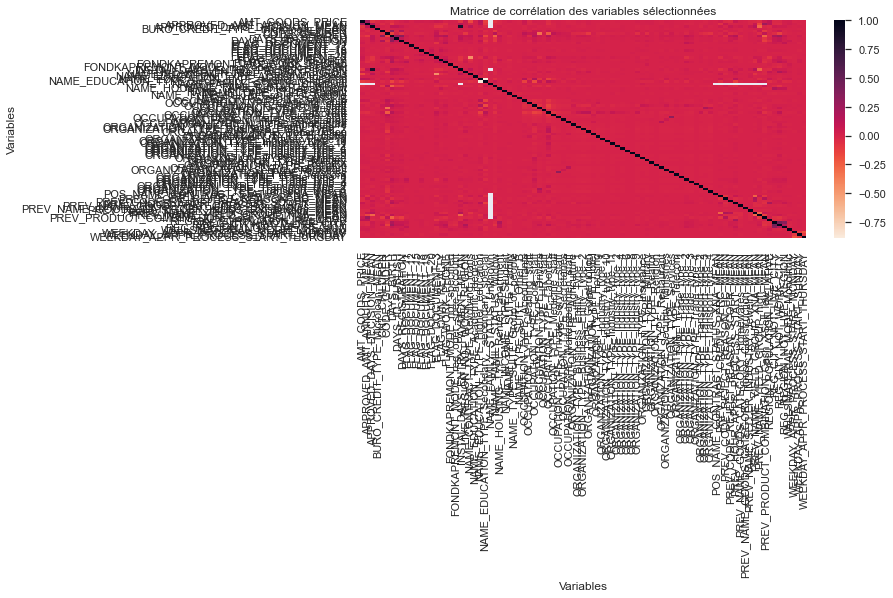

In [285]:
sns.set(rc={'figure.figsize':(10,4)})

data_corr = correlation_features.corr()

display(data_corr)
ax = sns.heatmap(data_corr, xticklabels = data_corr.columns , 
                 yticklabels = data_corr.columns, cmap = 'rocket_r')
plt.title("Matrice de corrélation des variables sélectionnées")

plt.xlabel("Variables")

plt.ylabel("Variables")


Nous observons des variables fortement corrélées. Regardons les de plus près grâce à une boucle.

In [286]:
correlations=data_corr.reset_index()

In [288]:
j=0
for i in correlations.columns:
    if j in range(0,len(correlations)-1):
        if i!="index":
            if (i!=correlations["index"][j])==True & (correlations[i] is not None)==True:
                if abs(correlations[i][j])>0.5:
                    print("var correle : "+i+" - "+correlations["index"][j] + "- value : "+str(correlations[i][j]))
        j+=1
    else:
        break
    

var correle : NAME_EDUCATION_TYPE_Higher_education - NAME_EDUCATION_TYPE_Secondary__secondary_special- value : -0.8885848662368101


Nous observons que les deux variables qui apportent la même information portent sur les études.
L'une d'elle apporte une information supplémentaire sur le type d'étude secondaire. Nous pouvons la supprimer et conserver la première variables.


In [290]:
selection_features

0                         AMT_GOODS_PRICE
1               APPROVED_AMT_ANNUITY_MEAN
2             APPROVED_DAYS_DECISION_MEAN
3         BURO_CREDIT_TYPE_Microloan_MEAN
4                            CNT_CHILDREN
                     ...                 
95             REG_REGION_NOT_LIVE_REGION
96          WALLSMATERIAL_MODE_Monolithic
97      WEEKDAY_APPR_PROCESS_START_MONDAY
98      WEEKDAY_APPR_PROCESS_START_SUNDAY
99    WEEKDAY_APPR_PROCESS_START_THURSDAY
Name: Variable, Length: 91, dtype: object

In [291]:
selection_features.drop(selection_features.loc[selection_features=='NAME_EDUCATION_TYPE_Secondary__secondary_special'].index, inplace=True)

In [292]:
selection_features.shape

(90,)

Nous utiliserons cette sélection de variable pour notre recherche de modèle et les variables qui ressortent du LGBM.

Création d'un fonction pour la sélection des features pour alimenter notre package

In [ ]:
def step0_features(quanti, option_feature, X, Y, k_nb=40, chi_k=0):
    if quanti==1:
        if option_feature==1:
            features=pipeline_mutual_info_classif(X, Y)
        elif option_feature==2:
            features=pipeline_anova_f(X, Y, k_nb)
        elif option_feature==3:
            features=pipeline_fisher_score(X, Y)
        #elif option_feature==4:
         #   features=pipeline_forward_select(X, Y, k_feat, scoring_name, cv_nb)
    elif quanti==0:
        features=pipeline_chi2(X, Y, chi_k)
    return features

# Baseline

Pour voir si nous pouvons trouver un meilleur modèle que le LGBM, il faut le comparer à un autre. Nous pouvons utiliser différentes méthodes : la regression logistique, random forest, gradient boost.

Nous pouvons créer un pipeline afin de comparer les différentes méthodes et trouver le meilleur modèle.

Voici les différentes étapes du pipeline :
- 1) Selection features de départ (pour les méthodes comme la regression logistique qui ne trouve pas les meilleurs variables contrairement au Random forest)
- 2) Diviser le jeu de données en train, test
- 3) Diviser le train en fold : train et validation
- 4) Appliquer le SMOTE (sur le train seulement)
- 5) Boucle sur les folds et Tuning des modèles sur le train : best modèle en fonction de la métrique métier
- 6) Sauvegarder le meilleur modèle à chaque fois grâce à la moyenne de la métrique métier
- 7) Et tester notre selection de features et refaire l'étape 1.
- 8) Comparer tous les modèles

### Création d'une fonction de chaque méthode pour le pipeline

In [527]:
data=df[df["TARGET"].notnull()]
Y=data["TARGET"]
cols = data.columns[~data.columns.isin(['TARGET'])]
X=data[cols]


In [528]:
X

index  SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
1770   1770      102072            0             0                0   
5562   5562      106511            0             1                0   
9958   9958      111588            0             0                0   
1233   1233      101456            0             0                1   
2677   2677      103124            0             0                0   
...     ...         ...          ...           ...              ...   
184     184      100214            0             0                0   
7573   7573      108833            1             0                1   
6127   6127      107162            1             0                1   
4598   4598      105379            0             0                0   
1287   1287      101516            0             0                0   

      CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
1770             2           99000.0    523597.5      22311.0   
5562             0           67500.0   1546020.0      42642.0   
9958             0          180000.0    675000.0      50598.0   
1233             0          112500.0    382500.0      25033.5   
2677             0           90000.0    566055.0      16681.5   
...            ...               ...         ...          ...   
184              1          202500.0    436032.0      28516.5   
7573             0          103500.0    225000.0      12577.5   
6127             0          112500.0    269982.0      32170.5   
4598             2          189000.0    896647.5      45909.0   
1287             0           90000.0    390447.0      18333.0   

      AMT_GOODS_PRICE  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
1770         468000.0  ...                                 NaN   
5562        1350000.0  ...                                 NaN   
9958         675000.0  ...                                 NaN   
1233         382500.0  ...                                 NaN   
2677         472500.0  ...                                 NaN   
...               ...  ...                                 ...   
184          360000.0  ...                                 NaN   
7573         225000.0  ...                                 NaN   
6127         238500.0  ...                                 NaN   
4598         787500.0  ...                                 NaN   
1287         274500.0  ...                                 NaN   

      CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
1770                                  NaN                                 NaN   
5562                                  NaN                                 NaN   
9958                                  NaN                                 NaN   
1233                                  NaN                                 NaN   
2677                                  NaN                                 NaN   
...                                   ...                                 ...   
184                                   NaN                                 NaN   
7573                                  NaN                                 NaN   
6127                                  NaN                                 NaN   
4598                                  NaN                                 NaN   
1287                                  NaN                                 NaN   

      CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
1770                                 NaN                              NaN   
5562                                 NaN                              NaN   
9958                                 NaN                              NaN   
1233                                 NaN                              NaN   
2677                                 NaN                              NaN   
...                                  ...                              ...   
184                                  NaN                           

In [362]:
def pipeline_divide_data(df, target):
    data=df[df[target].notnull()]
    Y=data[target]
    cols = data.columns[~data.columns.isin(['TARGET'])]
    X=data[cols]
    X=X.fillna(X.mean())
    return X,Y

def pipeline_mutual_info_classif(X,Y):
    importances =mutual_info_classif(X,Y)
    feat_importances = pd.Series(importances, X.columns[0:len(X.columns)])
    feat_importances.plot(kind='barh', color='teal')
    plt.show()
    ft = feat_importances.to_frame(name="importance").reset_index()
    ft=ft.rename(columns={"index": "feature", "importance":"importance"})
    return ft

def pipeline_anova_f(X,Y, nb_k):
    # define feature selection
    fs = SelectKBest(score_func=f_classif, k=nb_k)
    # apply feature selection
    X_selected = fs.fit_transform(X, Y)
    names = X.columns.values[fs.get_support()]
    scores = fs.scores_[fs.get_support()]
    names_scores = list(zip(names, scores))
    ns_df = pd.DataFrame(data = names_scores, columns=['feature', 'importance'])
    #Sort the dataframe for better visualization
    ns_df_sorted = ns_df.sort_values(['feature', 'importance'], ascending = [False, True])
    print(ns_df_sorted)
    sns.barplot(x="importance", y="feature", data=ns_df_sorted,
                label="importance", color="b")
    plt.show()
    return ns_df_sorted

#pipeline_chi2(X,Y, 20) (cat en int)
def pipeline_chi2(X,Y, k_nb):
    # categorielle en int
    chi2_features = SelectKBest(chi2, k=20)
    X_kbest_features = chi2_features.fit_transform(X, Y)
    print("Original feature number:",X.shape[1])
    print("Reduced feature number:", X_kbest_features.shape[1])
    cols = chi2_features.get_support(indices=True)
    features_df_new = df.iloc[:,cols]
    return features_df_new.columns

def pipeline_fisher_score(X_values, Y):
    importances =fisher_score.fisher_score(X_values.values,Y)
    final_df=pd.DataFrame({"feature": pd.DataFrame(X_values).columns,"importance":importances})
    final_df.set_index("importance")
    final_df = final_df.sort_values("importance")
    final_df.plot.bar(color="teal")
    print(plt.show())
    return final_df

# pipeline_forward_select(X,Y, 50,'roc_auc', 4)
def pipeline_forward_select(X,Y, k_feat,scoring_name, cv_nb):
    forward_feature_selector = SequentialFeatureSelector(RandomForestRegressor(n_jobs=-1),
           k_features=k_feat,
           forward=True,
           verbose=2,
           scoring=scoring_name,
           cv=cv_nb)
    fselector = forward_feature_selector.fit(X,Y)
    return fselector


### classer en quali-quanti, quali-quali, quanti-quanti, quanti-quali

### Fonction pour l'équilibrage des classes

Nous avons vu que la target était déséquilibrée, créons des fonctions pour corriger ce soucis comme nous l'avons fait dans le kaggle.

#### SMOTE

In [99]:
def pipeline_smote(X,Y):
    counter = Counter(Y)
    print(counter)
    oversample = SMOTE()
    X_s, y_s = oversample.fit_resample(X, Y)
    counter = Counter(y_s)
    print("new Y : ", counter)
    return X_s, y_s

(1972,)

#### Undersampling

Here, distance is determined in feature space using Euclidean distance or similar.

NearMiss-1: Majority class examples with minimum average distance to three closest minority class examples.
NearMiss-2: Majority class examples with minimum average distance to three furthest minority class examples.
NearMiss-3: Majority class examples with minimum distance to each minority class example.

test deNearMiss-3 :  NearMiss-3 qui sélectionne les exemples les plus proches de la classe majoritaire pour chaque classe minoritaire.

In [384]:
from imblearn.under_sampling import NearMiss


Counter({1.0: 9225, 0.0: 9225})


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:175: UserWarning:

The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.



In [296]:
def pipeline_undersampling(X,Y):
    # define the undersampling method
    undersample = NearMiss(version=3, n_neighbors=3)
    # transform the dataset
    X_u, y_u = undersample.fit_resample(X, Y)
    # summarize the new class distribution
    counter = Counter(y_u)
    print(counter)
    return X_u, y_u

Nous allons tester les deux méthodes.

Nous avons créé une fonction avec gridsearchcv, cependant, ici nous ne pouvons pas utiliser cette méthode car nous avons besoin d'appliquer le smote sur une partie des folds.

In [101]:
def pipeline_gridsearchcv(model_i, X_train, y_train, param_grid, fold_i, score_i):
    # Fixer les valeurs des hyperparamètres à tester
    #param_grid = {'n_neighbors':[630,650,655,658,660,670,700,750]}

    # Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
    score = score_i

    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    clf = model_selection.GridSearchCV(
        model_i, # un classifieur kNN
        param_grid,     # hyperparamètres à tester
        cv=fold_i,           # nombre de folds de validation croisée
        scoring=score   # score à optimiser
    )

    # Optimiser ce classifieur sur le jeu d'entraînement
    clf.fit(X_train, y_train)

    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(clf.best_params_)


    # Afficher les performances correspondantes
    print("Résultats de la validation croisée :")
    for mean, std, params in zip(
            clf.cv_results_['mean_test_score'], # score moyen
            clf.cv_results_['std_test_score'],  # écart-type du score
            clf.cv_results_['params']           # valeur de l'hyperparamètre
        ):

        print("{} = {:.3f} (+/-{:.03f}) for {}".format(
            score,
            mean,
            std*2,
            params
        ) )


#### Création des fonctions pour comparer les modèles avec la métrique métier. Nous utiliserons hyperopt pour le tuning des hyperparamètres. 

In [293]:
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from functools import partial


########################manque ajoute std

####score pour fonction metier
def score_metier(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.9+FP*0.1)/(FN*0.9+FP*0.1+TN+TP)
    
    print('FULL Métrique Métier : ', metier)
    return metier


###creation de fonction pour le tuning des hyperparamètres
def objective(params, feats, n_fold, X_train_fold_upsample, y_train_fold_upsample, X_val_fold, y_val_fold):
    print("params : ", params)
    classifier_type = params['type']
    del params['type']
    #del params['type']
    if classifier_type == 'svm':
        clf = SVC(**params)
    if classifier_type == 'rff':
        clf = RandomForestClassifier(**params)
        X_train=X_train.loc[:,feats]
    elif classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif classifier_type == 'logreg':
        clf = LogisticRegression(**params)
        X_train=X_train.loc[:,feats]
    else:
        return 0
    

    scorer = make_scorer(score_metier)
    #cross_val_score(imba_pipeline, X_train, y_train, scoring=scorer, cv=kf)
    model_obj = clf.fit(X_train_fold_upsample, y_train_fold_upsample)
        # faux car on utilise deja smote : model_obj = model(**params, class_weight={0: .1, 1: .9}).fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
    y_prob = model_obj.predict_proba(X_val_fold)[:,1] 
        # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(y_prob > 0.5, 1, 0) 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val_fold, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(plot_roc_curve(true_positive_rate,false_positive_rate))
        #score = metrics.recall_score(y_val_fold, model_obj.predict(X_val_fold))

    
    print("score ", roc_auc)

    # Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': roc_auc, 'status': STATUS_OK}


search_space = hp.choice('classifier_type', [
    
    {
        'type': 'rf',
        'max_depth': hp.quniform('max_depth', 2, 5, 1)
       # 'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
    {
        'type': 'logreg',
        'C': hp.lognormal('LR_C', 0, 1.0),
        'solver': hp.choice('solver', ['liblinear', 'lbfgs'])
    },
])


#Nous allons restreindre les colonnes sur la regression logistique, nous testerons les features obtenues grâce aux méthodes statistiques et celles sorties via le LGBM.
def score_model(X_train, y_train,feats, cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=5, random_state=20)

    smoter = SMOTE(random_state=20)
    
    scores = []

    n_fold=0
    for feat in params_feats:
        for train_fold_index, val_fold_index in cv.split(X_train, y_train):
            # Get the training data
            X_train_fold = X_train.iloc[train_fold_index]
            y_train_fold = y_train.iloc[train_fold_index]
            # Get the validation data
            X_val_fold = X_train.iloc[val_fold_index]
            y_val_fold = y_train.iloc[val_fold_index]

            # Upsample only the data in the training section
            X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                               y_train_fold)
            # Fit the model on the upsampled training data
           # model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)

            ###hyperopt tuning
            with mlflow.start_run():
                  best_result = fmin(
                                        partial(objective, feats=feat,n_fold=n_fold,
                                                X_train_fold_upsample=X_train_fold_upsample, 
                                                y_train_fold_upsample=y_train_fold_upsample, 
                                                X_val_fold=X_val_fold, 
                                                y_val_fold=y_val_fold),
                                        space=search_space,
                                        algo=tpe.suggest,
                                        max_evals=32
                                        #trials=SparkTrials()
                  )

            scores.append(best_result)
    return np.array(scores)
# Example of the model in action
#score_model(RandomForestClassifier, example_params, cv=kf)

In [356]:
def step1_ech(df, target):
    X, Y = pipeline_divide_data(df, target)
    #ajout std
    
    X_train, X_test, y_train, y_test = pipelineModel_TrainingSet(X, Y, 0, 0.3)
    return X_train, X_test, y_train, y_test

In [354]:
def filter_features(k, df, feat_importance):
    print(feat_importance.columns)
    cols = feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:k].index
    best_features = feat_importance["feature"].loc[feat_importance.feature.isin(cols)]
    #best_features.sort_values(by="importance", ascending=False)
    feat_importances=best_features.unique()
    feat_importances2=list(feat_importances)
    feat_importances2.append("TARGET")
    feat_importances2.append("SK_ID_CURR")
    df_new=df.loc[:,feat_importances2]
    return df_new

In [480]:
def SearchModel(df, params_feats, target, kf):
    feat_importance_init=params_feats[0]
    params_feats=params_feats[1,:]
    df_new=filter_features(100, df, feat_importance_init)
    X_train, X_test, y_train, y_test=step1_ech(df_new, target)
    print("------------After selection features : ")
    print("X_train shape : ", X_train.shape)
    print("y_train shape : ", y_train.shape)
    print("X_test shape : ", X_test.shape)
    print("y_test shape : ", y_test.shape)
    result=score_model(X_train, y_train,params_feats, cv=kf)
    return result

In [306]:
feat_importance

feature  importance  fold
0                                   CODE_GENDER          20     1
1                                  FLAG_OWN_CAR         225     1
2                               FLAG_OWN_REALTY           0     1
3                                  CNT_CHILDREN           0     1
4                              AMT_INCOME_TOTAL           0     1
..                                          ...         ...   ...
534        CC_NAME_CONTRACT_STATUS_Refused_MEAN         145    10
535  CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN          63    10
536         CC_NAME_CONTRACT_STATUS_Signed_MEAN          31    10
537            CC_NAME_CONTRACT_STATUS_nan_MEAN           0    10
538                                    CC_COUNT           6    10

[5390 rows x 3 columns]

## Utilisation du pipeline et test des modèles

In [ ]:
params_feats=[]
params_feats.append(feat_lgbm)
params_feats.append(selectfeatures)

Index(['feature', 'importance'], dtype='object')
------------After selection features : 
X_train shape :  (6019, 101)
y_train shape :  (6019,)
X_test shape :  (2580, 101)
y_test shape :  (2580,)
params :                                              
{'max_depth': 4.0, 'type': 'rf'}                      
  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

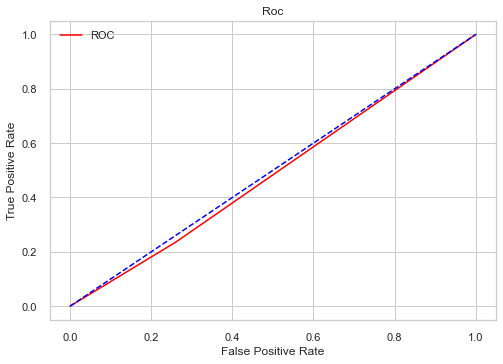

None                                                  
score                                                 
0.5124285499398316                                    
params :                                                                        
{'C': 1.7232867513091048, 'solver': 'lbfgs', 'type': 'logreg'}                  
  3%|▎         | 1/32 [00:00<00:12,  2.50trial/s, best loss: 0.5124285499398316]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




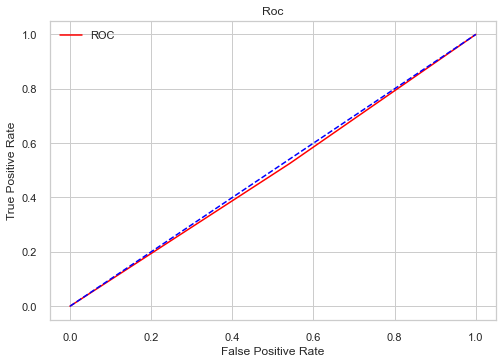

None                                                                            
score                                                                           
0.5081979542719615                                                              
params :                                                                        
{'C': 2.2588218402854747, 'solver': 'lbfgs', 'type': 'logreg'}                  
  6%|▋         | 2/32 [00:00<00:09,  3.04trial/s, best loss: 0.5081979542719615]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




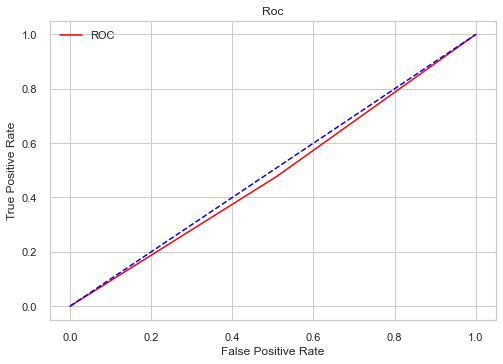

None                                                                            
score                                                                           
0.5160386582430805                                                              
params :                                                                        
{'max_depth': 3.0, 'type': 'rf'}                                                
  9%|▉         | 3/32 [00:01<00:09,  3.09trial/s, best loss: 0.5081979542719615]

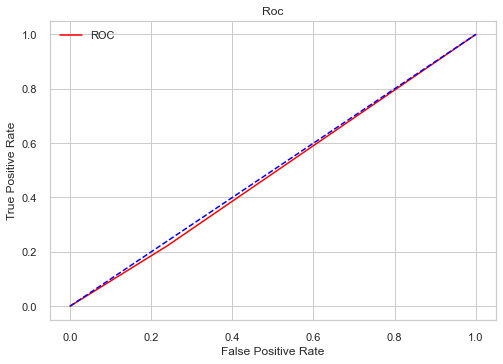

None                                                                            
score                                                                           
0.5087808363417569                                                              
params :                                                                        
{'max_depth': 4.0, 'type': 'rf'}                                                
 12%|█▎        | 4/32 [00:01<00:11,  2.44trial/s, best loss: 0.5081979542719615]

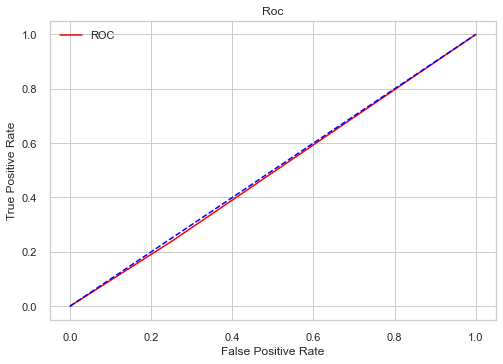

None                                                                            
score                                                                           
0.5058664259927798                                                              
params :                                                                        
{'max_depth': 3.0, 'type': 'rf'}                                                
 16%|█▌        | 5/32 [00:02<00:12,  2.08trial/s, best loss: 0.5058664259927798]

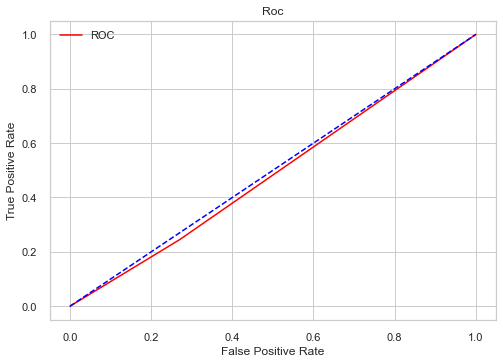

None                                                                            
score                                                                           
0.5126729843561973                                                              
params :                                                                        
{'max_depth': 5.0, 'type': 'rf'}                                                
 19%|█▉        | 6/32 [00:02<00:12,  2.10trial/s, best loss: 0.5058664259927798]

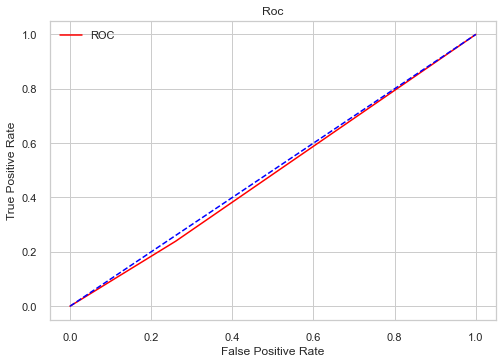

None                                                                            
score                                                                           
0.510623495788207                                                               
params :                                                                        
{'max_depth': 4.0, 'type': 'rf'}                                                
 22%|██▏       | 7/32 [00:03<00:12,  1.94trial/s, best loss: 0.5058664259927798]

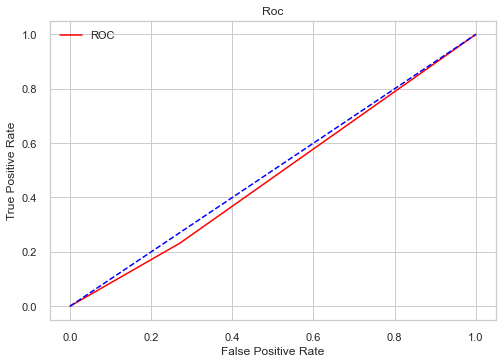

None                                                                            
score                                                                           
0.5194419374247894                                                              
params :                                                                        
{'C': 1.0590017766376199, 'solver': 'lbfgs', 'type': 'logreg'}                  
 25%|██▌       | 8/32 [00:03<00:12,  1.93trial/s, best loss: 0.5058664259927798]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




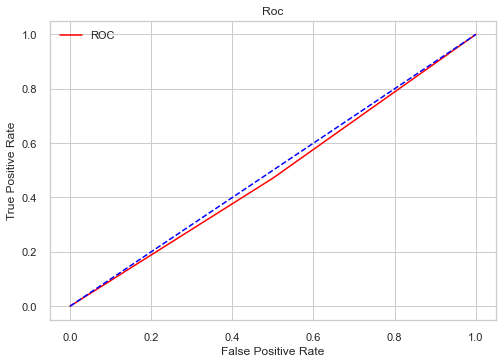

None                                                                            
score                                                                           
0.5144404332129964                                                              
params :                                                                        
{'max_depth': 4.0, 'type': 'rf'}                                                
 28%|██▊       | 9/32 [00:04<00:10,  2.24trial/s, best loss: 0.5058664259927798]

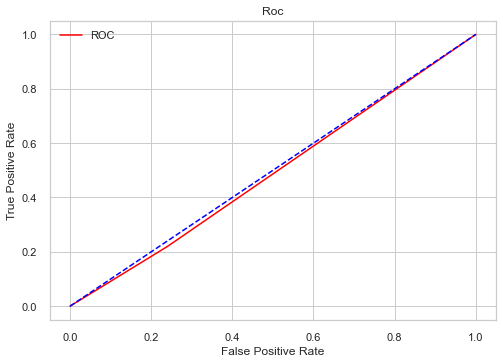

None                                                                            
score                                                                           
0.5101346269554753                                                              
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
 31%|███▏      | 10/32 [00:04<00:09,  2.23trial/s, best loss: 0.5058664259927798]

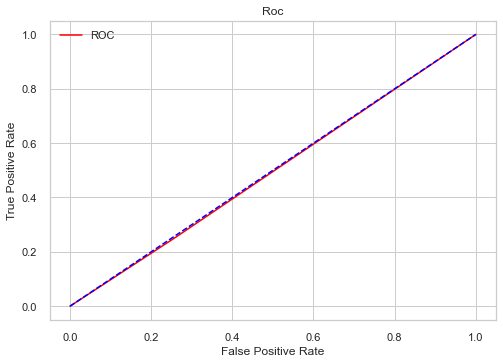

None                                                                             
score                                                                            
0.5034032791817088                                                               
params :                                                                         
{'C': 1.4682693242070184, 'solver': 'lbfgs', 'type': 'logreg'}                   
 34%|███▍      | 11/32 [00:04<00:09,  2.31trial/s, best loss: 0.5034032791817088]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




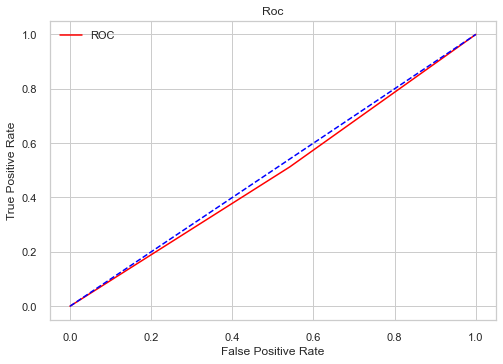

None                                                                             
score                                                                            
0.5145156438026474                                                               
params :                                                                         
{'C': 2.4390877023739366, 'solver': 'lbfgs', 'type': 'logreg'}                   
 38%|███▊      | 12/32 [00:05<00:07,  2.67trial/s, best loss: 0.5034032791817088]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




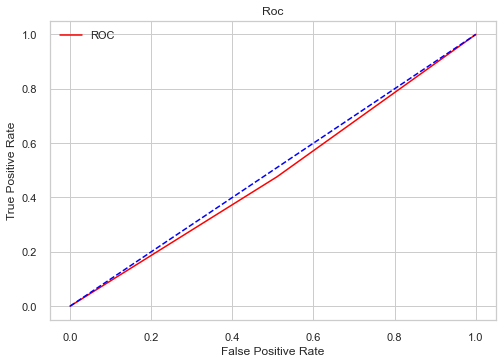

None                                                                             
score                                                                            
0.5169411853188929                                                               
params :                                                                         
{'C': 3.8455141790956655, 'solver': 'liblinear', 'type': 'logreg'}               
 41%|████      | 13/32 [00:05<00:06,  3.00trial/s, best loss: 0.5034032791817088]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




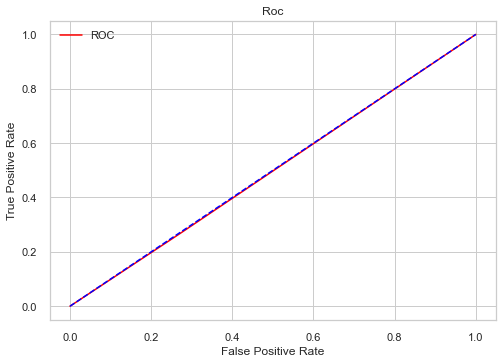

None                                                                             
score                                                                            
0.50184265944645                                                                 
params :                                                                         
{'C': 0.4614384777622048, 'solver': 'liblinear', 'type': 'logreg'}             
 44%|████▍     | 14/32 [00:06<00:10,  1.67trial/s, best loss: 0.50184265944645]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




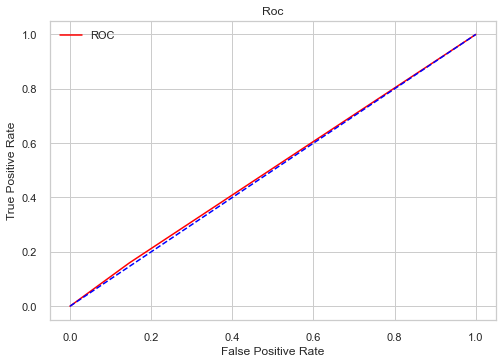

None                                                                           
score                                                                          
0.49349428399518647                                                            
params :                                                                          
{'C': 0.18964397491603815, 'solver': 'liblinear', 'type': 'logreg'}               
 47%|████▋     | 15/32 [00:08<00:16,  1.00trial/s, best loss: 0.49349428399518647]

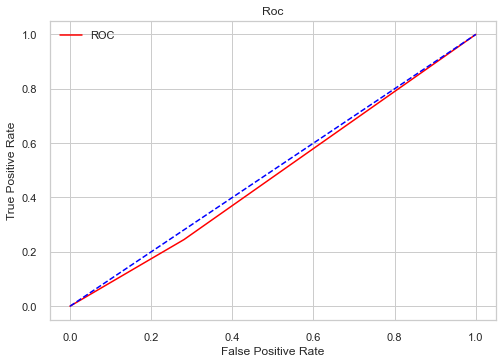

None                                                                              
score                                                                             
0.5178813176895307                                                                
params :                                                                          
{'max_depth': 3.0, 'type': 'rf'}                                                  
 50%|█████     | 16/32 [00:09<00:17,  1.11s/trial, best loss: 0.49349428399518647]

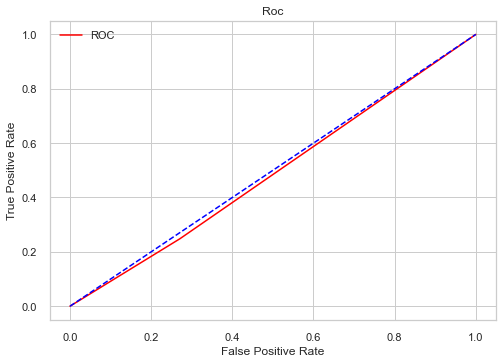

None                                                                              
score                                                                             
0.5113191937424789                                                                
params :                                                                          
{'max_depth': 4.0, 'type': 'rf'}                                                  
 53%|█████▎    | 17/32 [00:10<00:13,  1.11trial/s, best loss: 0.49349428399518647]

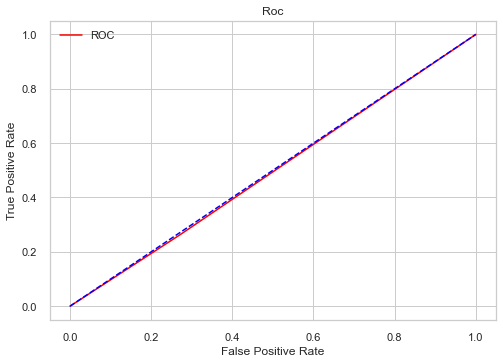

None                                                                              
score                                                                             
0.5040989771359807                                                                
params :                                                                          
{'max_depth': 5.0, 'type': 'rf'}                                                  
 56%|█████▋    | 18/32 [00:10<00:10,  1.28trial/s, best loss: 0.49349428399518647]

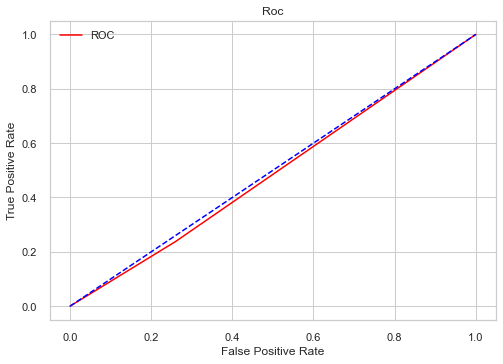

None                                                                              
score                                                                             
0.5110747593261131                                                                
params :                                                                          
{'C': 1.7571068403079741, 'solver': 'liblinear', 'type': 'logreg'}                
 59%|█████▉    | 19/32 [00:11<00:08,  1.47trial/s, best loss: 0.49349428399518647]

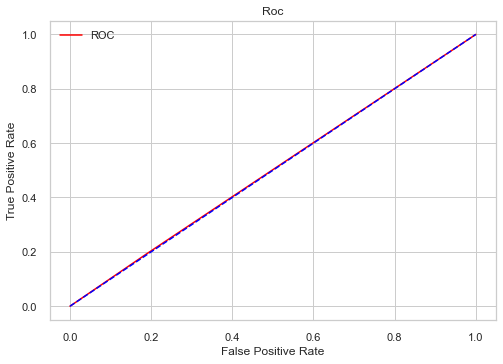

None                                                                              
score                                                                             
0.49808212996389883                                                               
params :                                                                          
{'C': 0.43583137517413717, 'solver': 'liblinear', 'type': 'logreg'}               
 62%|██████▎   | 20/32 [00:12<00:10,  1.14trial/s, best loss: 0.49349428399518647]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




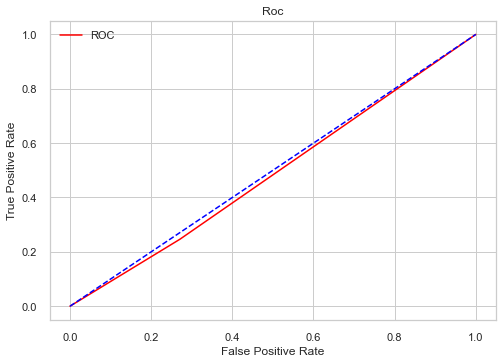

None                                                                              
score                                                                             
0.5122217208182912                                                                
params :                                                                          
{'C': 0.4879135399559285, 'solver': 'liblinear', 'type': 'logreg'}                
 66%|██████▌   | 21/32 [00:13<00:10,  1.04trial/s, best loss: 0.49349428399518647]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




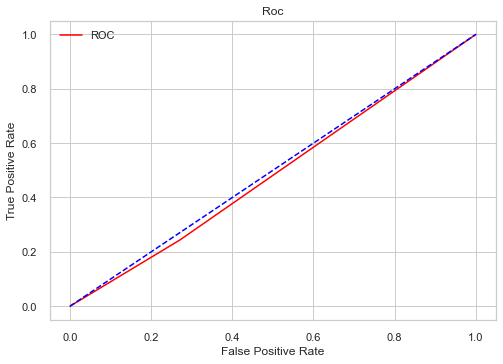

None                                                                              
score                                                                             
0.5135755114320096                                                                
params :                                                                          
{'C': 0.5476128701266086, 'solver': 'liblinear', 'type': 'logreg'}                
 69%|██████▉   | 22/32 [00:14<00:10,  1.03s/trial, best loss: 0.49349428399518647]

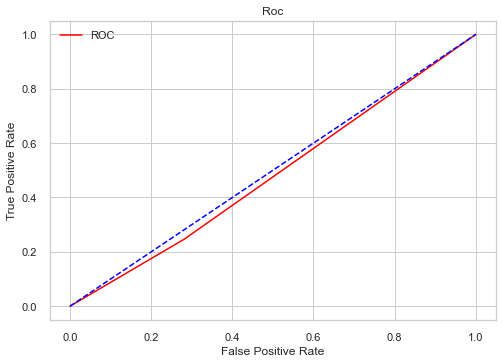

None                                                                              
score                                                                             
0.5174300541516246                                                                
params :                                                                          
{'C': 0.6884140640303874, 'solver': 'liblinear', 'type': 'logreg'}                
 72%|███████▏  | 23/32 [00:16<00:09,  1.09s/trial, best loss: 0.49349428399518647]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




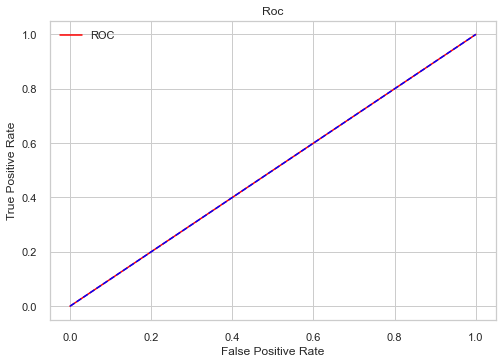

None                                                                              
score                                                                             
0.49988718411552346                                                               
params :                                                                          
{'C': 0.2790841810730923, 'solver': 'liblinear', 'type': 'logreg'}                
 75%|███████▌  | 24/32 [00:17<00:08,  1.07s/trial, best loss: 0.49349428399518647]

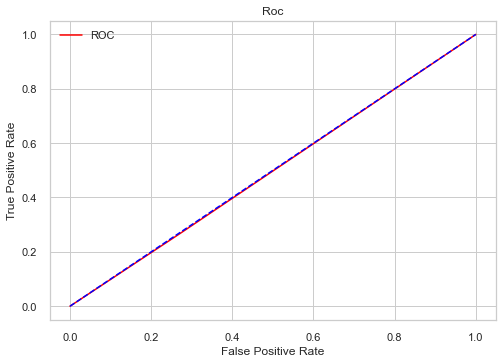

None                                                                              
score                                                                             
0.50184265944645                                                                  
params :                                                                          
{'C': 0.9751314122887353, 'solver': 'liblinear', 'type': 'logreg'}                
 78%|███████▊  | 25/32 [00:18<00:08,  1.22s/trial, best loss: 0.49349428399518647]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




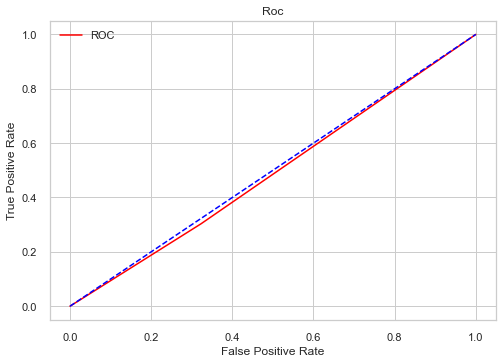

None                                                                              
score                                                                             
0.5098337845968712                                                                
params :                                                                          
{'C': 1.0365127579805486, 'solver': 'liblinear', 'type': 'logreg'}                
 81%|████████▏ | 26/32 [00:20<00:07,  1.33s/trial, best loss: 0.49349428399518647]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




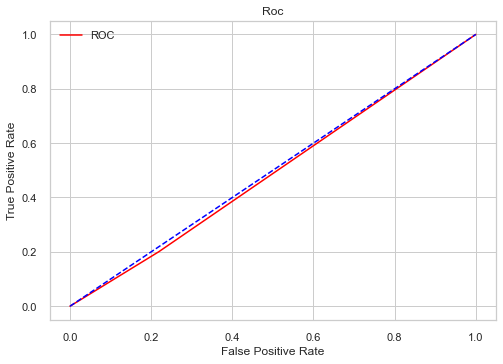

None                                                                              
score                                                                             
0.5091944945848376                                                                
params :                                                                          
{'C': 0.34625186233454974, 'solver': 'liblinear', 'type': 'logreg'}               
 84%|████████▍ | 27/32 [00:21<00:06,  1.23s/trial, best loss: 0.49349428399518647]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




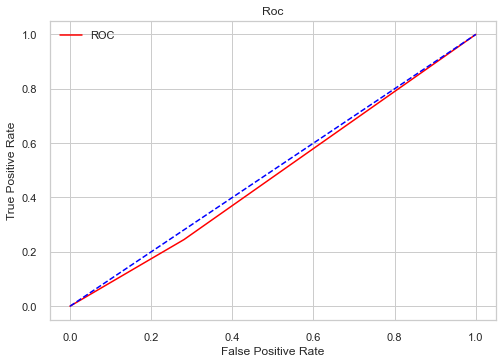

None                                                                              
score                                                                             
0.5178813176895307                                                                
params :                                                                          
{'C': 0.8307368575420164, 'solver': 'liblinear', 'type': 'logreg'}                
 88%|████████▊ | 28/32 [00:22<00:04,  1.21s/trial, best loss: 0.49349428399518647]

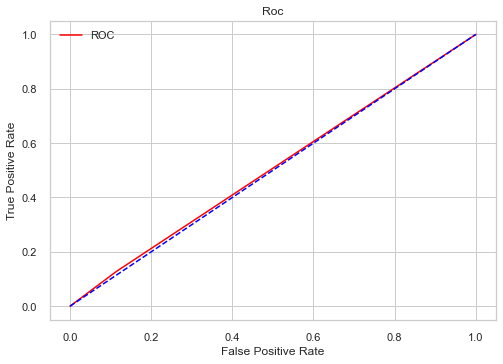

None                                                                              
score                                                                             
0.4932122442839951                                                                
params :                                                                          
{'C': 0.7929600392990765, 'solver': 'liblinear', 'type': 'logreg'}               
 91%|█████████ | 29/32 [00:23<00:03,  1.19s/trial, best loss: 0.4932122442839951]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




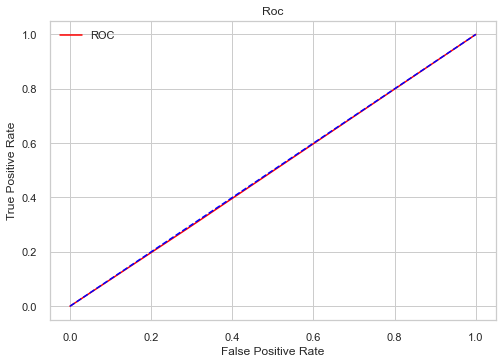

None                                                                             
score                                                                            
0.5018802647412756                                                               
params :                                                                         
{'C': 0.6625868324283638, 'solver': 'liblinear', 'type': 'logreg'}               
 94%|█████████▍| 30/32 [00:25<00:02,  1.33s/trial, best loss: 0.4932122442839951]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




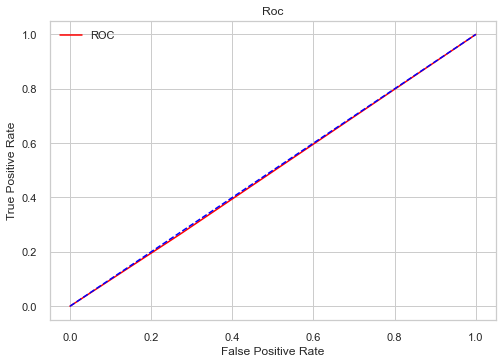

None                                                                             
score                                                                            
0.5031964500601684                                                               
params :                                                                         
{'C': 0.32042841754352996, 'solver': 'liblinear', 'type': 'logreg'}              
 97%|█████████▋| 31/32 [00:27<00:01,  1.47s/trial, best loss: 0.4932122442839951]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




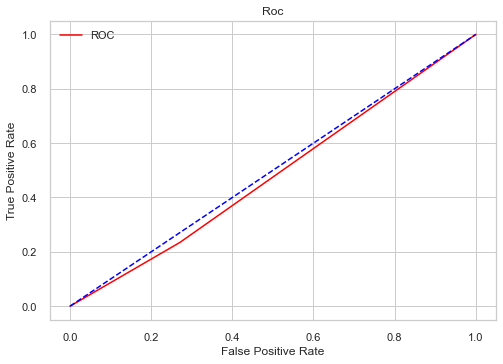

None                                                                             
score                                                                            
0.518088146811071                                                                
100%|██████████| 32/32 [00:28<00:00,  1.14trial/s, best loss: 0.4932122442839951]
params :                                              
{'C': 3.6622356833982157, 'solver': 'lbfgs', 'type': 'logreg'}
  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

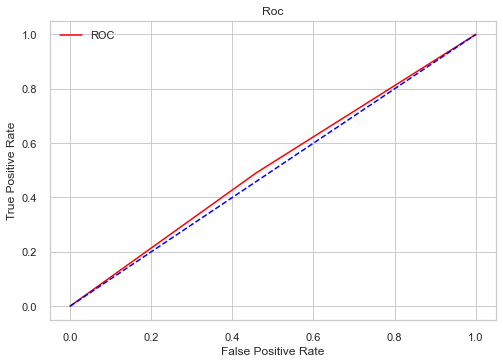

None                                                  
score                                                 
0.4841305655836341                                    
params :                                                                        
{'C': 1.2256056593100682, 'solver': 'liblinear', 'type': 'logreg'}              
  3%|▎         | 1/32 [00:00<00:06,  4.56trial/s, best loss: 0.4841305655836341]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




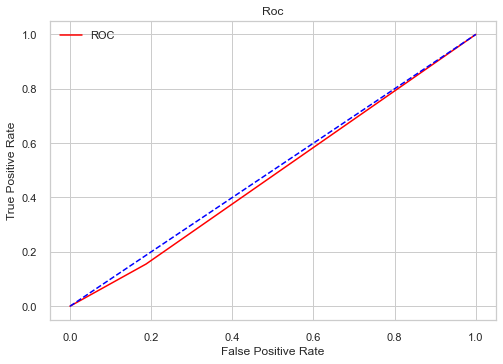

None                                                                            
score                                                                           
0.5161326714801444                                                              
params :                                                                        
{'max_depth': 3.0, 'type': 'rf'}                                                
  6%|▋         | 2/32 [00:01<00:32,  1.07s/trial, best loss: 0.4841305655836341]

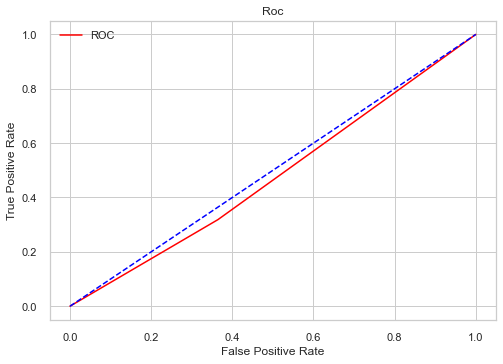

None                                                                            
score                                                                           
0.5229956377858002                                                              
params :                                                                        
{'C': 5.114208374654903, 'solver': 'lbfgs', 'type': 'logreg'}                   
  9%|▉         | 3/32 [00:02<00:22,  1.30trial/s, best loss: 0.4841305655836341]

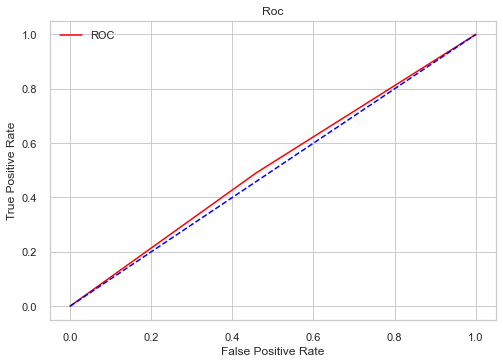

None                                                                            
score                                                                           
0.4841305655836341                                                              
params :                                                                        
{'C': 0.6279807813650586, 'solver': 'liblinear', 'type': 'logreg'}              
 12%|█▎        | 4/32 [00:02<00:15,  1.78trial/s, best loss: 0.4841305655836341]

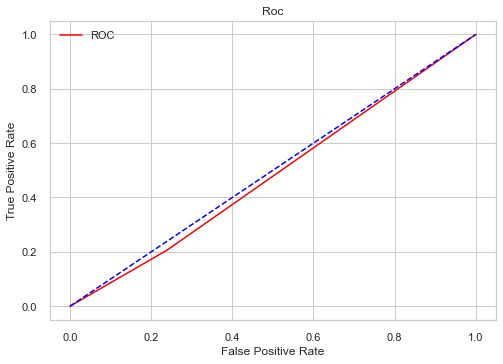

None                                                                            
score                                                                           
0.5164523164861612                                                              
params :                                                                        
{'C': 1.3667046404817398, 'solver': 'liblinear', 'type': 'logreg'}              
 16%|█▌        | 5/32 [00:03<00:19,  1.39trial/s, best loss: 0.4841305655836341]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




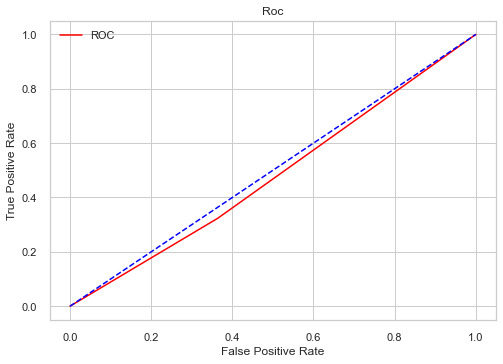

None                                                                            
score                                                                           
0.5202880565583634                                                              
params :                                                                        
{'max_depth': 4.0, 'type': 'rf'}                                                
 19%|█▉        | 6/32 [00:04<00:22,  1.17trial/s, best loss: 0.4841305655836341]

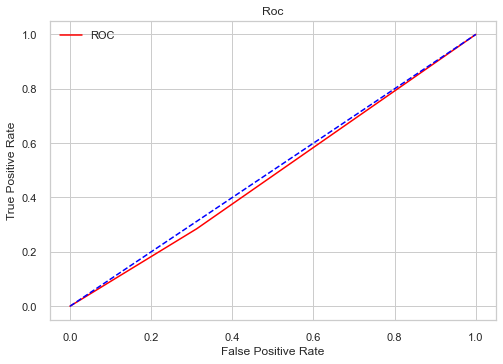

None                                                                            
score                                                                           
0.5136507220216606                                                              
params :                                                                        
{'C': 0.4208256417978818, 'solver': 'liblinear', 'type': 'logreg'}              
 22%|██▏       | 7/32 [00:05<00:17,  1.43trial/s, best loss: 0.4841305655836341]

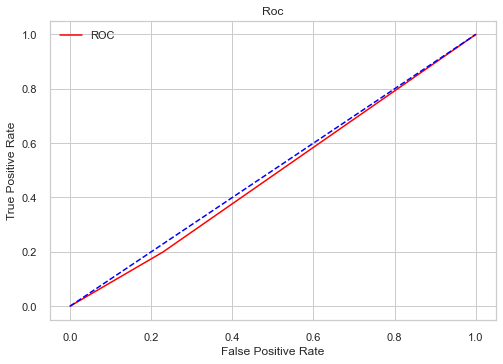

None                                                                            
score                                                                           
0.5148540914560771                                                              
params :                                                                        
{'C': 0.5476286157368616, 'solver': 'lbfgs', 'type': 'logreg'}                  
 25%|██▌       | 8/32 [00:05<00:16,  1.41trial/s, best loss: 0.4841305655836341]

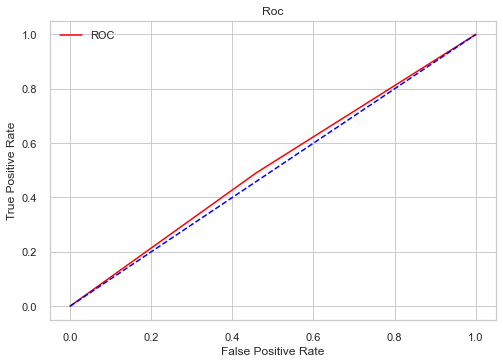

None                                                                            
score                                                                           
0.4841305655836341                                                              
params :                                                                        
{'max_depth': 4.0, 'type': 'rf'}                                                
 28%|██▊       | 9/32 [00:05<00:12,  1.83trial/s, best loss: 0.4841305655836341]

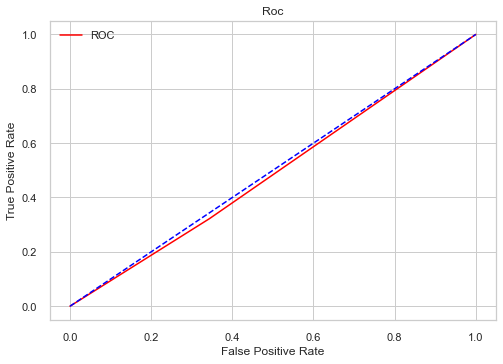

None                                                                            
score                                                                           
0.510773916967509                                                               
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
 31%|███▏      | 10/32 [00:06<00:10,  2.01trial/s, best loss: 0.4841305655836341]

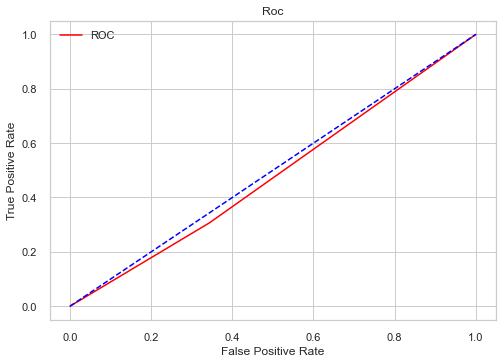

None                                                                             
score                                                                            
0.5184453971119134                                                               
params :                                                                         
{'C': 1.7893337102513664, 'solver': 'liblinear', 'type': 'logreg'}               
 34%|███▍      | 11/32 [00:06<00:09,  2.20trial/s, best loss: 0.4841305655836341]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




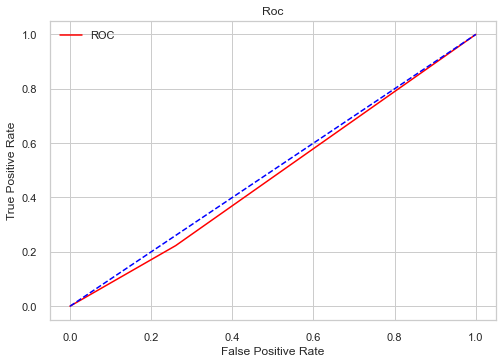

None                                                                             
score                                                                            
0.5187462394705175                                                               
params :                                                                         
{'max_depth': 4.0, 'type': 'rf'}                                                 
 38%|███▊      | 12/32 [00:07<00:12,  1.56trial/s, best loss: 0.4841305655836341]

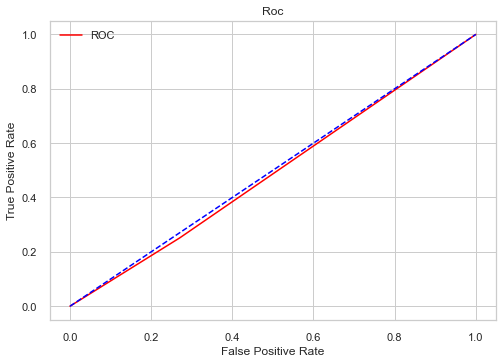

None                                                                             
score                                                                            
0.5095141395908543                                                               
params :                                                                         
{'C': 8.780653714156475, 'solver': 'lbfgs', 'type': 'logreg'}                    
 41%|████      | 13/32 [00:08<00:10,  1.76trial/s, best loss: 0.4841305655836341]

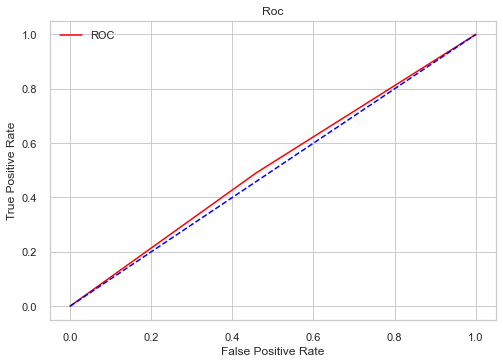

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 0.16505672558773415, 'solver': 'liblinear', 'type': 'logreg'}              
 44%|████▍     | 14/32 [00:08<00:08,  2.21trial/s, best loss: 0.4841305655836341]

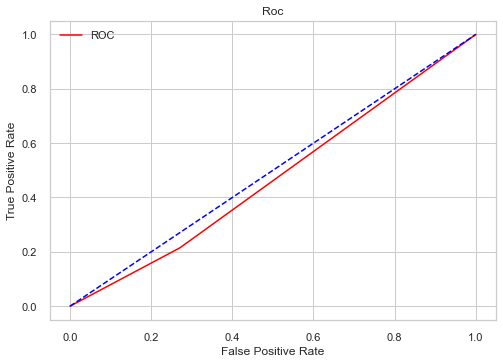

None                                                                             
score                                                                            
0.528015944645006                                                                
params :                                                                         
{'C': 3.778052837446925, 'solver': 'liblinear', 'type': 'logreg'}                
 47%|████▋     | 15/32 [00:09<00:10,  1.60trial/s, best loss: 0.4841305655836341]

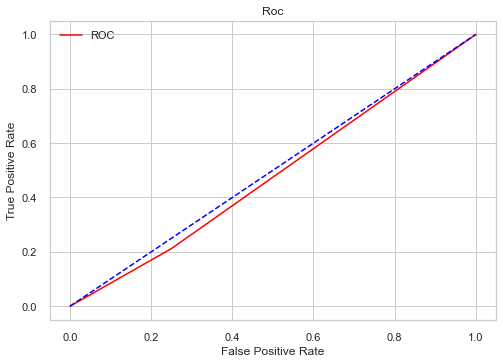

None                                                                             
score                                                                            
0.5189530685920578                                                               
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
 50%|█████     | 16/32 [00:10<00:11,  1.39trial/s, best loss: 0.4841305655836341]

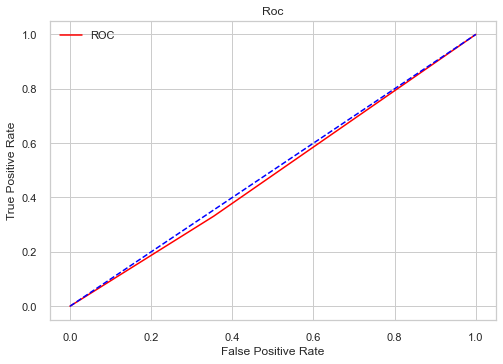

None                                                                             
score                                                                            
0.511469614921781                                                                
params :                                                                         
{'max_depth': 4.0, 'type': 'rf'}                                                 
 53%|█████▎    | 17/32 [00:10<00:09,  1.63trial/s, best loss: 0.4841305655836341]

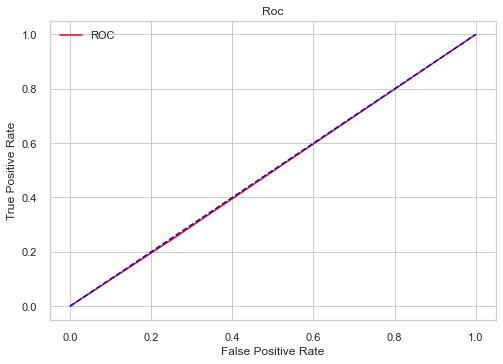

None                                                                             
score                                                                            
0.5027075812274369                                                               
params :                                                                         
{'C': 3.8001911035839147, 'solver': 'liblinear', 'type': 'logreg'}               
 56%|█████▋    | 18/32 [00:11<00:07,  1.83trial/s, best loss: 0.4841305655836341]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




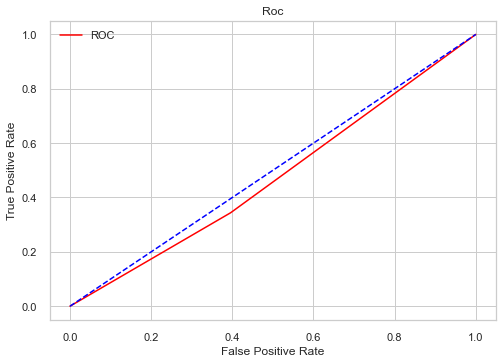

None                                                                             
score                                                                            
0.5259852587244284                                                               
params :                                                                         
{'C': 0.7261307260673457, 'solver': 'liblinear', 'type': 'logreg'}               
 59%|█████▉    | 19/32 [00:12<00:08,  1.46trial/s, best loss: 0.4841305655836341]

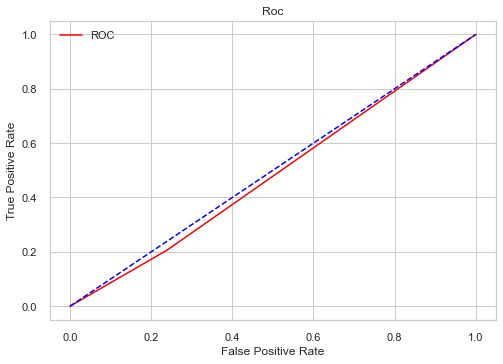

None                                                                             
score                                                                            
0.5164523164861612                                                               
params :                                                                         
{'C': 62.6877247082713, 'solver': 'lbfgs', 'type': 'logreg'}                     
 62%|██████▎   | 20/32 [00:13<00:09,  1.26trial/s, best loss: 0.4841305655836341]

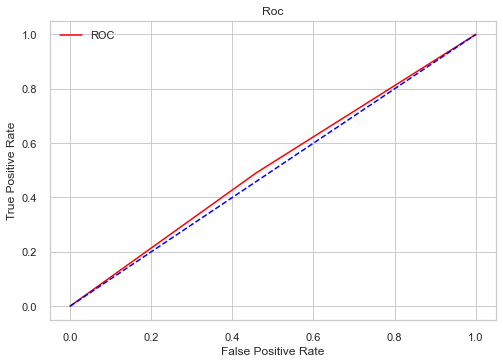

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 11.553272234899442, 'solver': 'lbfgs', 'type': 'logreg'}                   
 66%|██████▌   | 21/32 [00:13<00:07,  1.55trial/s, best loss: 0.4841305655836341]

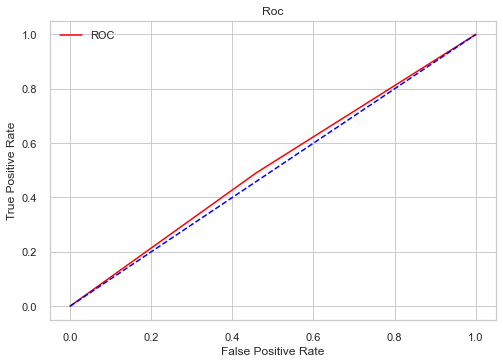

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 17.332482092293986, 'solver': 'lbfgs', 'type': 'logreg'}                   
 69%|██████▉   | 22/32 [00:13<00:05,  1.95trial/s, best loss: 0.4841305655836341]

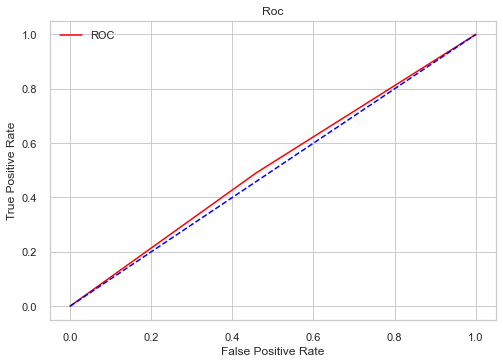

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 299.25520335355685, 'solver': 'lbfgs', 'type': 'logreg'}                   
 72%|███████▏  | 23/32 [00:13<00:03,  2.40trial/s, best loss: 0.4841305655836341]

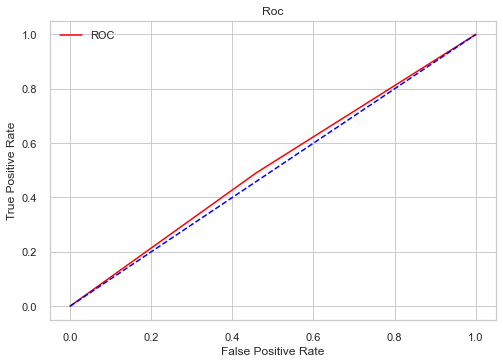

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 12.64108351027491, 'solver': 'lbfgs', 'type': 'logreg'}                    
 75%|███████▌  | 24/32 [00:14<00:02,  2.86trial/s, best loss: 0.4841305655836341]

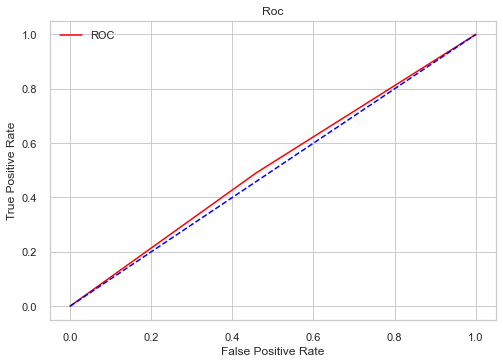

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 32.58559143687188, 'solver': 'lbfgs', 'type': 'logreg'}                    
 78%|███████▊  | 25/32 [00:14<00:02,  3.30trial/s, best loss: 0.4841305655836341]

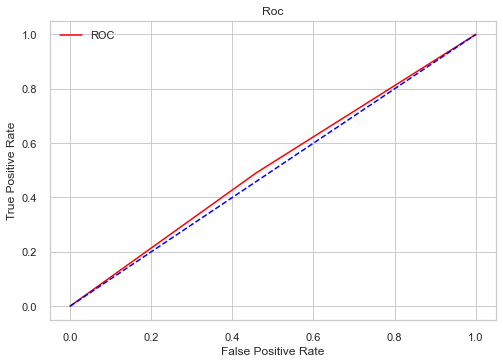

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 643.7755688959334, 'solver': 'lbfgs', 'type': 'logreg'}                    
 81%|████████▏ | 26/32 [00:14<00:01,  3.69trial/s, best loss: 0.4841305655836341]

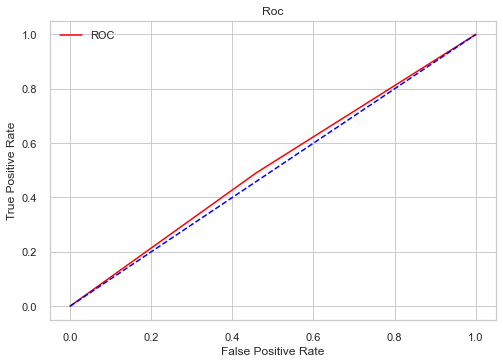

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 2.801865534514911, 'solver': 'lbfgs', 'type': 'logreg'}                    
 84%|████████▍ | 27/32 [00:14<00:01,  4.03trial/s, best loss: 0.4841305655836341]

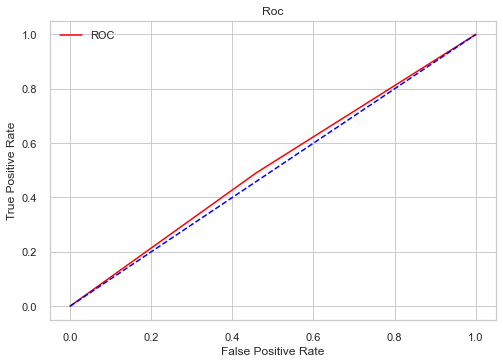

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 33.96038360759936, 'solver': 'lbfgs', 'type': 'logreg'}                    
 88%|████████▊ | 28/32 [00:14<00:00,  4.21trial/s, best loss: 0.4841305655836341]

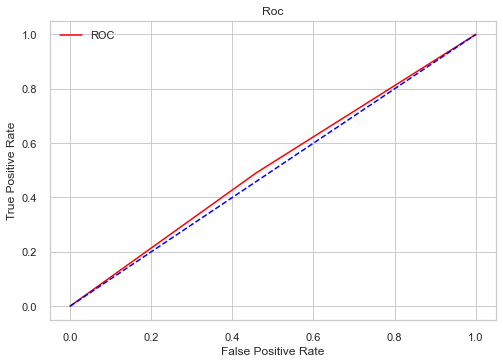

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 1299.9731476770369, 'solver': 'lbfgs', 'type': 'logreg'}                   
 91%|█████████ | 29/32 [00:15<00:00,  4.31trial/s, best loss: 0.4841305655836341]

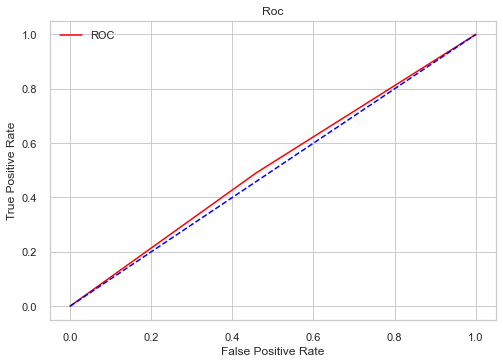

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 3.2035869442238893, 'solver': 'lbfgs', 'type': 'logreg'}                   
 94%|█████████▍| 30/32 [00:15<00:00,  4.52trial/s, best loss: 0.4841305655836341]

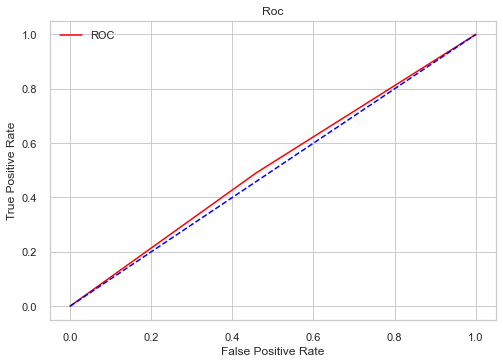

None                                                                             
score                                                                            
0.4841305655836341                                                               
params :                                                                         
{'C': 42.28935893812405, 'solver': 'lbfgs', 'type': 'logreg'}                    
 97%|█████████▋| 31/32 [00:15<00:00,  4.69trial/s, best loss: 0.4841305655836341]

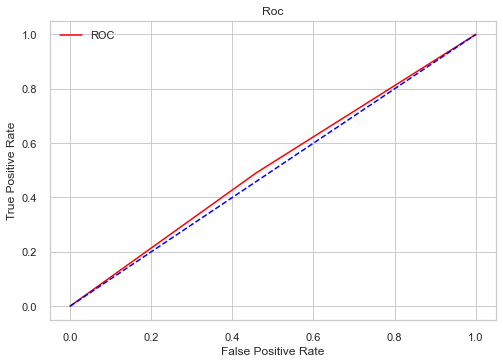

None                                                                             
score                                                                            
0.4841305655836341                                                               
100%|██████████| 32/32 [00:15<00:00,  2.05trial/s, best loss: 0.4841305655836341]
params :                                              
{'max_depth': 2.0, 'type': 'rf'}                      
  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

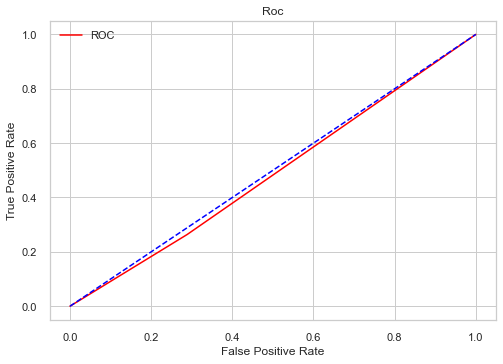

None                                                  
score                                                 
0.5124419113606943                                    
params :                                                                        
{'max_depth': 3.0, 'type': 'rf'}                                                
  3%|▎         | 1/32 [00:00<00:10,  2.88trial/s, best loss: 0.5124419113606943]

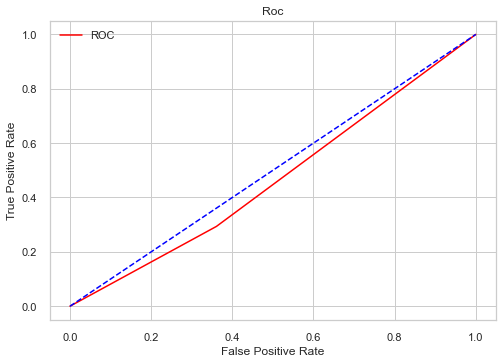

None                                                                            
score                                                                           
0.533619236536008                                                               
params :                                                                        
{'C': 3.2128947354465174, 'solver': 'liblinear', 'type': 'logreg'}              
  6%|▋         | 2/32 [00:00<00:11,  2.67trial/s, best loss: 0.5124419113606943]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




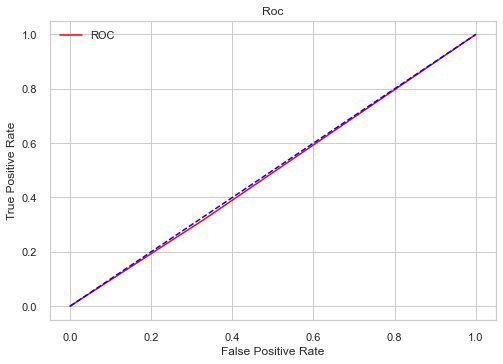

None                                                                            
score                                                                           
0.5055085258756368                                                              
params :                                                                        
{'C': 0.42699512641788934, 'solver': 'lbfgs', 'type': 'logreg'}                 
  9%|▉         | 3/32 [00:02<00:26,  1.10trial/s, best loss: 0.5055085258756368]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




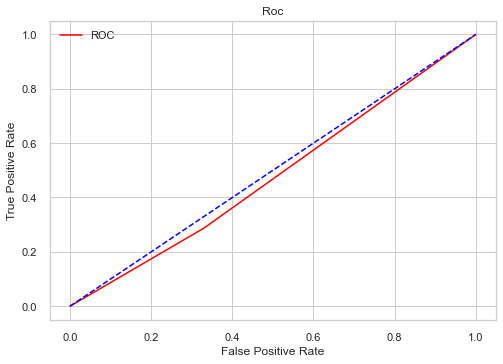

None                                                                            
score                                                                           
0.5213170172938842                                                              
params :                                                                        
{'max_depth': 4.0, 'type': 'rf'}                                                
 12%|█▎        | 4/32 [00:02<00:18,  1.52trial/s, best loss: 0.5055085258756368]

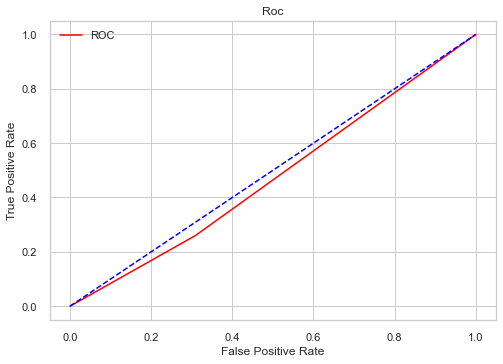

None                                                                            
score                                                                           
0.5245578744447238                                                              
params :                                                                        
{'max_depth': 2.0, 'type': 'rf'}                                                
 16%|█▌        | 5/32 [00:02<00:15,  1.74trial/s, best loss: 0.5055085258756368]

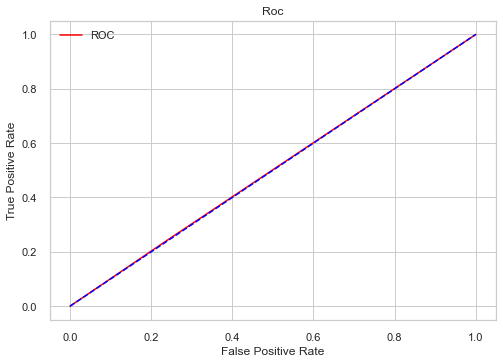

None                                                                            
score                                                                           
0.4984121662522467                                                              
params :                                                                        
{'C': 0.7942328798191627, 'solver': 'liblinear', 'type': 'logreg'}              
 19%|█▉        | 6/32 [00:03<00:13,  1.98trial/s, best loss: 0.4984121662522467]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




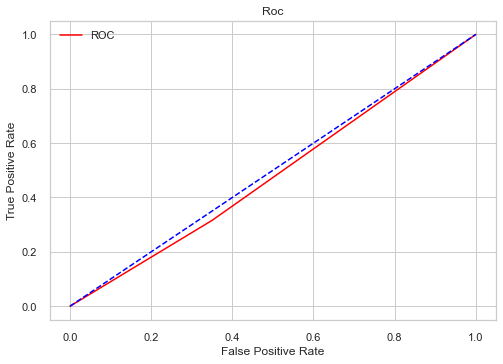

None                                                                            
score                                                                           
0.5171728177762878                                                              
params :                                                                        
{'max_depth': 2.0, 'type': 'rf'}                                                
 22%|██▏       | 7/32 [00:04<00:17,  1.39trial/s, best loss: 0.4984121662522467]

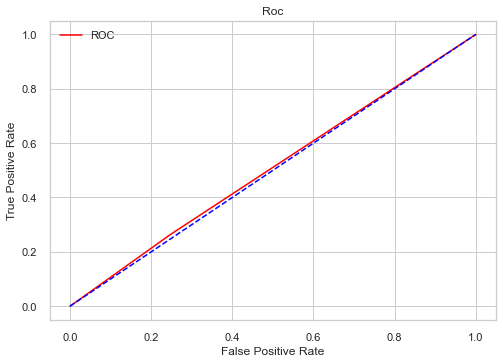

None                                                                            
score                                                                           
0.4918233546596634                                                              
params :                                                                        
{'C': 0.8307537985479205, 'solver': 'lbfgs', 'type': 'logreg'}                  
 25%|██▌       | 8/32 [00:04<00:14,  1.61trial/s, best loss: 0.4918233546596634]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




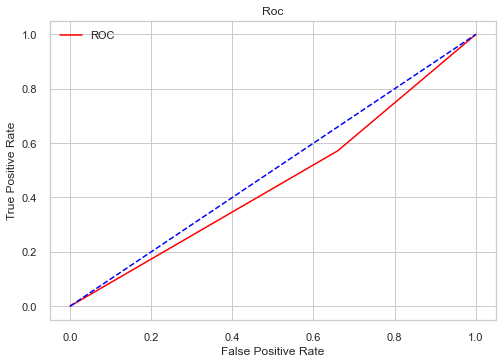

None                                                                            
score                                                                           
0.543989048137904                                                               
params :                                                                        
{'C': 8.642296010328481, 'solver': 'liblinear', 'type': 'logreg'}               
 28%|██▊       | 9/32 [00:05<00:11,  2.00trial/s, best loss: 0.4918233546596634]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




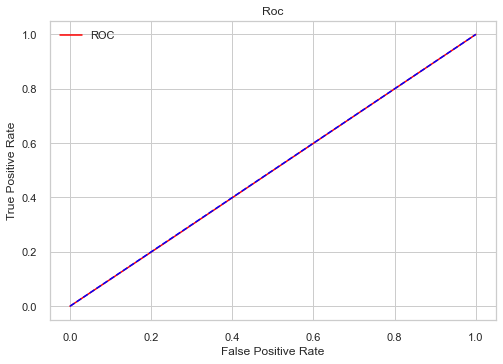

None                                                                            
score                                                                           
0.500484266011045                                                               
params :                                                                         
{'C': 1.0892452439036404, 'solver': 'liblinear', 'type': 'logreg'}               
 31%|███▏      | 10/32 [00:06<00:15,  1.45trial/s, best loss: 0.4918233546596634]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




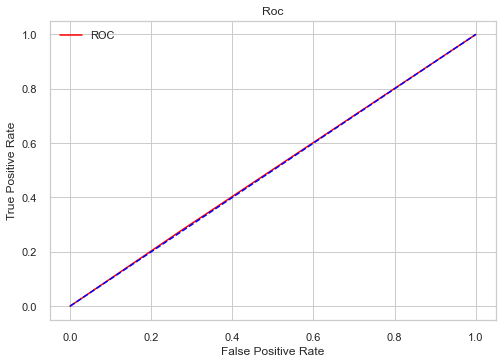

None                                                                             
score                                                                            
0.4978021773344881                                                               
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
 34%|███▍      | 11/32 [00:07<00:17,  1.23trial/s, best loss: 0.4918233546596634]

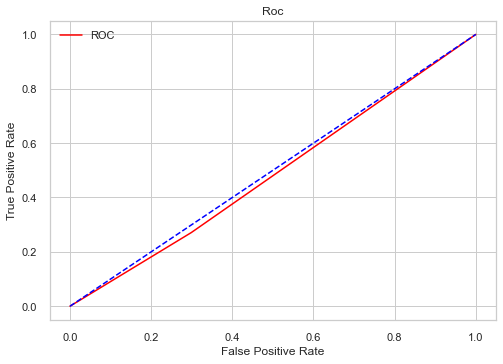

None                                                                             
score                                                                            
0.5139831810689242                                                               
params :                                                                         
{'max_depth': 2.0, 'type': 'rf'}                                                 
 38%|███▊      | 12/32 [00:07<00:13,  1.47trial/s, best loss: 0.4918233546596634]

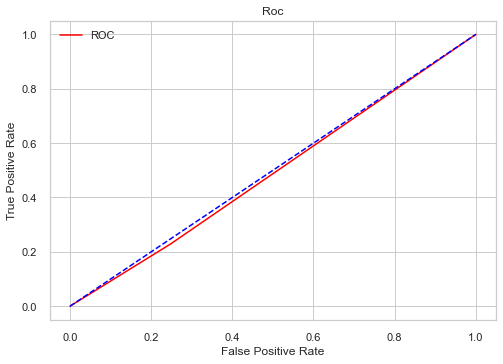

None                                                                             
score                                                                            
0.509438530811425                                                                
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
 41%|████      | 13/32 [00:08<00:10,  1.74trial/s, best loss: 0.4918233546596634]

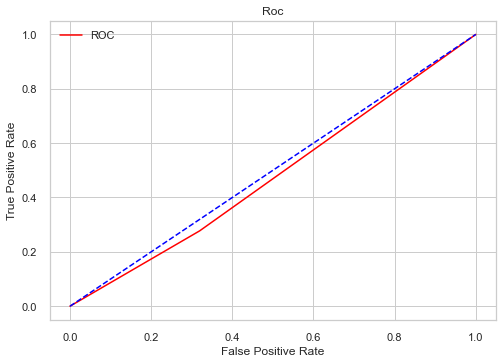

None                                                                             
score                                                                            
0.52113076113579                                                                 
params :                                                                         
{'C': 0.2577041329600171, 'solver': 'lbfgs', 'type': 'logreg'}                   
 44%|████▍     | 14/32 [00:08<00:09,  1.96trial/s, best loss: 0.4918233546596634]

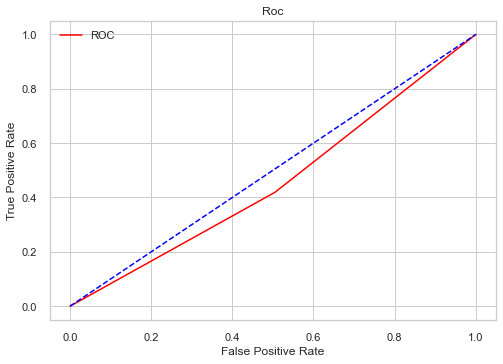

None                                                                             
score                                                                            
0.5430018905000047                                                               
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
 47%|████▋     | 15/32 [00:08<00:07,  2.39trial/s, best loss: 0.4918233546596634]

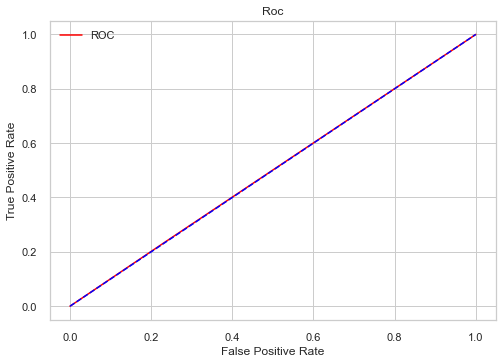

None                                                                             
score                                                                            
0.49912925246090956                                                              
params :                                                                         
{'max_depth': 4.0, 'type': 'rf'}                                                 
 50%|█████     | 16/32 [00:09<00:06,  2.48trial/s, best loss: 0.4918233546596634]

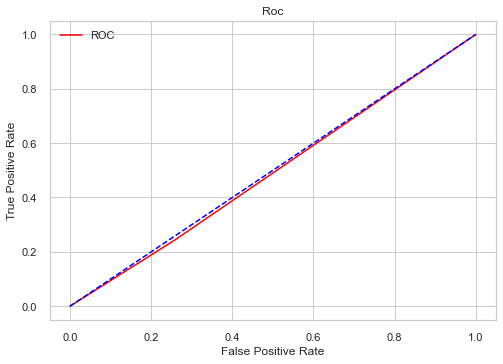

None                                                                             
score                                                                            
0.5073664310526267                                                               
params :                                                                         
{'C': 1.0558243743779823, 'solver': 'lbfgs', 'type': 'logreg'}                   
 53%|█████▎    | 17/32 [00:09<00:06,  2.50trial/s, best loss: 0.4918233546596634]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




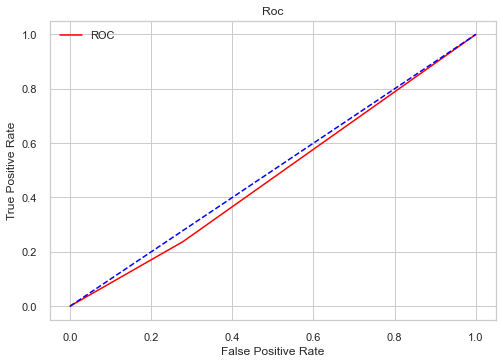

None                                                                             
score                                                                            
0.520385736503413                                                                
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
 56%|█████▋    | 18/32 [00:09<00:04,  2.87trial/s, best loss: 0.4918233546596634]

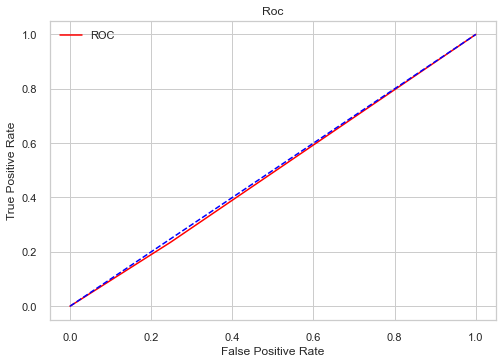

None                                                                             
score                                                                            
0.5062768325277754                                                               
params :                                                                         
{'max_depth': 4.0, 'type': 'rf'}                                                 
 59%|█████▉    | 19/32 [00:09<00:04,  2.85trial/s, best loss: 0.4918233546596634]

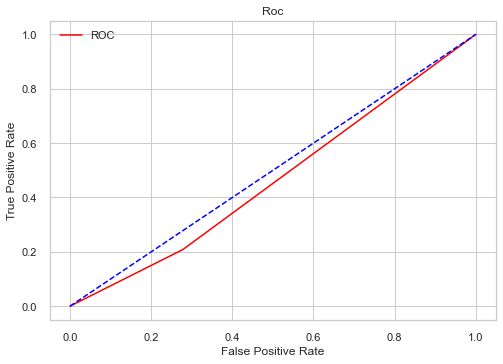

None                                                                             
score                                                                            
0.534839214371525                                                                
params :                                                                         
{'C': 1.4493435612948926, 'solver': 'liblinear', 'type': 'logreg'}               
 62%|██████▎   | 20/32 [00:10<00:04,  2.76trial/s, best loss: 0.4918233546596634]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




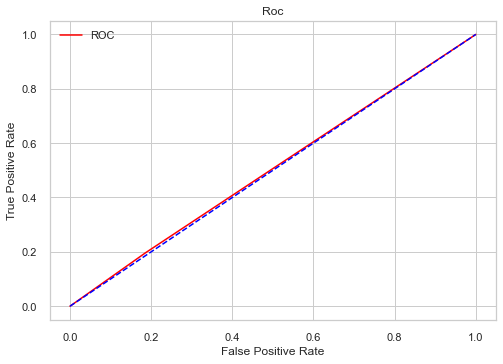

None                                                                             
score                                                                            
0.4947708583615046                                                               
params :                                                                         
{'C': 1.8139994785431095, 'solver': 'liblinear', 'type': 'logreg'}               
 66%|██████▌   | 21/32 [00:11<00:06,  1.73trial/s, best loss: 0.4918233546596634]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




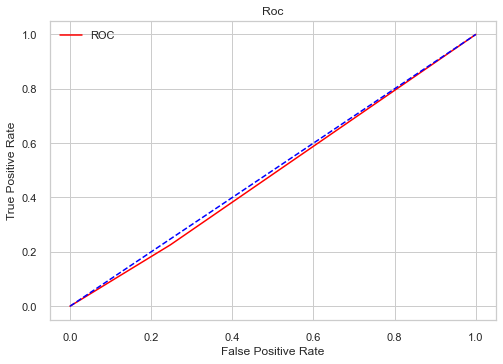

None                                                                             
score                                                                            
0.5107935443615604                                                               
params :                                                                         
{'C': 1.6914549275335964, 'solver': 'liblinear', 'type': 'logreg'}               
 69%|██████▉   | 22/32 [00:12<00:07,  1.42trial/s, best loss: 0.4918233546596634]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




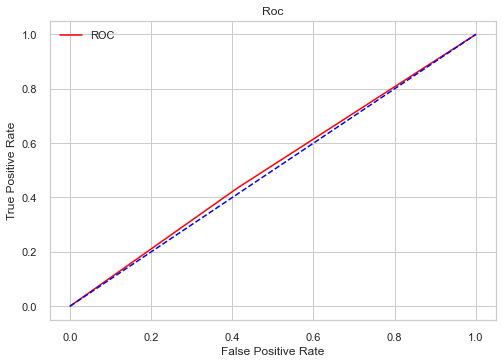

None                                                                             
score                                                                            
0.4889317278052505                                                               
params :                                                                         
{'C': 2.522625595995422, 'solver': 'liblinear', 'type': 'logreg'}                
 72%|███████▏  | 23/32 [00:13<00:07,  1.25trial/s, best loss: 0.4889317278052505]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




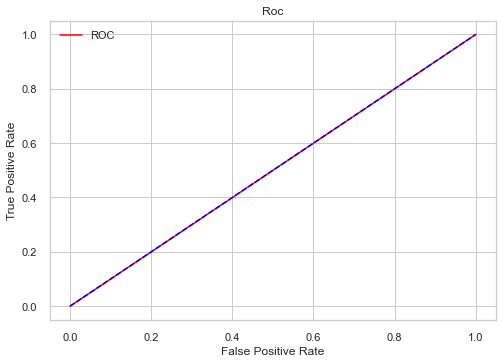

None                                                                             
score                                                                            
0.5002188509857607                                                               
params :                                                                         
{'max_depth': 5.0, 'type': 'rf'}                                                 
 75%|███████▌  | 24/32 [00:14<00:06,  1.15trial/s, best loss: 0.4889317278052505]

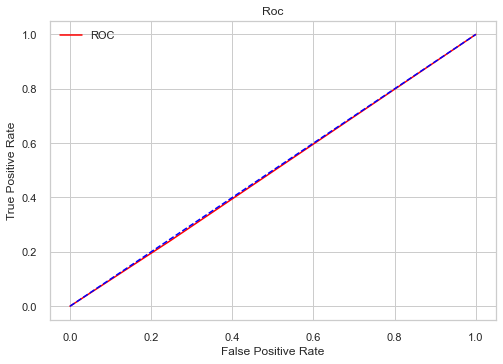

None                                                                             
score                                                                            
0.503115134244126                                                                
params :                                                                         
{'C': 2.432288579616441, 'solver': 'liblinear', 'type': 'logreg'}                
 78%|███████▊  | 25/32 [00:15<00:05,  1.33trial/s, best loss: 0.4889317278052505]

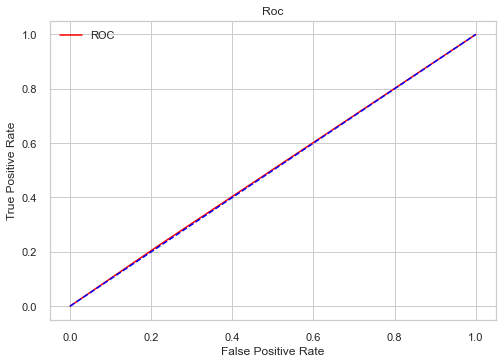

None                                                                             
score                                                                            
0.49758798275267974                                                              
params :                                                                         
{'C': 1.4270490080224079, 'solver': 'liblinear', 'type': 'logreg'}               
 81%|████████▏ | 26/32 [00:16<00:05,  1.17trial/s, best loss: 0.4889317278052505]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




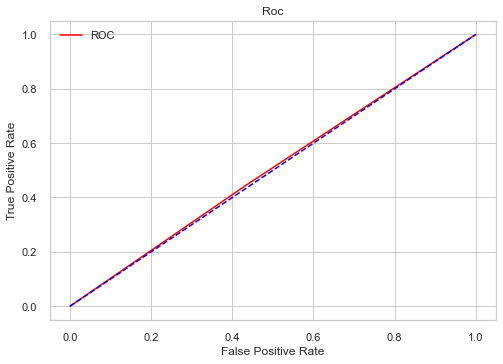

None                                                                             
score                                                                            
0.49427262313860254                                                              
params :                                                                         
{'max_depth': 5.0, 'type': 'rf'}                                                 
 84%|████████▍ | 27/32 [00:17<00:04,  1.06trial/s, best loss: 0.4889317278052505]

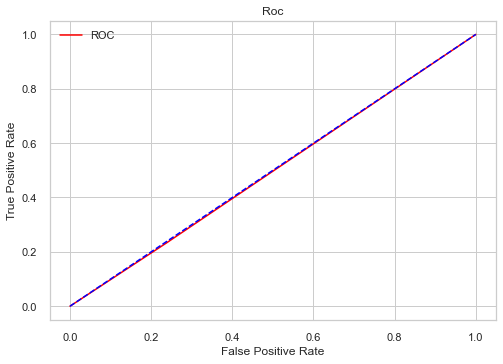

None                                                                             
score                                                                            
0.5024772069026532                                                               
params :                                                                         
{'max_depth': 2.0, 'type': 'rf'}                                                 
 88%|████████▊ | 28/32 [00:17<00:03,  1.28trial/s, best loss: 0.4889317278052505]

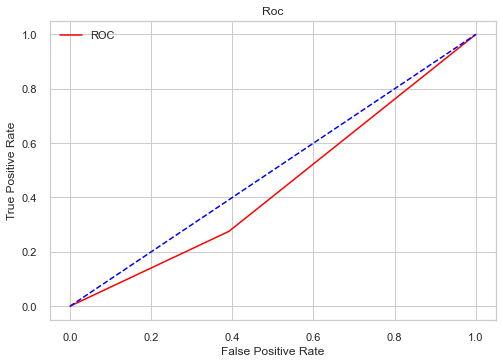

None                                                                             
score                                                                            
0.5581165777293512                                                               
params :                                                                         
{'C': 5.0035272414918, 'solver': 'lbfgs', 'type': 'logreg'}                      
 91%|█████████ | 29/32 [00:17<00:01,  1.54trial/s, best loss: 0.4889317278052505]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




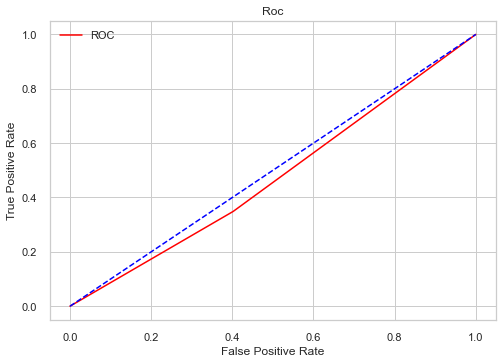

None                                                                             
score                                                                            
0.5266858510509503                                                               
params :                                                                         
{'max_depth': 2.0, 'type': 'rf'}                                                 
 94%|█████████▍| 30/32 [00:18<00:01,  1.91trial/s, best loss: 0.4889317278052505]

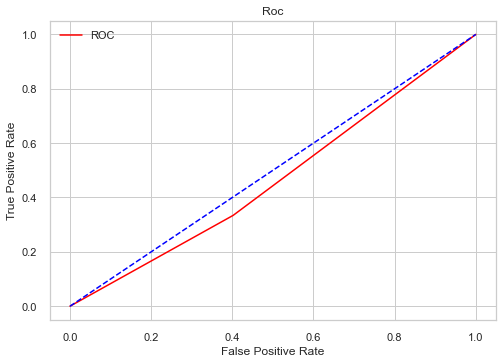

None                                                                             
score                                                                            
0.5339125899850063                                                               
params :                                                                         
{'max_depth': 4.0, 'type': 'rf'}                                                 
 97%|█████████▋| 31/32 [00:18<00:00,  2.14trial/s, best loss: 0.4889317278052505]

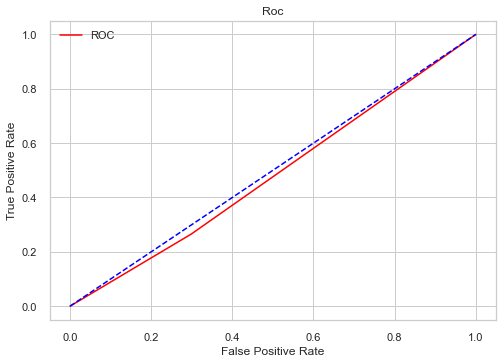

None                                                                             
score                                                                            
0.5166932081691952                                                               
100%|██████████| 32/32 [00:18<00:00,  1.69trial/s, best loss: 0.4889317278052505]
params :                                              
{'max_depth': 4.0, 'type': 'rf'}                      
  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

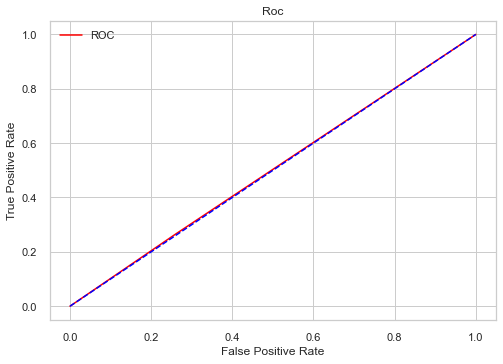

None                                                  
score                                                 
0.49742966501829966                                   
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
  3%|▎         | 1/32 [00:00<00:12,  2.46trial/s, best loss: 0.49742966501829966]

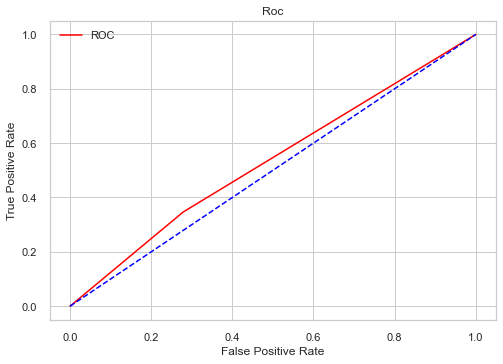

None                                                                             
score                                                                            
0.466185194497993                                                                
params :                                                                         
{'max_depth': 4.0, 'type': 'rf'}                                               
  6%|▋         | 2/32 [00:00<00:13,  2.30trial/s, best loss: 0.466185194497993]

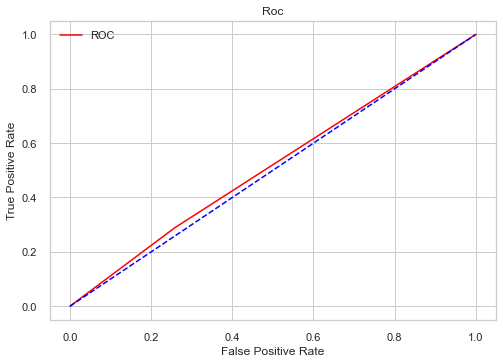

None                                                                           
score                                                                          
0.4847828718837016                                                             
params :                                                                       
{'C': 0.15497155356356018, 'solver': 'liblinear', 'type': 'logreg'}            
  9%|▉         | 3/32 [00:01<00:13,  2.15trial/s, best loss: 0.466185194497993]

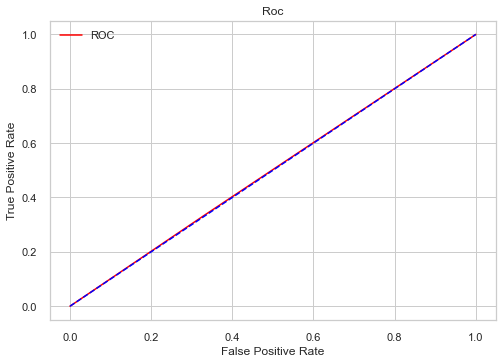

None                                                                           
score                                                                          
0.49828178694158076                                                            
params :                                                                       
{'C': 0.7209365664677754, 'solver': 'liblinear', 'type': 'logreg'}             
 12%|█▎        | 4/32 [00:02<00:23,  1.17trial/s, best loss: 0.466185194497993]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




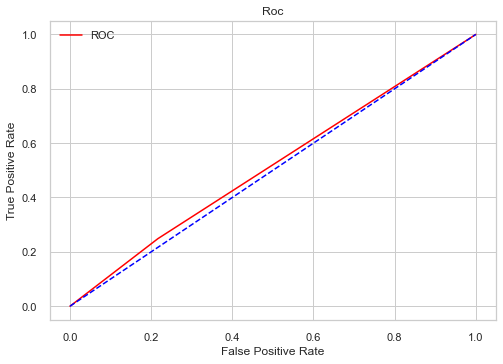

None                                                                           
score                                                                          
0.4840378472513248                                                             
params :                                                                       
{'max_depth': 4.0, 'type': 'rf'}                                               
 16%|█▌        | 5/32 [00:04<00:27,  1.03s/trial, best loss: 0.466185194497993]

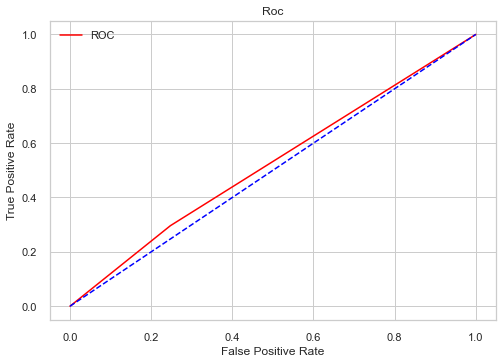

None                                                                           
score                                                                          
0.47556319205803743                                                            
params :                                                                       
{'C': 2.103988675112153, 'solver': 'liblinear', 'type': 'logreg'}              
 19%|█▉        | 6/32 [00:04<00:21,  1.22trial/s, best loss: 0.466185194497993]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




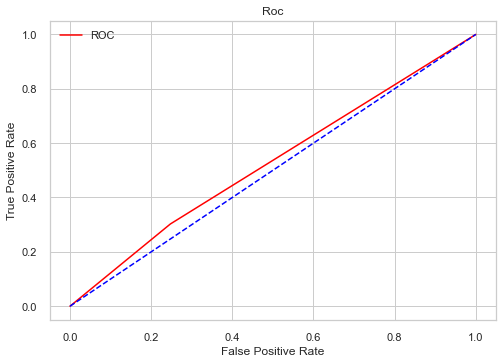

None                                                                           
score                                                                          
0.4724014937743879                                                             
params :                                                                       
{'max_depth': 5.0, 'type': 'rf'}                                               
 22%|██▏       | 7/32 [00:05<00:22,  1.13trial/s, best loss: 0.466185194497993]

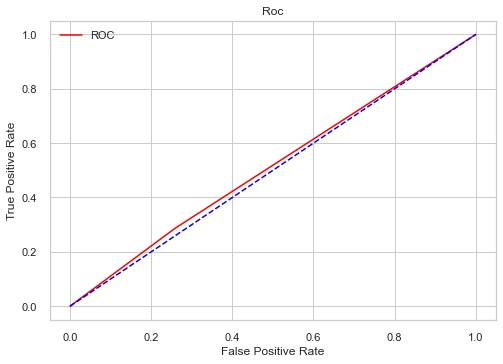

None                                                                           
score                                                                          
0.4861378854338372                                                             
params :                                                                       
{'C': 1.2048101670940468, 'solver': 'liblinear', 'type': 'logreg'}             
 25%|██▌       | 8/32 [00:06<00:17,  1.36trial/s, best loss: 0.466185194497993]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




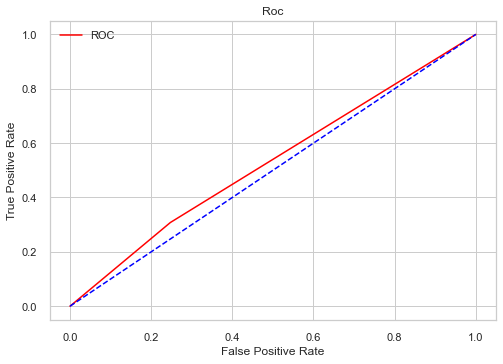

None                                                                           
score                                                                          
0.46969146667411693                                                            
params :                                                                       
{'C': 0.7745522992555057, 'solver': 'lbfgs', 'type': 'logreg'}                 
 28%|██▊       | 9/32 [00:06<00:18,  1.23trial/s, best loss: 0.466185194497993]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




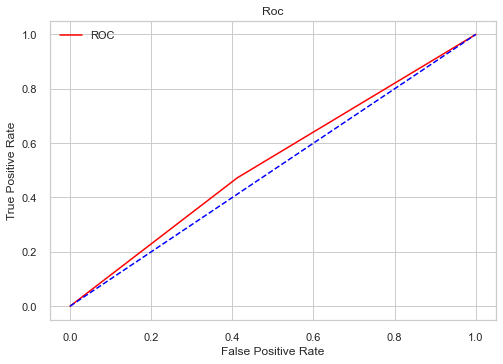

None                                                                           
score                                                                          
0.46996153810335356                                                            
params :                                                                        
{'max_depth': 3.0, 'type': 'rf'}                                                
 31%|███▏      | 10/32 [00:07<00:14,  1.56trial/s, best loss: 0.466185194497993]

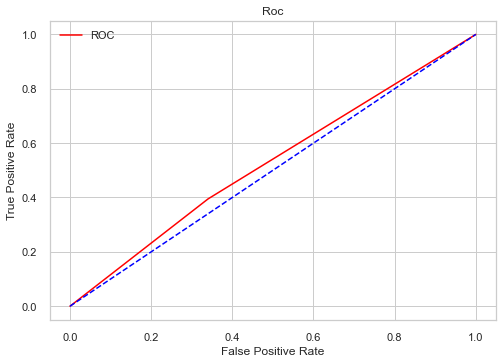

None                                                                            
score                                                                           
0.47272278564710046                                                             
params :                                                                        
{'C': 0.9373132672970884, 'solver': 'liblinear', 'type': 'logreg'}              
 34%|███▍      | 11/32 [00:07<00:11,  1.79trial/s, best loss: 0.466185194497993]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




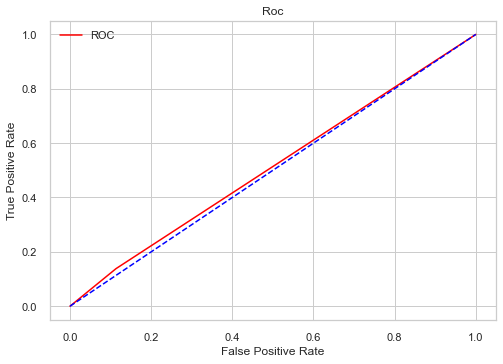

None                                                                            
score                                                                           
0.4875953398709245                                                              
params :                                                                        
{'max_depth': 3.0, 'type': 'rf'}                                                
 38%|███▊      | 12/32 [00:08<00:15,  1.28trial/s, best loss: 0.466185194497993]

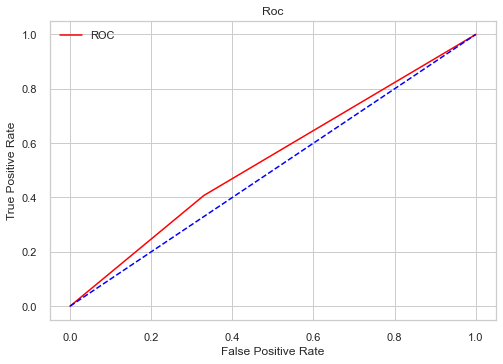

None                                                                            
score                                                                           
0.46124474990454367                                                             
params :                                                                          
{'max_depth': 3.0, 'type': 'rf'}                                                  
 41%|████      | 13/32 [00:09<00:12,  1.53trial/s, best loss: 0.46124474990454367]

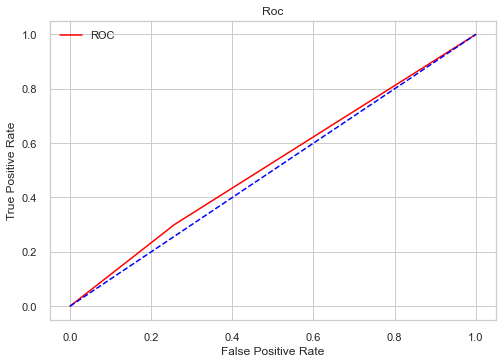

None                                                                              
score                                                                             
0.47845947531640265                                                               
params :                                                                          
{'max_depth': 2.0, 'type': 'rf'}                                                  
 44%|████▍     | 14/32 [00:09<00:10,  1.69trial/s, best loss: 0.46124474990454367]

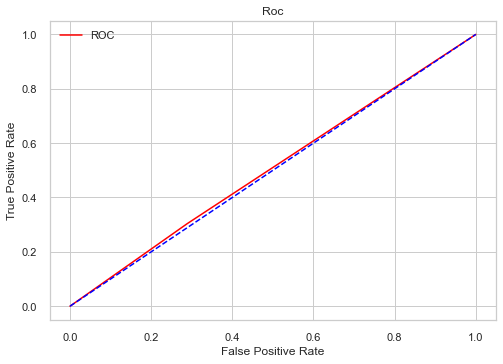

None                                                                              
score                                                                             
0.4925683792920403                                                                
params :                                                                          
{'C': 3.0315095012223723, 'solver': 'liblinear', 'type': 'logreg'}                
 47%|████▋     | 15/32 [00:10<00:08,  1.95trial/s, best loss: 0.46124474990454367]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




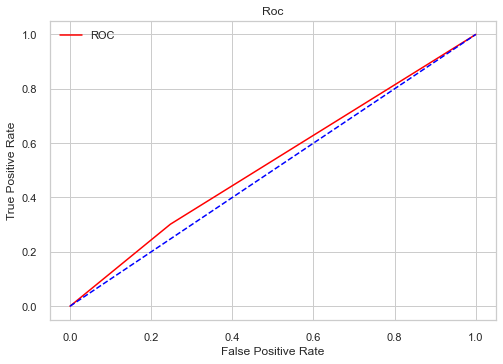

None                                                                              
score                                                                             
0.4728531649577664                                                                
params :                                                                          
{'C': 0.4538515100636383, 'solver': 'lbfgs', 'type': 'logreg'}                    
 50%|█████     | 16/32 [00:11<00:11,  1.40trial/s, best loss: 0.46124474990454367]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




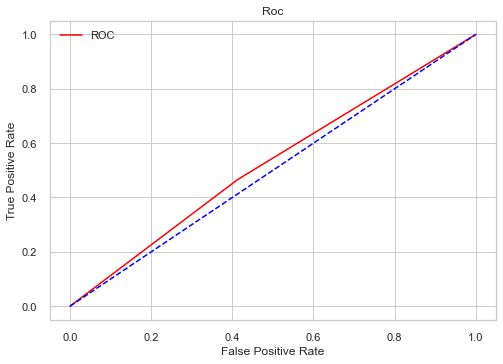

None                                                                              
score                                                                             
0.47357490757038145                                                               
params :                                                                          
{'C': 0.8373032364013868, 'solver': 'liblinear', 'type': 'logreg'}                
 53%|█████▎    | 17/32 [00:11<00:08,  1.71trial/s, best loss: 0.46124474990454367]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




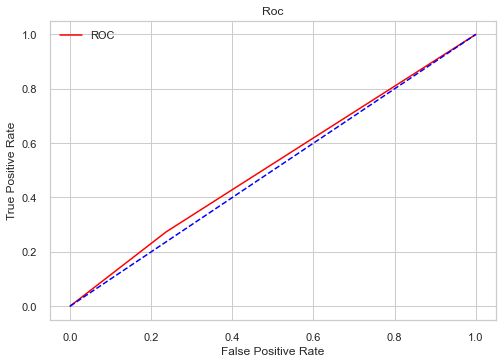

None                                                                              
score                                                                             
0.4817003324672422                                                                
params :                                                                          
{'max_depth': 2.0, 'type': 'rf'}                                                  
 56%|█████▋    | 18/32 [00:12<00:10,  1.35trial/s, best loss: 0.46124474990454367]

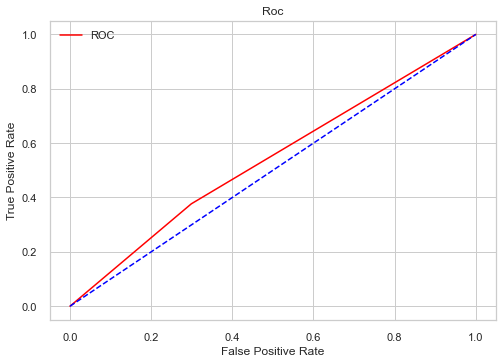

None                                                                              
score                                                                             
0.4611376526136396                                                                
params :                                                                          
{'C': 4.996694756937105, 'solver': 'liblinear', 'type': 'logreg'}                
 59%|█████▉    | 19/32 [00:12<00:08,  1.60trial/s, best loss: 0.4611376526136396]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




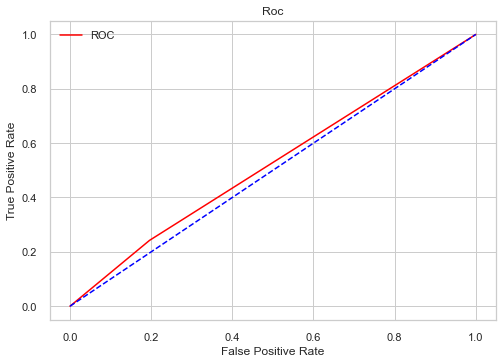

None                                                                             
score                                                                            
0.47689026718445876                                                              
params :                                                                         
{'max_depth': 2.0, 'type': 'rf'}                                                 
 62%|██████▎   | 20/32 [00:14<00:09,  1.27trial/s, best loss: 0.4611376526136396]

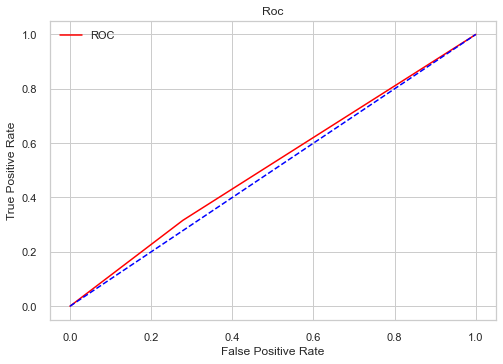

None                                                                             
score                                                                            
0.4810903435494836                                                               
params :                                                                         
{'max_depth': 2.0, 'type': 'rf'}                                                 
 66%|██████▌   | 21/32 [00:14<00:07,  1.50trial/s, best loss: 0.4611376526136396]

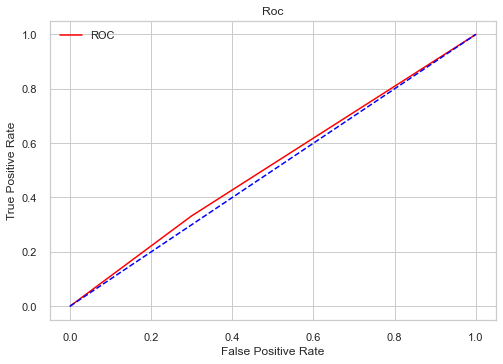

None                                                                             
score                                                                            
0.4837212117825645                                                               
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
 69%|██████▉   | 22/32 [00:14<00:05,  1.74trial/s, best loss: 0.4611376526136396]

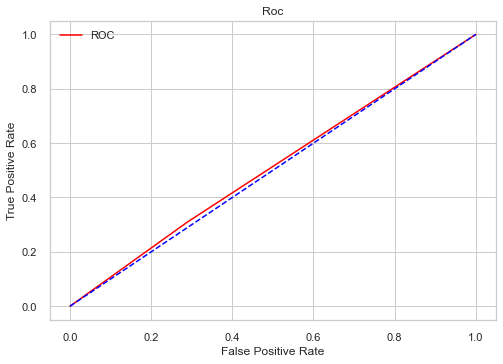

None                                                                             
score                                                                            
0.48985835219176926                                                              
params :                                                                         
{'max_depth': 2.0, 'type': 'rf'}                                                 
 72%|███████▏  | 23/32 [00:15<00:04,  1.95trial/s, best loss: 0.4611376526136396]

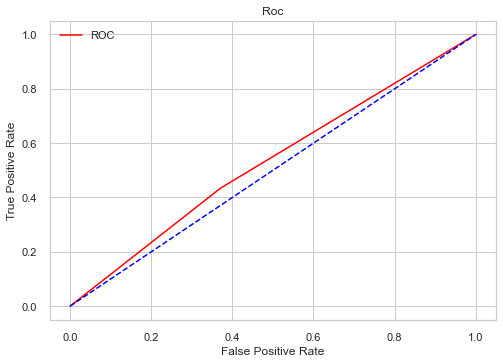

None                                                                             
score                                                                            
0.46831317110421966                                                              
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
 75%|███████▌  | 24/32 [00:15<00:03,  2.16trial/s, best loss: 0.4611376526136396]

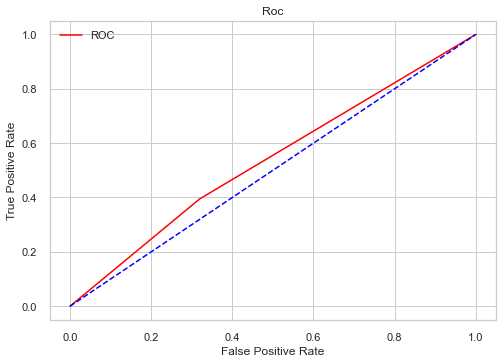

None                                                                             
score                                                                            
0.4624135072965849                                                               
params :                                                                         
{'max_depth': 2.0, 'type': 'rf'}                                                 
 78%|███████▊  | 25/32 [00:15<00:03,  2.29trial/s, best loss: 0.4611376526136396]

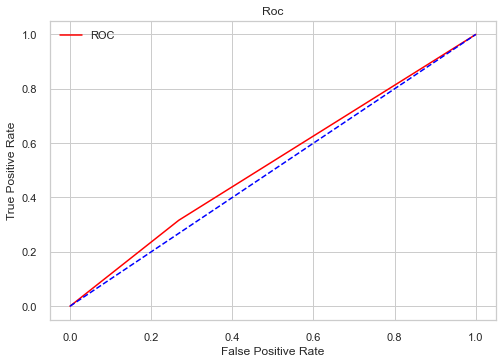

None                                                                             
score                                                                            
0.47593570437422583                                                              
params :                                                                         
{'max_depth': 5.0, 'type': 'rf'}                                                 
 81%|████████▏ | 26/32 [00:16<00:02,  2.46trial/s, best loss: 0.4611376526136396]

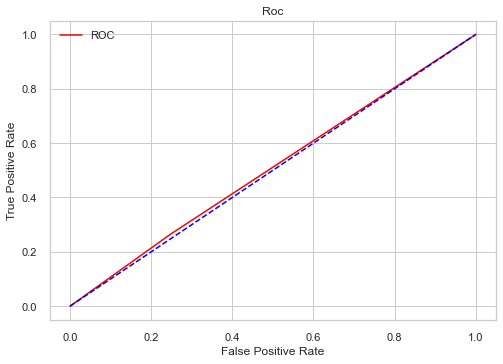

None                                                                             
score                                                                            
0.4913716834762849                                                               
params :                                                                         
{'max_depth': 2.0, 'type': 'rf'}                                                 
 84%|████████▍ | 27/32 [00:16<00:02,  2.44trial/s, best loss: 0.4611376526136396]

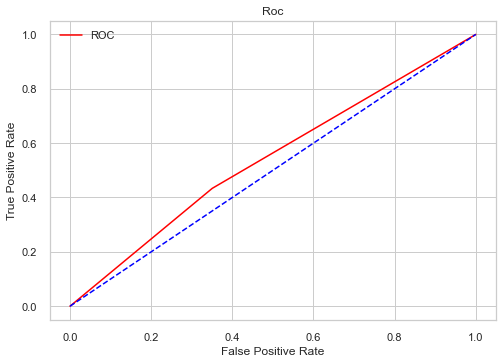

None                                                                             
score                                                                            
0.45845556393708264                                                              
params :                                                                          
{'max_depth': 2.0, 'type': 'rf'}                                                  
 88%|████████▊ | 28/32 [00:17<00:01,  2.57trial/s, best loss: 0.45845556393708264]

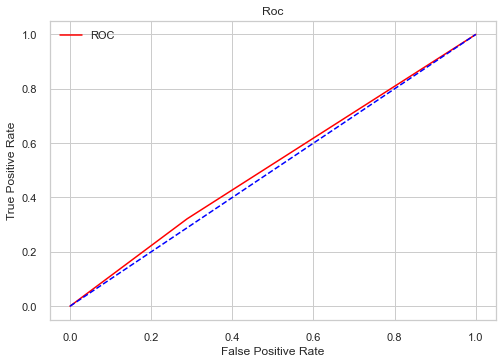

None                                                                              
score                                                                             
0.48353495562447024                                                               
params :                                                                          
{'max_depth': 2.0, 'type': 'rf'}                                                  
 91%|█████████ | 29/32 [00:17<00:01,  2.68trial/s, best loss: 0.45845556393708264]

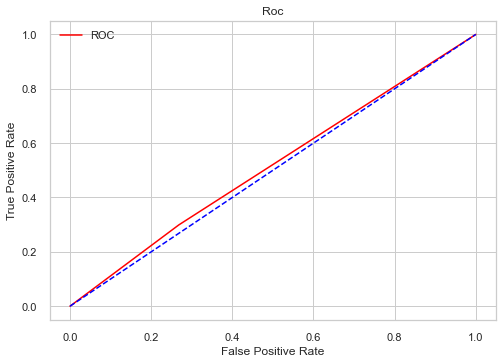

None                                                                              
score                                                                             
0.48451745685841735                                                               
params :                                                                          
{'max_depth': 2.0, 'type': 'rf'}                                                  
 94%|█████████▍| 30/32 [00:17<00:00,  2.78trial/s, best loss: 0.45845556393708264]

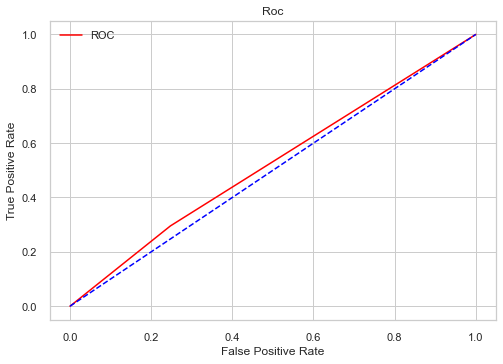

None                                                                              
score                                                                             
0.47601486324141595                                                               
params :                                                                          
{'max_depth': 2.0, 'type': 'rf'}                                                  
 97%|█████████▋| 31/32 [00:18<00:00,  2.83trial/s, best loss: 0.45845556393708264]

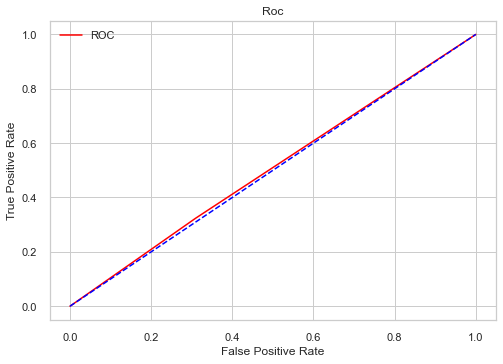

None                                                                              
score                                                                             
0.4929408916082288                                                                
100%|██████████| 32/32 [00:18<00:00,  1.74trial/s, best loss: 0.45845556393708264]
params :                                              
{'C': 1.7305768664016188, 'solver': 'lbfgs', 'type': 'logreg'}
  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

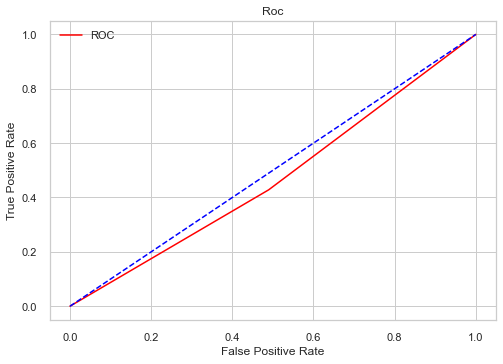

None                                                  
score                                                 
0.5306995257452575                                    
params :                                                                        
{'C': 0.9705245687917508, 'solver': 'liblinear', 'type': 'logreg'}              
  3%|▎         | 1/32 [00:00<00:06,  4.84trial/s, best loss: 0.5306995257452575]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




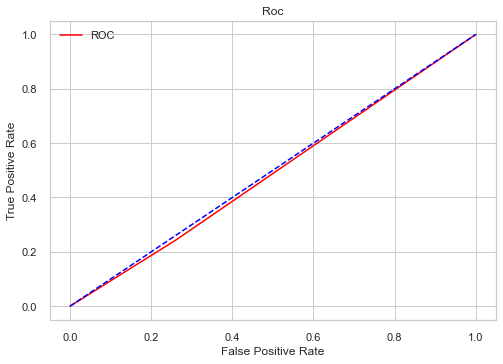

None                                                                            
score                                                                           
0.5087087850045168                                                              
params :                                                                        
{'max_depth': 3.0, 'type': 'rf'}                                                
  6%|▋         | 2/32 [00:01<00:27,  1.08trial/s, best loss: 0.5087087850045168]

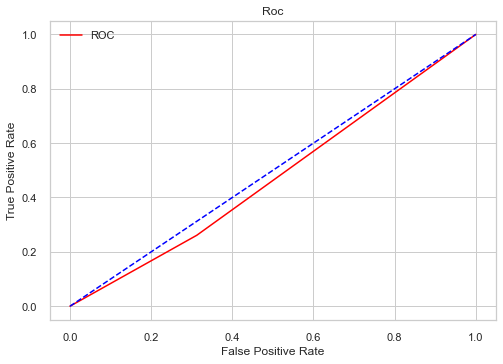

None                                                                            
score                                                                           
0.5257170280036133                                                              
params :                                                                        
{'max_depth': 2.0, 'type': 'rf'}                                                
  9%|▉         | 3/32 [00:02<00:20,  1.44trial/s, best loss: 0.5087087850045168]

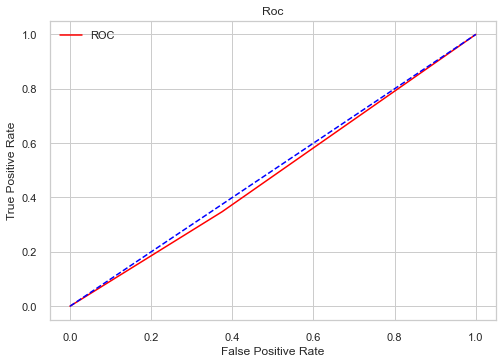

None                                                                            
score                                                                           
0.5136065943992774                                                              
params :                                                                        
{'C': 1.6309473079962666, 'solver': 'liblinear', 'type': 'logreg'}              
 12%|█▎        | 4/32 [00:02<00:15,  1.76trial/s, best loss: 0.5087087850045168]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




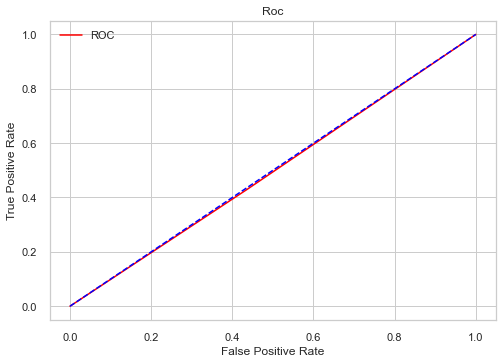

None                                                                            
score                                                                           
0.5033028455284553                                                              
params :                                                                        
{'C': 5.245694578584997, 'solver': 'liblinear', 'type': 'logreg'}               
 16%|█▌        | 5/32 [00:03<00:24,  1.12trial/s, best loss: 0.5033028455284553]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




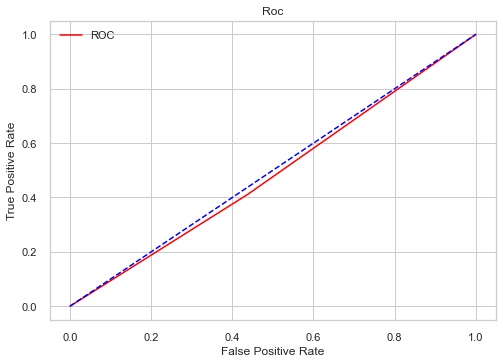

None                                                                            
score                                                                           
0.5132396115627823                                                              
params :                                                                        
{'max_depth': 5.0, 'type': 'rf'}                                                
 19%|█▉        | 6/32 [00:04<00:24,  1.05trial/s, best loss: 0.5033028455284553]

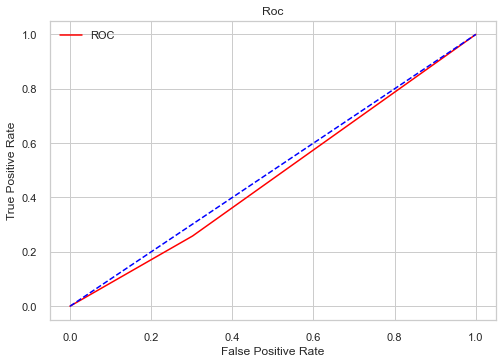

None                                                                            
score                                                                           
0.5218637082204155                                                              
params :                                                                        
{'C': 1.8778206736454115, 'solver': 'lbfgs', 'type': 'logreg'}                  
 22%|██▏       | 7/32 [00:05<00:19,  1.26trial/s, best loss: 0.5033028455284553]

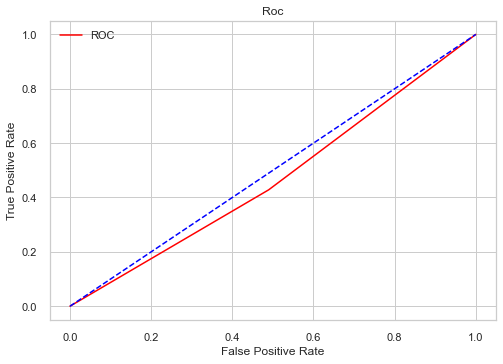

None                                                                            
score                                                                           
0.5306995257452575                                                              
params :                                                                        
{'max_depth': 4.0, 'type': 'rf'}                                                
 25%|██▌       | 8/32 [00:05<00:14,  1.66trial/s, best loss: 0.5033028455284553]

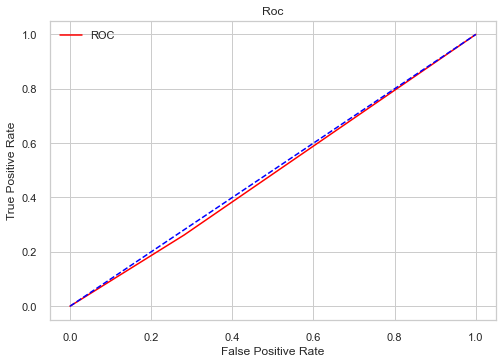

None                                                                            
score                                                                           
0.5096403568202349                                                              
params :                                                                        
{'C': 4.192568710415885, 'solver': 'lbfgs', 'type': 'logreg'}                   
 28%|██▊       | 9/32 [00:06<00:12,  1.86trial/s, best loss: 0.5033028455284553]

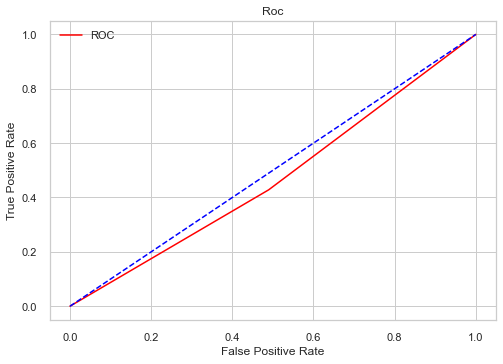

None                                                                            
score                                                                           
0.5306995257452575                                                              
params :                                                                         
{'max_depth': 5.0, 'type': 'rf'}                                                 
 31%|███▏      | 10/32 [00:06<00:09,  2.31trial/s, best loss: 0.5033028455284553]

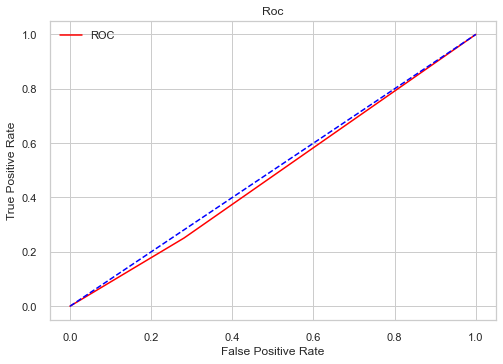

None                                                                             
score                                                                            
0.5150604110207768                                                               
params :                                                                         
{'max_depth': 2.0, 'type': 'rf'}                                                 
 34%|███▍      | 11/32 [00:06<00:09,  2.25trial/s, best loss: 0.5033028455284553]

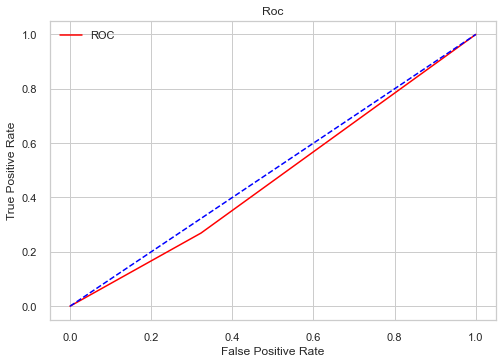

None                                                                             
score                                                                            
0.5268603206865402                                                               
params :                                                                         
{'C': 0.6648842453082919, 'solver': 'liblinear', 'type': 'logreg'}               
 38%|███▊      | 12/32 [00:07<00:08,  2.40trial/s, best loss: 0.5033028455284553]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




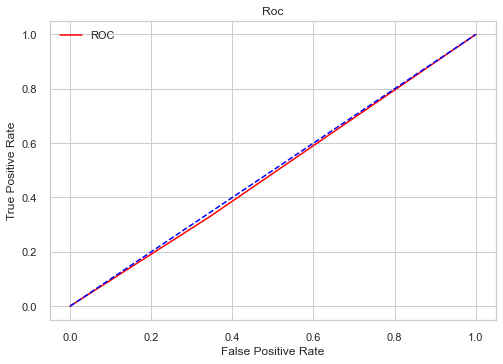

None                                                                             
score                                                                            
0.5074666892502259                                                               
params :                                                                         
{'max_depth': 2.0, 'type': 'rf'}                                                 
 41%|████      | 13/32 [00:08<00:11,  1.66trial/s, best loss: 0.5033028455284553]

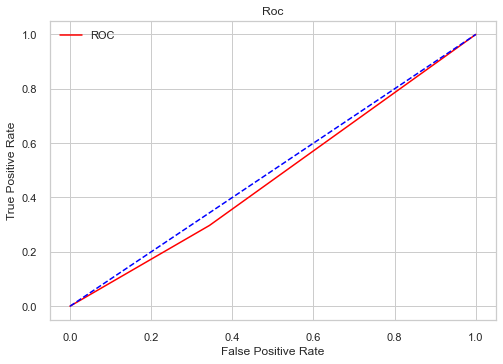

None                                                                             
score                                                                            
0.5232751806684733                                                               
params :                                                                         
{'C': 0.6215533672956916, 'solver': 'liblinear', 'type': 'logreg'}               
 44%|████▍     | 14/32 [00:08<00:09,  1.86trial/s, best loss: 0.5033028455284553]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




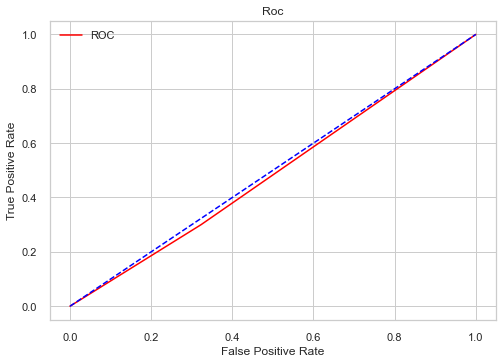

None                                                                             
score                                                                            
0.5115035004516713                                                               
params :                                                                         
{'C': 0.6145303449242923, 'solver': 'lbfgs', 'type': 'logreg'}                   
 47%|████▋     | 15/32 [00:09<00:13,  1.27trial/s, best loss: 0.5033028455284553]

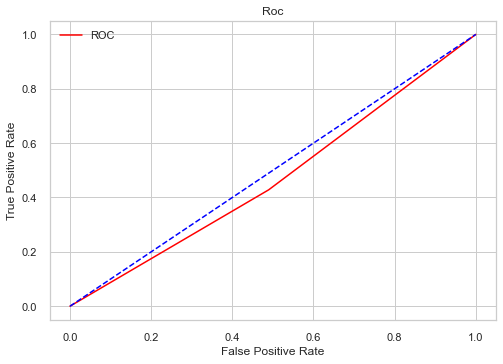

None                                                                             
score                                                                            
0.5306995257452575                                                               
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
 50%|█████     | 16/32 [00:10<00:09,  1.61trial/s, best loss: 0.5033028455284553]

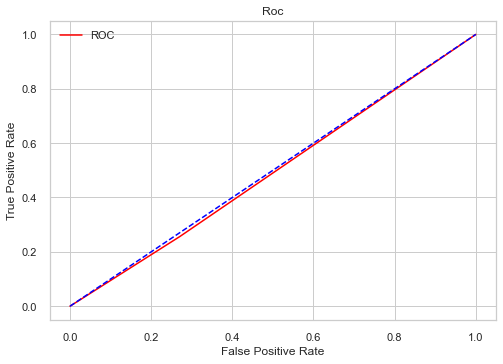

None                                                                             
score                                                                            
0.5071420505871725                                                               
params :                                                                         
{'max_depth': 4.0, 'type': 'rf'}                                                 
 53%|█████▎    | 17/32 [00:10<00:08,  1.80trial/s, best loss: 0.5033028455284553]

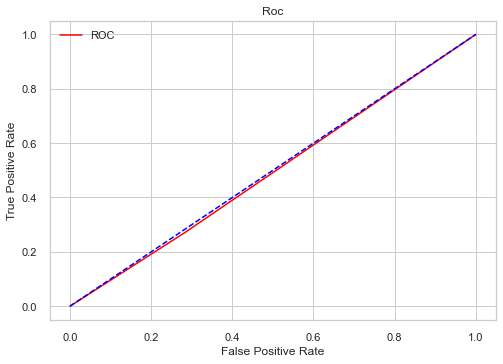

None                                                                             
score                                                                            
0.5060269873532068                                                               
params :                                                                         
{'max_depth': 4.0, 'type': 'rf'}                                                 
 56%|█████▋    | 18/32 [00:10<00:07,  1.95trial/s, best loss: 0.5033028455284553]

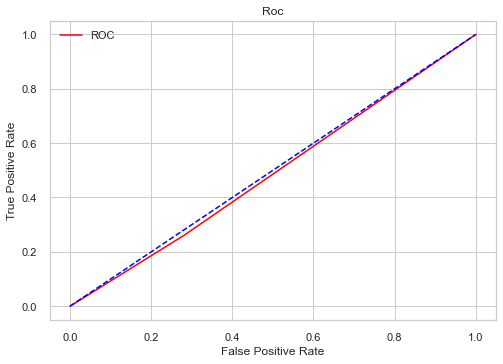

None                                                                             
score                                                                            
0.5100920280036133                                                               
params :                                                                         
{'max_depth': 3.0, 'type': 'rf'}                                                 
 59%|█████▉    | 19/32 [00:11<00:06,  2.10trial/s, best loss: 0.5033028455284553]

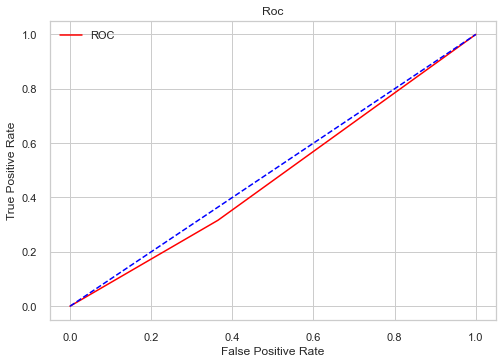

None                                                                             
score                                                                            
0.5242067524841915                                                               
params :                                                                         
{'C': 0.13134521326290202, 'solver': 'liblinear', 'type': 'logreg'}              
 62%|██████▎   | 20/32 [00:11<00:05,  2.04trial/s, best loss: 0.5033028455284553]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




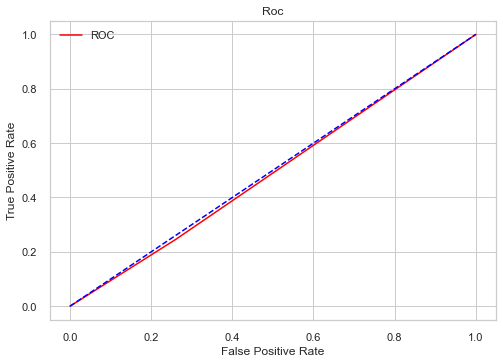

None                                                                             
score                                                                            
0.5073537714543812                                                               
params :                                                                         
{'C': 1.8633353057784834, 'solver': 'liblinear', 'type': 'logreg'}               
 66%|██████▌   | 21/32 [00:13<00:09,  1.11trial/s, best loss: 0.5033028455284553]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




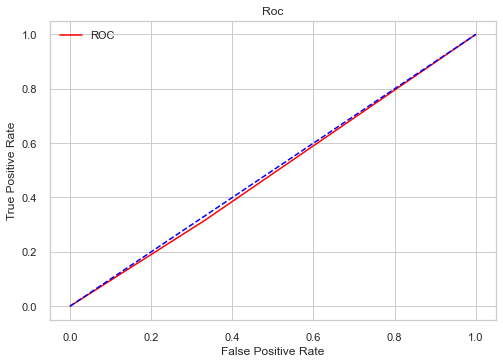

None                                                                             
score                                                                            
0.5081300813008129                                                               
params :                                                                         
{'max_depth': 4.0, 'type': 'rf'}                                                 
 69%|██████▉   | 22/32 [00:15<00:10,  1.08s/trial, best loss: 0.5033028455284553]

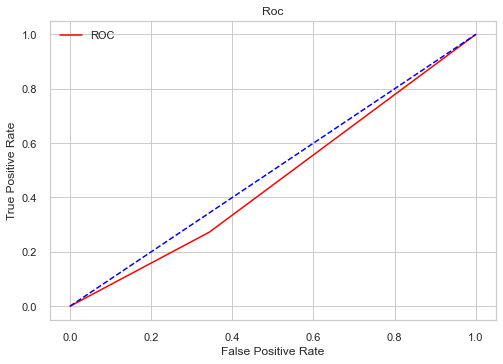

None                                                                             
score                                                                            
0.5354703026196929                                                               
params :                                                                         
{'C': 2.45027535110521, 'solver': 'liblinear', 'type': 'logreg'}                 
 72%|███████▏  | 23/32 [00:15<00:07,  1.14trial/s, best loss: 0.5033028455284553]

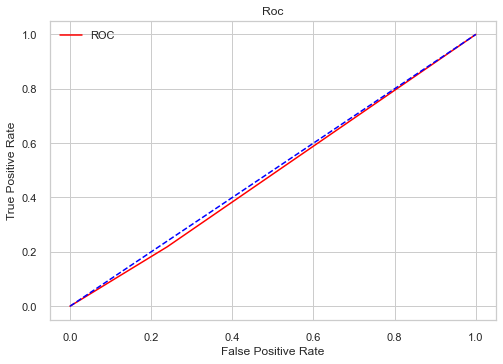

None                                                                             
score                                                                            
0.5104872402890696                                                               
params :                                                                         
{'max_depth': 5.0, 'type': 'rf'}                                                 
 75%|███████▌  | 24/32 [00:16<00:07,  1.07trial/s, best loss: 0.5033028455284553]

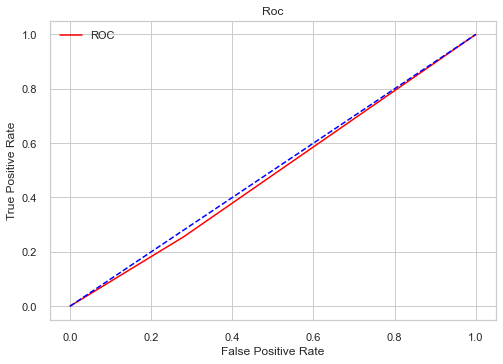

None                                                                             
score                                                                            
0.5123503839205059                                                               
params :                                                                         
{'C': 1.3056983334607766, 'solver': 'liblinear', 'type': 'logreg'}               
 78%|███████▊  | 25/32 [00:17<00:05,  1.25trial/s, best loss: 0.5033028455284553]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




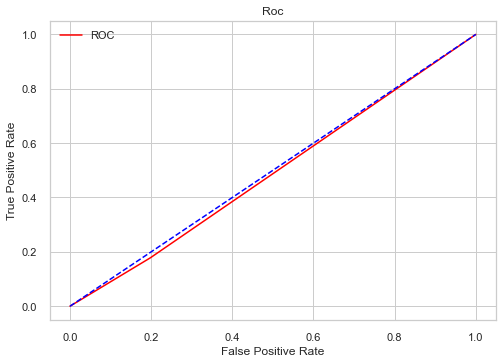

None                                                                             
score                                                                            
0.5099791102077688                                                               
params :                                                                         
{'max_depth': 4.0, 'type': 'rf'}                                                 
 81%|████████▏ | 26/32 [00:18<00:06,  1.01s/trial, best loss: 0.5033028455284553]

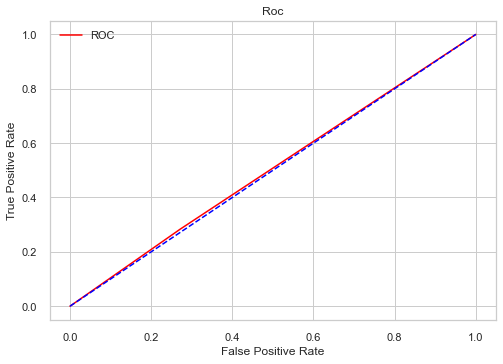

None                                                                             
score                                                                            
0.494043586269196                                                                
params :                                                                         
{'C': 2.759074031656797, 'solver': 'liblinear', 'type': 'logreg'}               
 84%|████████▍ | 27/32 [00:19<00:04,  1.20trial/s, best loss: 0.494043586269196]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




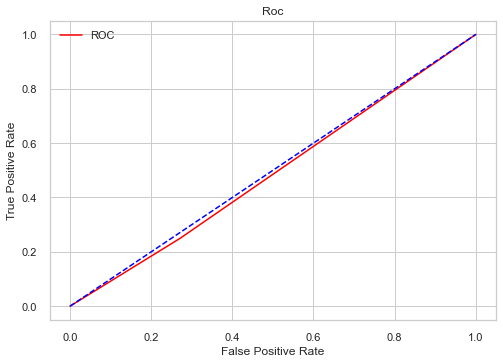

None                                                                            
score                                                                           
0.5107554200542005                                                              
params :                                                                        
{'C': 1.0002969171053822, 'solver': 'liblinear', 'type': 'logreg'}              
 88%|████████▊ | 28/32 [00:20<00:03,  1.04trial/s, best loss: 0.494043586269196]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




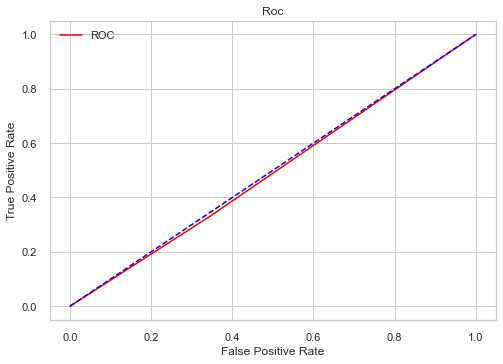

None                                                                            
score                                                                           
0.5070150180668473                                                              
params :                                                                        
{'max_depth': 3.0, 'type': 'rf'}                                                
 91%|█████████ | 29/32 [00:21<00:03,  1.13s/trial, best loss: 0.494043586269196]

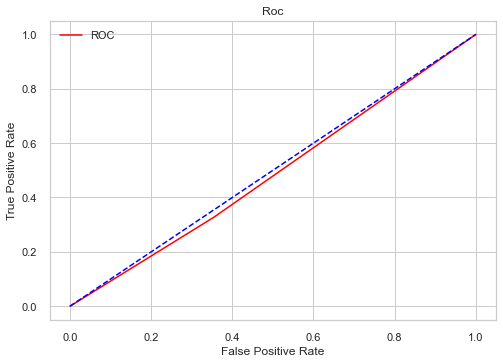

None                                                                            
score                                                                           
0.5135783649503162                                                              
params :                                                                        
{'C': 1.3924642399115505, 'solver': 'lbfgs', 'type': 'logreg'}                  
 94%|█████████▍| 30/32 [00:22<00:01,  1.09trial/s, best loss: 0.494043586269196]

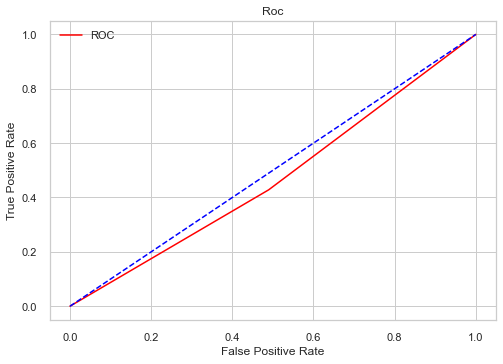

None                                                                            
score                                                                           
0.5306995257452575                                                              
params :                                                                        
{'C': 19.03953822738909, 'solver': 'liblinear', 'type': 'logreg'}               
 97%|█████████▋| 31/32 [00:22<00:00,  1.41trial/s, best loss: 0.494043586269196]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.




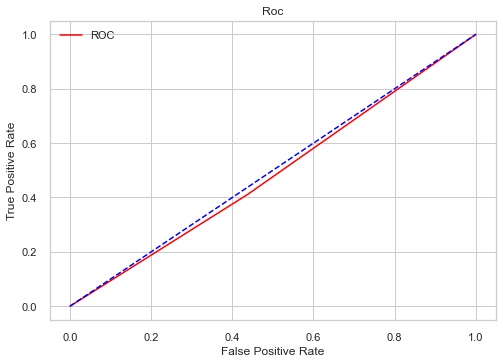

None                                                                            
score                                                                           
0.5132396115627823                                                              
100%|██████████| 32/32 [00:23<00:00,  1.36trial/s, best loss: 0.494043586269196]


In [493]:
kf = StratifiedKFold(n_splits= 10, shuffle=True, random_state=20)
result=SearchModel(df, params_feats, "TARGET", kf)

In [170]:
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [20]
}


In [171]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid_logistique = dict(solver=solvers,penalty=penalty,C=c_values)


In [340]:
params

{'n_estimators': [50, 100, 200],
 'max_depth': [4, 6, 10, 12],
 'random_state': [20]}

In [173]:
grid_logistique

{'solver': ['newton-cg', 'lbfgs', 'liblinear'],
 'penalty': ['l1', 'l2', 'elasticnet'],
 'C': [100, 10, 1.0, 0.1, 0.01]}

In [343]:
len(params)

3

# Autres methodes

In [5]:
import gc
gc.collect()

0

In [254]:
params_feats=[]
params_feats.append(feat_lgbm)
params_feats.append(selectfeatures)

In [ ]:
kf = StratifiedKFold(n_splits= 10, shuffle=True, random_state=20)
result=SearchModel(df, params_feats, "TARGET", kf)

# Métriques pour évaluer les modèles

In [447]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc')
    plt.legend()
    plt.show()

def pipeline_training_metrics(y_prob, y_test, train_df):
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(y_prob > 0.5, 1, 0) 

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    #print("false positive rate : ", false_positive_rate)
    #print("true positive rate : ", true_positive_rate)
    x_rate = false_positive_rate
    y_rate = true_positive_rate 

    # This is the ROC curve
    plot_roc_curve(x_rate,y_rate)
    
    CM = metrics.confusion_matrix(train_df['TARGET'], y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.9+FP*0.1)/(FN*0.9+FP*0.1+TN+TP)
    
    print('FULL Métrique Métier : ', metier)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    #Matrice de confusion
    conf = metrics.confusion_matrix(y_test, y_pred)
    conf
    sns.heatmap(conf, square=True, annot=True, cbar=False)
            #, xticklabels=list(iris.target_names)
            #, yticklabels=list(iris.target_names))
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.show()
    
    print("\nSur le jeu de test auc : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))
    print("\nSur le jeu de test f1_score : {:.3f}".format(metrics.f1_score(y_test, y_pred)))
    print("\nSur le jeu de test precision : {:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("\nSur le jeu de test recall : {:.3f}".format(metrics.recall_score(y_test, y_pred)))
    #
    

# Test model

Préparons les grilles de paramètres pour faire un randomforestclassifier et une regression logistique

In [583]:
df.shape

(9999, 515)

In [377]:
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [20]
}

params_r = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'max_features': [5, 10, 20],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'random_state': [20]
}

solvers = ['liblinear']
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid_logistique = dict(solver=solvers,penalty=penalty,C=c_values)
all_params = []
all_params.append(params)
all_params.append(params_r)
all_params.append(grid_logistique)
all_params

model_tuning = [RandomForestClassifier, RandomForestClassifier, LogisticRegression]
kf_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

## Choix du modèle final

Add lgbm

In [609]:
compare_model

[[{'model': sklearn.ensemble._forest.RandomForestClassifier,
   'features': Index(['CODE_GENDER', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
          'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
          'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
          'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'CNT_FAM_MEMBERS',
          'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
          'REG_CITY_NOT_LIVE_CITY', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
          'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'NONLIVINGAREA_AVG',
          'APARTMENTS_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'LANDAREA_MODE',
          'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
          'YEARS_BEGINEXPLUATATION_MEDI', 'TOTALAREA_MODE',
          'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
          'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
          'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
          'N

In [610]:
info=[]
for i in compare_model:
    info.append(i[0])



#sorted(compare_model, key=lambda x: x['roc_auc'], reverse=True)
#sorted(compare_model, key=lambda x: x['roc_auc'], reverse=True)[0]

In [619]:
model = sorted(info, key=lambda x: x['info']['roc_auc'], reverse=True)[3]

In [622]:
model['features']

Index(['CODE_GENDER', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_CITY_NOT_LIVE_CITY', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'LANDAREA_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'TOTALAREA_MODE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher_education',
       'NAME_EDUCATION_TYPE_Secondary__secondary_

In [623]:
model

{'model': sklearn.ensemble._forest.RandomForestClassifier,
 'features': Index(['CODE_GENDER', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
        'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
        'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
        'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'CNT_FAM_MEMBERS',
        'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
        'REG_CITY_NOT_LIVE_CITY', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
        'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'NONLIVINGAREA_AVG',
        'APARTMENTS_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'LANDAREA_MODE',
        'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
        'YEARS_BEGINEXPLUATATION_MEDI', 'TOTALAREA_MODE',
        'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
        'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
        'NAME_INCOME_TYPE_Working', 'NAM

In [401]:
#launch without class_weight / add temps

Le LGBM obtient de bien meilleur résultat, nous décidons donc de l'utiliser. Rechargons le.

In [500]:
import lightgbm as lgb
model = lgb.Booster(model_file='lgb_classifier.txt')

## Interprétabilité

# Test Lime

In [501]:
X_train.shape

(6999, 541)

In [502]:
feat=list(model["features"])


TypeError: 'Booster' object is not subscriptable

In [626]:
type(feat)

list

In [627]:
feat.append("TARGET")

In [628]:
feat

['CODE_GENDER',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_WORK_PHONE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ENTRANCES_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'LANDAREA_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'TOTALAREA_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher_education',
 'NAME_EDUCATION_TYPE_Secondary__secondary_special',
 'NAME_FAMILY_STATUS_Married',
 'SK_ID_CURR',
 'TARGET']

In [629]:
import lime 
from lime import lime_tabular

df_new=df.loc[:,feat].dropna()
X_train, X_test, y_train, y_test=step1_ech(df_new, "TARGET")





In [630]:
X_test

CODE_GENDER  FLAG_OWN_REALTY  AMT_INCOME_TOTAL  AMT_CREDIT  \
235979            1                0          180000.0    881055.0   
203164            0                1          144000.0   1309500.0   
85433             1                1          270000.0    331920.0   
23755             0                1          135000.0    225000.0   
141014            0                0          112500.0    204768.0   
...             ...              ...               ...         ...   
92919             1                0          450000.0    660289.5   
306395            1                0          270000.0    675000.0   
52781             0                0          112500.0    270000.0   
254876            1                1          225000.0   1303191.0   
252918            0                0          121500.0    942300.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
235979      63697.5         787500.0                    0.020246      -16522   
203164      36009.0        1309500.0                    0.032561      -18139   
85433       18135.0         225000.0                    0.020713      -13332   
23755       11875.5         225000.0                    0.025164       -9837   
141014      16308.0         162000.0                    0.010643      -10553   
...             ...              ...                         ...         ...   
92919       56799.0         585000.0                    0.072508      -13857   
306395      41427.0         675000.0                    0.028663      -20359   
52781       13500.0         270000.0                    0.022800      -15362   
254876      46939.5        1053000.0                    0.007020      -16578   
252918      27679.5         675000.0                    0.022625      -19761   

        DAYS_EMPLOYED  DAYS_REGISTRATION  ...  OBS_60_CNT_SOCIAL_CIRCLE  \
235979          -6512            -4851.0  ...                       4.0   
203164          -1129            -1280.0  ...                       0.0   
85433             -88             -254.0  ...                       4.0   
23755           -1515            -8443.0  ...                       3.0   
141014           -964             -123.0  ...                       0.0   
...               ...                ...  ...                       ...   
92919           -1223            -7966.0  ...                       0.0   
306395          -1885            -5767.0  ...                       1.0   
52781           -5174            -2551.0  ...                       0.0   
254876          -1354            -7481.0  ...                       6.0   
252918          -1350            -7101.0  ...                       5.0   

        DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_3  AMT_REQ_CREDIT_BUREAU_QRT  \
235979                   -91.0                1                        0.0   
203164                  -511.0                0                        1.0   
85433                      0.0                1                        0.0   
23755                    -82.0                1                        0.0   
141014                  -284.0                1                        0.0   
...                        ...              ...                        ...   
92919                  -1559.0                0                        0.0   
306395                     0.0                1                        0.0   
52781                   -675.0                0                        0.0   
254876                  -383.0                0                        2.0   
252918                 -1405.0                1                        2.0   

        AMT_REQ_CREDIT_BUREAU_YEAR  NAME_INCOME_TYPE_Working  \
235979                         0.0                         1   
203164                         2.0                         0   
85433                          3.0                         1   
23755                          1.0                         0   
141014                         1.0              

In [537]:
X_test.columns

Index(['CODE_GENDER', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BASEMENTAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'LANDAREA_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI',
       'LIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'NAME_CONTRACT_TYPE_Cash_loans', 'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Higher_education',
       'NAME_EDUCATION_TYPE_Secondary__secondary_special',
       'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'DAYS_EMPLOYED_PERC',
       'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON

In [631]:

rf = RandomForestClassifier(n_estimators= 200,
  max_depth= 10,
  random_state= 20)
rf.fit(X_train, y_train)

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=model['features'],
    class_names=['TARGET'],
    mode='regression'
)


In [632]:
X_train

CODE_GENDER  FLAG_OWN_REALTY  AMT_INCOME_TOTAL  AMT_CREDIT  \
8550              1                1          135000.0    405000.0   
289577            0                0          202500.0    573408.0   
219859            1                1          135000.0    512064.0   
154729            1                0          360000.0    270000.0   
281482            0                0          247500.0    343377.0   
...             ...              ...               ...         ...   
109532            1                0          112500.0    292500.0   
82626             1                0          157500.0    688500.0   
265982            0                0          135000.0    219042.0   
169089            1                1          180000.0    450000.0   
210225            0                0          171000.0    879480.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
8550        20250.0         405000.0                    0.025164      -15265   
289577      32148.0         495000.0                    0.072508      -14933   
219859      23868.0         360000.0                    0.009630      -12119   
154729      13500.0         270000.0                    0.009630      -14693   
281482      19840.5         283500.0                    0.020713      -16749   
...             ...              ...                         ...         ...   
109532      13014.0         292500.0                    0.025164      -11859   
82626       35284.5         688500.0                    0.018209      -13739   
265982      21793.5         193500.0                    0.018029      -11455   
169089      22500.0         450000.0                    0.005002      -18633   
210225      32440.5         630000.0                    0.035792      -12474   

        DAYS_EMPLOYED  DAYS_REGISTRATION  ...  OBS_60_CNT_SOCIAL_CIRCLE  \
8550            -1310            -8349.0  ...                       0.0   
289577          -2397            -9021.0  ...                       0.0   
219859           -187            -5994.0  ...                       0.0   
154729          -6377             -785.0  ...                       0.0   
281482          -2941            -3437.0  ...                       2.0   
...               ...                ...  ...                       ...   
109532           -526            -5704.0  ...                       0.0   
82626           -3996            -4027.0  ...                       1.0   
265982          -1385            -3397.0  ...                       3.0   
169089          -4676            -2410.0  ...                       1.0   
210225          -1570            -6221.0  ...                       0.0   

        DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_3  AMT_REQ_CREDIT_BUREAU_QRT  \
8550                   -1767.0                0                        1.0   
289577                  -576.0                1                        0.0   
219859                  -307.0                1                        0.0   
154729                  -728.0                0                        2.0   
281482                 -1550.0                1                        0.0   
...                        ...              ...                        ...   
109532                 -1808.0                1                        0.0   
82626                   -124.0                1                        0.0   
265982                     0.0                1                        0.0   
169089                 -2017.0                0                        0.0   
210225                  -715.0                1                        0.0   

        AMT_REQ_CREDIT_BUREAU_YEAR  NAME_INCOME_TYPE_Working  \
8550                           4.0                         1   
289577                         3.0                         0   
219859                         2.0                         1   
154729                         3.0                         1   
281482                         5.0              

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


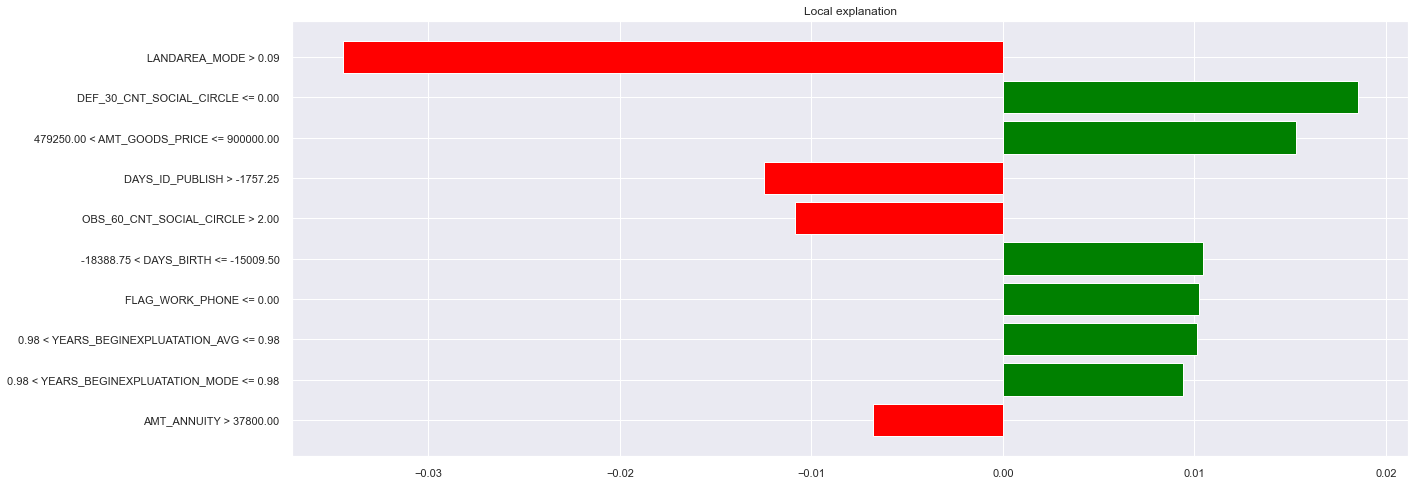

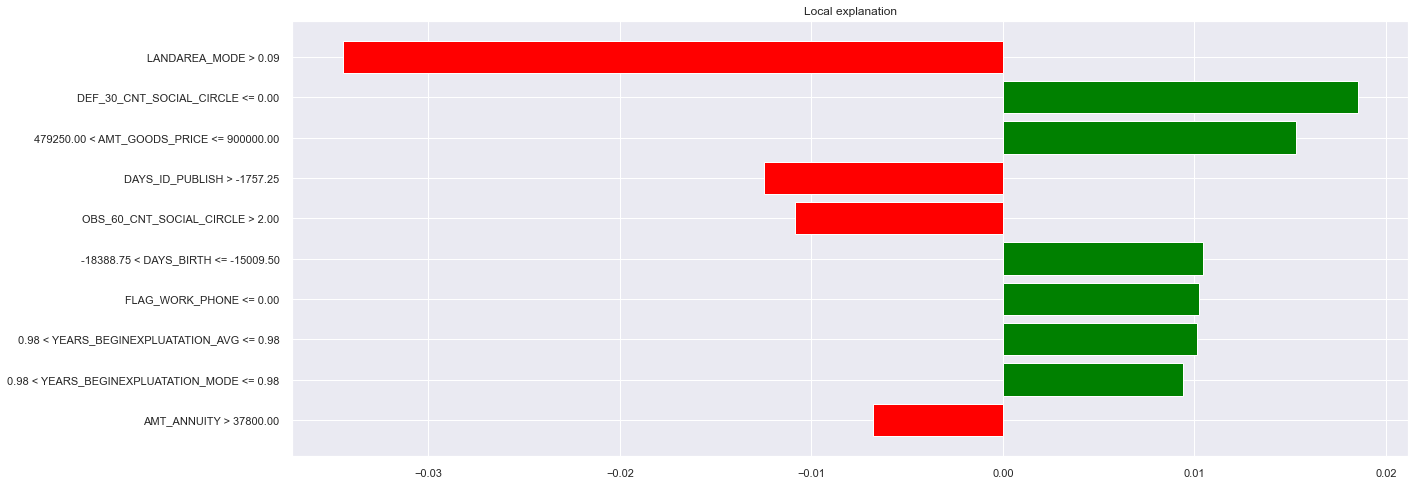

In [638]:

exp = lime_explainer.explain_instance(X_test.iloc[0], 
     rf.predict_proba, num_features=10)
exp.as_pyplot_figure()

Cela nous permet de voir les variables qui ont influencées le résultat du score négativement et positivement.

# Test shap

In [639]:
import shap
shap.initjs()

shap_explainer = shap.TreeExplainer(rf)
shap_values = shap_explainer.shap_values(X_train)



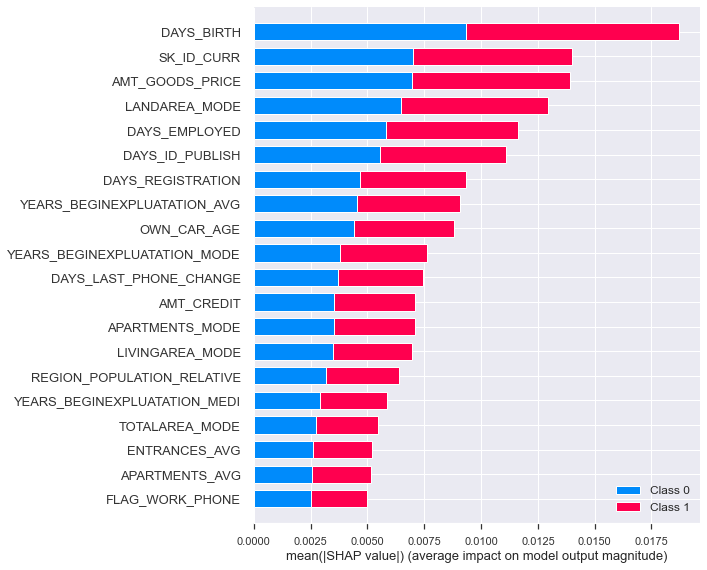

In [640]:
shap.summary_plot(shap_values, X_train)

Cela nous permet de voir quelles sont les variables qui influencent les résultats de la target.